In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
# df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
# df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
df_train_dist = pd.read_csv(OUTPUT + '20190611_train_dist_cos.csv')

In [5]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [6]:
bond_types = df_train_dist['type'].unique()

In [7]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [ ]:
rouds = 5000

In [8]:
models_0 = []
scores_0 = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':0
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rouds,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores_0 = np.hstack([scores_0, score])
    models_0.append(gbm)


[1]	valid_0's l2: 275.371
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 227.08
[3]	valid_0's l2: 187.727
[4]	valid_0's l2: 155.753
[5]	valid_0's l2: 129.79
[6]	valid_0's l2: 108.406
[7]	valid_0's l2: 90.925
[8]	valid_0's l2: 76.5793
[9]	valid_0's l2: 64.8019
[10]	valid_0's l2: 55.1943
[11]	valid_0's l2: 47.2996
[12]	valid_0's l2: 40.8321
[13]	valid_0's l2: 35.4401
[14]	valid_0's l2: 30.9981
[15]	valid_0's l2: 27.3457
[16]	valid_0's l2: 24.3349
[17]	valid_0's l2: 21.8675
[18]	valid_0's l2: 19.7996
[19]	valid_0's l2: 18.0542
[20]	valid_0's l2: 16.5967
[21]	valid_0's l2: 15.371
[22]	valid_0's l2: 14.3273
[23]	valid_0's l2: 13.4474
[24]	valid_0's l2: 12.678
[25]	valid_0's l2: 12.0429
[26]	valid_0's l2: 11.476
[27]	valid_0's l2: 10.9987
[28]	valid_0's l2: 10.5912
[29]	valid_0's l2: 10.217
[30]	valid_0's l2: 9.88555
[31]	valid_0's l2: 9.61168
[32]	valid_0's l2: 9.36162
[33]	valid_0's l2: 9.12477
[34]	valid_0's l2: 8.89864
[35]	valid_0's l2: 8.72833
[36]	vali

[301]	valid_0's l2: 3.18573
[302]	valid_0's l2: 3.18047
[303]	valid_0's l2: 3.17744
[304]	valid_0's l2: 3.17462
[305]	valid_0's l2: 3.17119
[306]	valid_0's l2: 3.16808
[307]	valid_0's l2: 3.16574
[308]	valid_0's l2: 3.16126
[309]	valid_0's l2: 3.15888
[310]	valid_0's l2: 3.15677
[311]	valid_0's l2: 3.15346
[312]	valid_0's l2: 3.15023
[313]	valid_0's l2: 3.14703
[314]	valid_0's l2: 3.14211
[315]	valid_0's l2: 3.13951
[316]	valid_0's l2: 3.13537
[317]	valid_0's l2: 3.13323
[318]	valid_0's l2: 3.12816
[319]	valid_0's l2: 3.12528
[320]	valid_0's l2: 3.12244
[321]	valid_0's l2: 3.11995
[322]	valid_0's l2: 3.11617
[323]	valid_0's l2: 3.11158
[324]	valid_0's l2: 3.10743
[325]	valid_0's l2: 3.10372
[326]	valid_0's l2: 3.10023
[327]	valid_0's l2: 3.09503
[328]	valid_0's l2: 3.09157
[329]	valid_0's l2: 3.08784
[330]	valid_0's l2: 3.08467
[331]	valid_0's l2: 3.08155
[332]	valid_0's l2: 3.07833
[333]	valid_0's l2: 3.07522
[334]	valid_0's l2: 3.07211
[335]	valid_0's l2: 3.06921
[336]	valid_0's l2: 

[597]	valid_0's l2: 2.45322
[598]	valid_0's l2: 2.45021
[599]	valid_0's l2: 2.44782
[600]	valid_0's l2: 2.44711
[601]	valid_0's l2: 2.44554
[602]	valid_0's l2: 2.44377
[603]	valid_0's l2: 2.44259
[604]	valid_0's l2: 2.4409
[605]	valid_0's l2: 2.43942
[606]	valid_0's l2: 2.43654
[607]	valid_0's l2: 2.43461
[608]	valid_0's l2: 2.43361
[609]	valid_0's l2: 2.432
[610]	valid_0's l2: 2.43122
[611]	valid_0's l2: 2.42857
[612]	valid_0's l2: 2.42699
[613]	valid_0's l2: 2.42545
[614]	valid_0's l2: 2.42379
[615]	valid_0's l2: 2.42264
[616]	valid_0's l2: 2.42133
[617]	valid_0's l2: 2.42045
[618]	valid_0's l2: 2.41869
[619]	valid_0's l2: 2.41733
[620]	valid_0's l2: 2.41652
[621]	valid_0's l2: 2.41451
[622]	valid_0's l2: 2.41217
[623]	valid_0's l2: 2.41086
[624]	valid_0's l2: 2.40965
[625]	valid_0's l2: 2.40817
[626]	valid_0's l2: 2.40661
[627]	valid_0's l2: 2.40466
[628]	valid_0's l2: 2.40265
[629]	valid_0's l2: 2.40039
[630]	valid_0's l2: 2.39906
[631]	valid_0's l2: 2.39763
[632]	valid_0's l2: 2.3

[895]	valid_0's l2: 2.09995
[896]	valid_0's l2: 2.09891
[897]	valid_0's l2: 2.09786
[898]	valid_0's l2: 2.09702
[899]	valid_0's l2: 2.09641
[900]	valid_0's l2: 2.09595
[901]	valid_0's l2: 2.09438
[902]	valid_0's l2: 2.09334
[903]	valid_0's l2: 2.09291
[904]	valid_0's l2: 2.09185
[905]	valid_0's l2: 2.09104
[906]	valid_0's l2: 2.09017
[907]	valid_0's l2: 2.08907
[908]	valid_0's l2: 2.08783
[909]	valid_0's l2: 2.08733
[910]	valid_0's l2: 2.08586
[911]	valid_0's l2: 2.08496
[912]	valid_0's l2: 2.08426
[913]	valid_0's l2: 2.08344
[914]	valid_0's l2: 2.08297
[915]	valid_0's l2: 2.08218
[916]	valid_0's l2: 2.08162
[917]	valid_0's l2: 2.08102
[918]	valid_0's l2: 2.0804
[919]	valid_0's l2: 2.07973
[920]	valid_0's l2: 2.07864
[921]	valid_0's l2: 2.07756
[922]	valid_0's l2: 2.07687
[923]	valid_0's l2: 2.07576
[924]	valid_0's l2: 2.07524
[925]	valid_0's l2: 2.07464
[926]	valid_0's l2: 2.07373
[927]	valid_0's l2: 2.07315
[928]	valid_0's l2: 2.07212
[929]	valid_0's l2: 2.07168
[930]	valid_0's l2: 2

[189]	valid_0's l2: 0.29002
[190]	valid_0's l2: 0.289301
[191]	valid_0's l2: 0.288294
[192]	valid_0's l2: 0.28732
[193]	valid_0's l2: 0.286878
[194]	valid_0's l2: 0.285812
[195]	valid_0's l2: 0.285461
[196]	valid_0's l2: 0.284931
[197]	valid_0's l2: 0.284388
[198]	valid_0's l2: 0.283351
[199]	valid_0's l2: 0.28296
[200]	valid_0's l2: 0.282463
[201]	valid_0's l2: 0.281665
[202]	valid_0's l2: 0.280879
[203]	valid_0's l2: 0.28022
[204]	valid_0's l2: 0.279652
[205]	valid_0's l2: 0.279216
[206]	valid_0's l2: 0.278456
[207]	valid_0's l2: 0.277722
[208]	valid_0's l2: 0.277037
[209]	valid_0's l2: 0.276565
[210]	valid_0's l2: 0.275811
[211]	valid_0's l2: 0.275048
[212]	valid_0's l2: 0.274349
[213]	valid_0's l2: 0.273823
[214]	valid_0's l2: 0.273138
[215]	valid_0's l2: 0.27231
[216]	valid_0's l2: 0.271562
[217]	valid_0's l2: 0.271094
[218]	valid_0's l2: 0.270573
[219]	valid_0's l2: 0.269839
[220]	valid_0's l2: 0.269105
[221]	valid_0's l2: 0.268477
[222]	valid_0's l2: 0.267992
[223]	valid_0's l2:

[476]	valid_0's l2: 0.193654
[477]	valid_0's l2: 0.193561
[478]	valid_0's l2: 0.19335
[479]	valid_0's l2: 0.19326
[480]	valid_0's l2: 0.193134
[481]	valid_0's l2: 0.193017
[482]	valid_0's l2: 0.192851
[483]	valid_0's l2: 0.192713
[484]	valid_0's l2: 0.192615
[485]	valid_0's l2: 0.192411
[486]	valid_0's l2: 0.192266
[487]	valid_0's l2: 0.192138
[488]	valid_0's l2: 0.191912
[489]	valid_0's l2: 0.191806
[490]	valid_0's l2: 0.191586
[491]	valid_0's l2: 0.191435
[492]	valid_0's l2: 0.191371
[493]	valid_0's l2: 0.191224
[494]	valid_0's l2: 0.191043
[495]	valid_0's l2: 0.190937
[496]	valid_0's l2: 0.190698
[497]	valid_0's l2: 0.190561
[498]	valid_0's l2: 0.190382
[499]	valid_0's l2: 0.190281
[500]	valid_0's l2: 0.190115
[501]	valid_0's l2: 0.189971
[502]	valid_0's l2: 0.189643
[503]	valid_0's l2: 0.189572
[504]	valid_0's l2: 0.189365
[505]	valid_0's l2: 0.189223
[506]	valid_0's l2: 0.189028
[507]	valid_0's l2: 0.188859
[508]	valid_0's l2: 0.188676
[509]	valid_0's l2: 0.188465
[510]	valid_0's 

[764]	valid_0's l2: 0.159303
[765]	valid_0's l2: 0.159179
[766]	valid_0's l2: 0.15911
[767]	valid_0's l2: 0.159004
[768]	valid_0's l2: 0.158986
[769]	valid_0's l2: 0.158844
[770]	valid_0's l2: 0.15881
[771]	valid_0's l2: 0.158679
[772]	valid_0's l2: 0.158645
[773]	valid_0's l2: 0.15857
[774]	valid_0's l2: 0.158542
[775]	valid_0's l2: 0.158427
[776]	valid_0's l2: 0.158351
[777]	valid_0's l2: 0.158256
[778]	valid_0's l2: 0.158203
[779]	valid_0's l2: 0.158113
[780]	valid_0's l2: 0.157995
[781]	valid_0's l2: 0.15795
[782]	valid_0's l2: 0.15783
[783]	valid_0's l2: 0.157784
[784]	valid_0's l2: 0.157717
[785]	valid_0's l2: 0.157688
[786]	valid_0's l2: 0.157572
[787]	valid_0's l2: 0.157512
[788]	valid_0's l2: 0.157459
[789]	valid_0's l2: 0.157386
[790]	valid_0's l2: 0.15736
[791]	valid_0's l2: 0.157231
[792]	valid_0's l2: 0.15706
[793]	valid_0's l2: 0.156927
[794]	valid_0's l2: 0.156835
[795]	valid_0's l2: 0.156781
[796]	valid_0's l2: 0.156758
[797]	valid_0's l2: 0.156707
[798]	valid_0's l2: 0

[55]	valid_0's l2: 1.06659
[56]	valid_0's l2: 1.05406
[57]	valid_0's l2: 1.04313
[58]	valid_0's l2: 1.03531
[59]	valid_0's l2: 1.0249
[60]	valid_0's l2: 1.01522
[61]	valid_0's l2: 1.00253
[62]	valid_0's l2: 0.995971
[63]	valid_0's l2: 0.986155
[64]	valid_0's l2: 0.977251
[65]	valid_0's l2: 0.967918
[66]	valid_0's l2: 0.952877
[67]	valid_0's l2: 0.944857
[68]	valid_0's l2: 0.934536
[69]	valid_0's l2: 0.92645
[70]	valid_0's l2: 0.918747
[71]	valid_0's l2: 0.912857
[72]	valid_0's l2: 0.902228
[73]	valid_0's l2: 0.894875
[74]	valid_0's l2: 0.890971
[75]	valid_0's l2: 0.881397
[76]	valid_0's l2: 0.876513
[77]	valid_0's l2: 0.87114
[78]	valid_0's l2: 0.866993
[79]	valid_0's l2: 0.862252
[80]	valid_0's l2: 0.85825
[81]	valid_0's l2: 0.853248
[82]	valid_0's l2: 0.848119
[83]	valid_0's l2: 0.844256
[84]	valid_0's l2: 0.839283
[85]	valid_0's l2: 0.833303
[86]	valid_0's l2: 0.829035
[87]	valid_0's l2: 0.822191
[88]	valid_0's l2: 0.818833
[89]	valid_0's l2: 0.815588
[90]	valid_0's l2: 0.811858
[91

[352]	valid_0's l2: 0.473066
[353]	valid_0's l2: 0.472808
[354]	valid_0's l2: 0.472332
[355]	valid_0's l2: 0.472091
[356]	valid_0's l2: 0.471872
[357]	valid_0's l2: 0.471683
[358]	valid_0's l2: 0.471667
[359]	valid_0's l2: 0.471325
[360]	valid_0's l2: 0.471079
[361]	valid_0's l2: 0.469901
[362]	valid_0's l2: 0.469368
[363]	valid_0's l2: 0.469119
[364]	valid_0's l2: 0.468749
[365]	valid_0's l2: 0.468476
[366]	valid_0's l2: 0.468441
[367]	valid_0's l2: 0.467974
[368]	valid_0's l2: 0.467607
[369]	valid_0's l2: 0.467372
[370]	valid_0's l2: 0.46698
[371]	valid_0's l2: 0.466538
[372]	valid_0's l2: 0.465993
[373]	valid_0's l2: 0.466055
[374]	valid_0's l2: 0.465846
[375]	valid_0's l2: 0.465364
[376]	valid_0's l2: 0.465049
[377]	valid_0's l2: 0.46471
[378]	valid_0's l2: 0.46455
[379]	valid_0's l2: 0.464067
[380]	valid_0's l2: 0.463342
[381]	valid_0's l2: 0.463011
[382]	valid_0's l2: 0.462738
[383]	valid_0's l2: 0.462477
[384]	valid_0's l2: 0.462144
[385]	valid_0's l2: 0.462088
[386]	valid_0's l

[667]	valid_0's l2: 0.401823
[668]	valid_0's l2: 0.401739
[669]	valid_0's l2: 0.401701
[670]	valid_0's l2: 0.401619
[671]	valid_0's l2: 0.401546
[672]	valid_0's l2: 0.401375
[673]	valid_0's l2: 0.401186
[674]	valid_0's l2: 0.401198
[675]	valid_0's l2: 0.401116
[676]	valid_0's l2: 0.400978
[677]	valid_0's l2: 0.400848
[678]	valid_0's l2: 0.400794
[679]	valid_0's l2: 0.400785
[680]	valid_0's l2: 0.400596
[681]	valid_0's l2: 0.400453
[682]	valid_0's l2: 0.400349
[683]	valid_0's l2: 0.400518
[684]	valid_0's l2: 0.400535
[685]	valid_0's l2: 0.400402
[686]	valid_0's l2: 0.400285
[687]	valid_0's l2: 0.400213
[688]	valid_0's l2: 0.400357
[689]	valid_0's l2: 0.400188
[690]	valid_0's l2: 0.400176
[691]	valid_0's l2: 0.400065
[692]	valid_0's l2: 0.399922
[693]	valid_0's l2: 0.399732
[694]	valid_0's l2: 0.399702
[695]	valid_0's l2: 0.399603
[696]	valid_0's l2: 0.399472
[697]	valid_0's l2: 0.399337
[698]	valid_0's l2: 0.399202
[699]	valid_0's l2: 0.399154
[700]	valid_0's l2: 0.398978
[701]	valid_0'

[985]	valid_0's l2: 0.375204
[986]	valid_0's l2: 0.375124
[987]	valid_0's l2: 0.374925
[988]	valid_0's l2: 0.374802
[989]	valid_0's l2: 0.374746
[990]	valid_0's l2: 0.374743
[991]	valid_0's l2: 0.374675
[992]	valid_0's l2: 0.374657
[993]	valid_0's l2: 0.374578
[994]	valid_0's l2: 0.374416
[995]	valid_0's l2: 0.374356
[996]	valid_0's l2: 0.374241
[997]	valid_0's l2: 0.374181
[998]	valid_0's l2: 0.374129
[999]	valid_0's l2: 0.37406
[1000]	valid_0's l2: 0.374048
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.374048
[1]	valid_0's l2: 11.4611
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 9.73819
[3]	valid_0's l2: 8.31924
[4]	valid_0's l2: 7.12978
[5]	valid_0's l2: 6.15968
[6]	valid_0's l2: 5.36033
[7]	valid_0's l2: 4.68382
[8]	valid_0's l2: 4.11199
[9]	valid_0's l2: 3.64614
[10]	valid_0's l2: 3.23256
[11]	valid_0's l2: 2.8896
[12]	valid_0's l2: 2.58975
[13]	valid_0's l2: 2.34728
[14]	valid_0's l2: 2.15247
[15]	valid_0's l2: 1.96582
[

[274]	valid_0's l2: 0.251677
[275]	valid_0's l2: 0.251428
[276]	valid_0's l2: 0.250936
[277]	valid_0's l2: 0.250387
[278]	valid_0's l2: 0.250235
[279]	valid_0's l2: 0.249947
[280]	valid_0's l2: 0.249599
[281]	valid_0's l2: 0.249093
[282]	valid_0's l2: 0.24863
[283]	valid_0's l2: 0.247974
[284]	valid_0's l2: 0.247745
[285]	valid_0's l2: 0.247312
[286]	valid_0's l2: 0.246838
[287]	valid_0's l2: 0.246616
[288]	valid_0's l2: 0.246275
[289]	valid_0's l2: 0.245901
[290]	valid_0's l2: 0.245661
[291]	valid_0's l2: 0.245471
[292]	valid_0's l2: 0.245131
[293]	valid_0's l2: 0.244911
[294]	valid_0's l2: 0.24468
[295]	valid_0's l2: 0.244125
[296]	valid_0's l2: 0.243749
[297]	valid_0's l2: 0.243376
[298]	valid_0's l2: 0.243203
[299]	valid_0's l2: 0.242772
[300]	valid_0's l2: 0.242258
[301]	valid_0's l2: 0.241913
[302]	valid_0's l2: 0.241692
[303]	valid_0's l2: 0.241285
[304]	valid_0's l2: 0.240857
[305]	valid_0's l2: 0.240557
[306]	valid_0's l2: 0.240005
[307]	valid_0's l2: 0.239841
[308]	valid_0's 

[566]	valid_0's l2: 0.186745
[567]	valid_0's l2: 0.18662
[568]	valid_0's l2: 0.186449
[569]	valid_0's l2: 0.18635
[570]	valid_0's l2: 0.186267
[571]	valid_0's l2: 0.186183
[572]	valid_0's l2: 0.18606
[573]	valid_0's l2: 0.185978
[574]	valid_0's l2: 0.185922
[575]	valid_0's l2: 0.185799
[576]	valid_0's l2: 0.185703
[577]	valid_0's l2: 0.185543
[578]	valid_0's l2: 0.185388
[579]	valid_0's l2: 0.185267
[580]	valid_0's l2: 0.18509
[581]	valid_0's l2: 0.184949
[582]	valid_0's l2: 0.184836
[583]	valid_0's l2: 0.184696
[584]	valid_0's l2: 0.184619
[585]	valid_0's l2: 0.18441
[586]	valid_0's l2: 0.184248
[587]	valid_0's l2: 0.18412
[588]	valid_0's l2: 0.183986
[589]	valid_0's l2: 0.183922
[590]	valid_0's l2: 0.183842
[591]	valid_0's l2: 0.183727
[592]	valid_0's l2: 0.183436
[593]	valid_0's l2: 0.183355
[594]	valid_0's l2: 0.183175
[595]	valid_0's l2: 0.18312
[596]	valid_0's l2: 0.183007
[597]	valid_0's l2: 0.182939
[598]	valid_0's l2: 0.182752
[599]	valid_0's l2: 0.182549
[600]	valid_0's l2: 0

[868]	valid_0's l2: 0.157976
[869]	valid_0's l2: 0.157897
[870]	valid_0's l2: 0.157807
[871]	valid_0's l2: 0.157724
[872]	valid_0's l2: 0.157618
[873]	valid_0's l2: 0.15748
[874]	valid_0's l2: 0.157418
[875]	valid_0's l2: 0.157357
[876]	valid_0's l2: 0.157303
[877]	valid_0's l2: 0.157253
[878]	valid_0's l2: 0.157221
[879]	valid_0's l2: 0.157158
[880]	valid_0's l2: 0.157121
[881]	valid_0's l2: 0.157066
[882]	valid_0's l2: 0.156996
[883]	valid_0's l2: 0.156969
[884]	valid_0's l2: 0.156876
[885]	valid_0's l2: 0.15682
[886]	valid_0's l2: 0.156785
[887]	valid_0's l2: 0.156737
[888]	valid_0's l2: 0.156692
[889]	valid_0's l2: 0.156597
[890]	valid_0's l2: 0.156582
[891]	valid_0's l2: 0.156518
[892]	valid_0's l2: 0.156478
[893]	valid_0's l2: 0.156394
[894]	valid_0's l2: 0.156316
[895]	valid_0's l2: 0.15619
[896]	valid_0's l2: 0.156168
[897]	valid_0's l2: 0.156132
[898]	valid_0's l2: 0.156117
[899]	valid_0's l2: 0.155959
[900]	valid_0's l2: 0.155941
[901]	valid_0's l2: 0.155927
[902]	valid_0's l

[156]	valid_0's l2: 1.19283
[157]	valid_0's l2: 1.18932
[158]	valid_0's l2: 1.18631
[159]	valid_0's l2: 1.18369
[160]	valid_0's l2: 1.18091
[161]	valid_0's l2: 1.17858
[162]	valid_0's l2: 1.17549
[163]	valid_0's l2: 1.17353
[164]	valid_0's l2: 1.17188
[165]	valid_0's l2: 1.17073
[166]	valid_0's l2: 1.16857
[167]	valid_0's l2: 1.16705
[168]	valid_0's l2: 1.16405
[169]	valid_0's l2: 1.1622
[170]	valid_0's l2: 1.16047
[171]	valid_0's l2: 1.15787
[172]	valid_0's l2: 1.1536
[173]	valid_0's l2: 1.14995
[174]	valid_0's l2: 1.14491
[175]	valid_0's l2: 1.14345
[176]	valid_0's l2: 1.14198
[177]	valid_0's l2: 1.14026
[178]	valid_0's l2: 1.13521
[179]	valid_0's l2: 1.13233
[180]	valid_0's l2: 1.13079
[181]	valid_0's l2: 1.12814
[182]	valid_0's l2: 1.12284
[183]	valid_0's l2: 1.12104
[184]	valid_0's l2: 1.11885
[185]	valid_0's l2: 1.11662
[186]	valid_0's l2: 1.11489
[187]	valid_0's l2: 1.11259
[188]	valid_0's l2: 1.10896
[189]	valid_0's l2: 1.10668
[190]	valid_0's l2: 1.10482
[191]	valid_0's l2: 1.

[443]	valid_0's l2: 0.800488
[444]	valid_0's l2: 0.800093
[445]	valid_0's l2: 0.799277
[446]	valid_0's l2: 0.798896
[447]	valid_0's l2: 0.798311
[448]	valid_0's l2: 0.79762
[449]	valid_0's l2: 0.797337
[450]	valid_0's l2: 0.79665
[451]	valid_0's l2: 0.796029
[452]	valid_0's l2: 0.795409
[453]	valid_0's l2: 0.794362
[454]	valid_0's l2: 0.79383
[455]	valid_0's l2: 0.792859
[456]	valid_0's l2: 0.792474
[457]	valid_0's l2: 0.791814
[458]	valid_0's l2: 0.791261
[459]	valid_0's l2: 0.790317
[460]	valid_0's l2: 0.789899
[461]	valid_0's l2: 0.789053
[462]	valid_0's l2: 0.78859
[463]	valid_0's l2: 0.787303
[464]	valid_0's l2: 0.785916
[465]	valid_0's l2: 0.785335
[466]	valid_0's l2: 0.784174
[467]	valid_0's l2: 0.783494
[468]	valid_0's l2: 0.782884
[469]	valid_0's l2: 0.782259
[470]	valid_0's l2: 0.781906
[471]	valid_0's l2: 0.781269
[472]	valid_0's l2: 0.78073
[473]	valid_0's l2: 0.780251
[474]	valid_0's l2: 0.779619
[475]	valid_0's l2: 0.778717
[476]	valid_0's l2: 0.777816
[477]	valid_0's l2:

[729]	valid_0's l2: 0.655006
[730]	valid_0's l2: 0.654703
[731]	valid_0's l2: 0.654378
[732]	valid_0's l2: 0.654048
[733]	valid_0's l2: 0.65386
[734]	valid_0's l2: 0.653542
[735]	valid_0's l2: 0.653171
[736]	valid_0's l2: 0.652598
[737]	valid_0's l2: 0.652089
[738]	valid_0's l2: 0.651723
[739]	valid_0's l2: 0.651387
[740]	valid_0's l2: 0.651141
[741]	valid_0's l2: 0.650612
[742]	valid_0's l2: 0.650224
[743]	valid_0's l2: 0.649746
[744]	valid_0's l2: 0.649152
[745]	valid_0's l2: 0.648406
[746]	valid_0's l2: 0.648258
[747]	valid_0's l2: 0.647802
[748]	valid_0's l2: 0.647502
[749]	valid_0's l2: 0.647342
[750]	valid_0's l2: 0.647047
[751]	valid_0's l2: 0.646589
[752]	valid_0's l2: 0.64599
[753]	valid_0's l2: 0.645879
[754]	valid_0's l2: 0.645394
[755]	valid_0's l2: 0.645
[756]	valid_0's l2: 0.644275
[757]	valid_0's l2: 0.644173
[758]	valid_0's l2: 0.644034
[759]	valid_0's l2: 0.643706
[760]	valid_0's l2: 0.643326
[761]	valid_0's l2: 0.643025
[762]	valid_0's l2: 0.642939
[763]	valid_0's l2:

[9]	valid_0's l2: 7.56968
[10]	valid_0's l2: 7.25535
[11]	valid_0's l2: 6.97803
[12]	valid_0's l2: 6.74246
[13]	valid_0's l2: 6.5121
[14]	valid_0's l2: 6.33785
[15]	valid_0's l2: 6.16754
[16]	valid_0's l2: 6.00841
[17]	valid_0's l2: 5.85246
[18]	valid_0's l2: 5.73715
[19]	valid_0's l2: 5.58325
[20]	valid_0's l2: 5.48152
[21]	valid_0's l2: 5.38033
[22]	valid_0's l2: 5.29693
[23]	valid_0's l2: 5.21676
[24]	valid_0's l2: 5.1432
[25]	valid_0's l2: 5.07205
[26]	valid_0's l2: 4.99862
[27]	valid_0's l2: 4.93963
[28]	valid_0's l2: 4.8934
[29]	valid_0's l2: 4.82241
[30]	valid_0's l2: 4.77148
[31]	valid_0's l2: 4.71498
[32]	valid_0's l2: 4.64989
[33]	valid_0's l2: 4.59296
[34]	valid_0's l2: 4.55261
[35]	valid_0's l2: 4.49684
[36]	valid_0's l2: 4.45498
[37]	valid_0's l2: 4.40386
[38]	valid_0's l2: 4.34987
[39]	valid_0's l2: 4.30801
[40]	valid_0's l2: 4.26511
[41]	valid_0's l2: 4.23352
[42]	valid_0's l2: 4.19953
[43]	valid_0's l2: 4.16317
[44]	valid_0's l2: 4.13153
[45]	valid_0's l2: 4.09893
[46]	

[307]	valid_0's l2: 2.08708
[308]	valid_0's l2: 2.08572
[309]	valid_0's l2: 2.08361
[310]	valid_0's l2: 2.08238
[311]	valid_0's l2: 2.08175
[312]	valid_0's l2: 2.07946
[313]	valid_0's l2: 2.07723
[314]	valid_0's l2: 2.07512
[315]	valid_0's l2: 2.07246
[316]	valid_0's l2: 2.06922
[317]	valid_0's l2: 2.06689
[318]	valid_0's l2: 2.06527
[319]	valid_0's l2: 2.064
[320]	valid_0's l2: 2.061
[321]	valid_0's l2: 2.05794
[322]	valid_0's l2: 2.05564
[323]	valid_0's l2: 2.05456
[324]	valid_0's l2: 2.05262
[325]	valid_0's l2: 2.05012
[326]	valid_0's l2: 2.04827
[327]	valid_0's l2: 2.04615
[328]	valid_0's l2: 2.04405
[329]	valid_0's l2: 2.04291
[330]	valid_0's l2: 2.04001
[331]	valid_0's l2: 2.03872
[332]	valid_0's l2: 2.03605
[333]	valid_0's l2: 2.03475
[334]	valid_0's l2: 2.03295
[335]	valid_0's l2: 2.03128
[336]	valid_0's l2: 2.02977
[337]	valid_0's l2: 2.02593
[338]	valid_0's l2: 2.02324
[339]	valid_0's l2: 2.02145
[340]	valid_0's l2: 2.01985
[341]	valid_0's l2: 2.01729
[342]	valid_0's l2: 2.01

[604]	valid_0's l2: 1.61405
[605]	valid_0's l2: 1.61279
[606]	valid_0's l2: 1.61074
[607]	valid_0's l2: 1.60984
[608]	valid_0's l2: 1.60851
[609]	valid_0's l2: 1.60763
[610]	valid_0's l2: 1.60619
[611]	valid_0's l2: 1.60501
[612]	valid_0's l2: 1.60449
[613]	valid_0's l2: 1.60391
[614]	valid_0's l2: 1.6037
[615]	valid_0's l2: 1.60185
[616]	valid_0's l2: 1.60139
[617]	valid_0's l2: 1.60064
[618]	valid_0's l2: 1.59979
[619]	valid_0's l2: 1.59874
[620]	valid_0's l2: 1.5983
[621]	valid_0's l2: 1.5978
[622]	valid_0's l2: 1.59689
[623]	valid_0's l2: 1.59665
[624]	valid_0's l2: 1.59533
[625]	valid_0's l2: 1.59488
[626]	valid_0's l2: 1.59378
[627]	valid_0's l2: 1.5931
[628]	valid_0's l2: 1.59269
[629]	valid_0's l2: 1.59193
[630]	valid_0's l2: 1.5913
[631]	valid_0's l2: 1.59053
[632]	valid_0's l2: 1.58969
[633]	valid_0's l2: 1.5893
[634]	valid_0's l2: 1.58843
[635]	valid_0's l2: 1.58706
[636]	valid_0's l2: 1.58665
[637]	valid_0's l2: 1.58634
[638]	valid_0's l2: 1.58504
[639]	valid_0's l2: 1.5845

[901]	valid_0's l2: 1.40068
[902]	valid_0's l2: 1.40036
[903]	valid_0's l2: 1.40004
[904]	valid_0's l2: 1.39946
[905]	valid_0's l2: 1.39868
[906]	valid_0's l2: 1.39847
[907]	valid_0's l2: 1.39799
[908]	valid_0's l2: 1.39742
[909]	valid_0's l2: 1.39699
[910]	valid_0's l2: 1.39684
[911]	valid_0's l2: 1.39647
[912]	valid_0's l2: 1.39601
[913]	valid_0's l2: 1.39556
[914]	valid_0's l2: 1.39519
[915]	valid_0's l2: 1.39475
[916]	valid_0's l2: 1.39447
[917]	valid_0's l2: 1.39255
[918]	valid_0's l2: 1.39212
[919]	valid_0's l2: 1.39174
[920]	valid_0's l2: 1.39128
[921]	valid_0's l2: 1.3907
[922]	valid_0's l2: 1.39004
[923]	valid_0's l2: 1.38957
[924]	valid_0's l2: 1.38925
[925]	valid_0's l2: 1.38899
[926]	valid_0's l2: 1.3884
[927]	valid_0's l2: 1.38707
[928]	valid_0's l2: 1.38668
[929]	valid_0's l2: 1.38617
[930]	valid_0's l2: 1.38595
[931]	valid_0's l2: 1.38537
[932]	valid_0's l2: 1.38505
[933]	valid_0's l2: 1.38458
[934]	valid_0's l2: 1.38356
[935]	valid_0's l2: 1.38299
[936]	valid_0's l2: 1.

[196]	valid_0's l2: 3.54407
[197]	valid_0's l2: 3.54042
[198]	valid_0's l2: 3.53311
[199]	valid_0's l2: 3.52859
[200]	valid_0's l2: 3.52529
[201]	valid_0's l2: 3.51975
[202]	valid_0's l2: 3.51288
[203]	valid_0's l2: 3.50935
[204]	valid_0's l2: 3.50408
[205]	valid_0's l2: 3.49944
[206]	valid_0's l2: 3.49623
[207]	valid_0's l2: 3.49343
[208]	valid_0's l2: 3.48997
[209]	valid_0's l2: 3.4862
[210]	valid_0's l2: 3.48254
[211]	valid_0's l2: 3.47901
[212]	valid_0's l2: 3.47672
[213]	valid_0's l2: 3.47433
[214]	valid_0's l2: 3.47017
[215]	valid_0's l2: 3.46742
[216]	valid_0's l2: 3.46186
[217]	valid_0's l2: 3.45693
[218]	valid_0's l2: 3.45354
[219]	valid_0's l2: 3.45112
[220]	valid_0's l2: 3.44557
[221]	valid_0's l2: 3.4407
[222]	valid_0's l2: 3.43686
[223]	valid_0's l2: 3.4336
[224]	valid_0's l2: 3.42921
[225]	valid_0's l2: 3.42652
[226]	valid_0's l2: 3.42155
[227]	valid_0's l2: 3.41706
[228]	valid_0's l2: 3.41264
[229]	valid_0's l2: 3.40975
[230]	valid_0's l2: 3.4074
[231]	valid_0's l2: 3.40

[490]	valid_0's l2: 2.76999
[491]	valid_0's l2: 2.76811
[492]	valid_0's l2: 2.7665
[493]	valid_0's l2: 2.76485
[494]	valid_0's l2: 2.76411
[495]	valid_0's l2: 2.76208
[496]	valid_0's l2: 2.7611
[497]	valid_0's l2: 2.75918
[498]	valid_0's l2: 2.75787
[499]	valid_0's l2: 2.75736
[500]	valid_0's l2: 2.75421
[501]	valid_0's l2: 2.75209
[502]	valid_0's l2: 2.74978
[503]	valid_0's l2: 2.74791
[504]	valid_0's l2: 2.74627
[505]	valid_0's l2: 2.745
[506]	valid_0's l2: 2.74342
[507]	valid_0's l2: 2.74232
[508]	valid_0's l2: 2.74164
[509]	valid_0's l2: 2.74064
[510]	valid_0's l2: 2.74
[511]	valid_0's l2: 2.73804
[512]	valid_0's l2: 2.73727
[513]	valid_0's l2: 2.73595
[514]	valid_0's l2: 2.73435
[515]	valid_0's l2: 2.73292
[516]	valid_0's l2: 2.73174
[517]	valid_0's l2: 2.73006
[518]	valid_0's l2: 2.72808
[519]	valid_0's l2: 2.72525
[520]	valid_0's l2: 2.72316
[521]	valid_0's l2: 2.72126
[522]	valid_0's l2: 2.7177
[523]	valid_0's l2: 2.71582
[524]	valid_0's l2: 2.71464
[525]	valid_0's l2: 2.71296


[787]	valid_0's l2: 2.41067
[788]	valid_0's l2: 2.40988
[789]	valid_0's l2: 2.40949
[790]	valid_0's l2: 2.40826
[791]	valid_0's l2: 2.40763
[792]	valid_0's l2: 2.40698
[793]	valid_0's l2: 2.40426
[794]	valid_0's l2: 2.4036
[795]	valid_0's l2: 2.40212
[796]	valid_0's l2: 2.40102
[797]	valid_0's l2: 2.39868
[798]	valid_0's l2: 2.39759
[799]	valid_0's l2: 2.39598
[800]	valid_0's l2: 2.39495
[801]	valid_0's l2: 2.39379
[802]	valid_0's l2: 2.39294
[803]	valid_0's l2: 2.3926
[804]	valid_0's l2: 2.39132
[805]	valid_0's l2: 2.39014
[806]	valid_0's l2: 2.38838
[807]	valid_0's l2: 2.38765
[808]	valid_0's l2: 2.38642
[809]	valid_0's l2: 2.38514
[810]	valid_0's l2: 2.38422
[811]	valid_0's l2: 2.38312
[812]	valid_0's l2: 2.38167
[813]	valid_0's l2: 2.38097
[814]	valid_0's l2: 2.37958
[815]	valid_0's l2: 2.37877
[816]	valid_0's l2: 2.37816
[817]	valid_0's l2: 2.37731
[818]	valid_0's l2: 2.37683
[819]	valid_0's l2: 2.37589
[820]	valid_0's l2: 2.37422
[821]	valid_0's l2: 2.37364
[822]	valid_0's l2: 2.

[79]	valid_0's l2: 0.278226
[80]	valid_0's l2: 0.277191
[81]	valid_0's l2: 0.276185
[82]	valid_0's l2: 0.274595
[83]	valid_0's l2: 0.273656
[84]	valid_0's l2: 0.272404
[85]	valid_0's l2: 0.271326
[86]	valid_0's l2: 0.270516
[87]	valid_0's l2: 0.269342
[88]	valid_0's l2: 0.267913
[89]	valid_0's l2: 0.266584
[90]	valid_0's l2: 0.265347
[91]	valid_0's l2: 0.264052
[92]	valid_0's l2: 0.263276
[93]	valid_0's l2: 0.261905
[94]	valid_0's l2: 0.2609
[95]	valid_0's l2: 0.259823
[96]	valid_0's l2: 0.258371
[97]	valid_0's l2: 0.257351
[98]	valid_0's l2: 0.25609
[99]	valid_0's l2: 0.255161
[100]	valid_0's l2: 0.254088
[101]	valid_0's l2: 0.2529
[102]	valid_0's l2: 0.251891
[103]	valid_0's l2: 0.250109
[104]	valid_0's l2: 0.249413
[105]	valid_0's l2: 0.248467
[106]	valid_0's l2: 0.247695
[107]	valid_0's l2: 0.246705
[108]	valid_0's l2: 0.2457
[109]	valid_0's l2: 0.244967
[110]	valid_0's l2: 0.244183
[111]	valid_0's l2: 0.243211
[112]	valid_0's l2: 0.242025
[113]	valid_0's l2: 0.241368
[114]	valid_0

[367]	valid_0's l2: 0.153398
[368]	valid_0's l2: 0.153241
[369]	valid_0's l2: 0.153124
[370]	valid_0's l2: 0.152877
[371]	valid_0's l2: 0.1528
[372]	valid_0's l2: 0.152636
[373]	valid_0's l2: 0.152522
[374]	valid_0's l2: 0.15238
[375]	valid_0's l2: 0.15232
[376]	valid_0's l2: 0.152159
[377]	valid_0's l2: 0.152018
[378]	valid_0's l2: 0.151882
[379]	valid_0's l2: 0.151785
[380]	valid_0's l2: 0.151659
[381]	valid_0's l2: 0.151579
[382]	valid_0's l2: 0.15142
[383]	valid_0's l2: 0.151056
[384]	valid_0's l2: 0.150996
[385]	valid_0's l2: 0.150895
[386]	valid_0's l2: 0.150717
[387]	valid_0's l2: 0.150571
[388]	valid_0's l2: 0.150419
[389]	valid_0's l2: 0.150241
[390]	valid_0's l2: 0.149944
[391]	valid_0's l2: 0.1498
[392]	valid_0's l2: 0.149641
[393]	valid_0's l2: 0.149474
[394]	valid_0's l2: 0.149095
[395]	valid_0's l2: 0.148988
[396]	valid_0's l2: 0.148786
[397]	valid_0's l2: 0.148624
[398]	valid_0's l2: 0.148559
[399]	valid_0's l2: 0.14845
[400]	valid_0's l2: 0.148342
[401]	valid_0's l2: 0.

[656]	valid_0's l2: 0.122237
[657]	valid_0's l2: 0.122144
[658]	valid_0's l2: 0.122009
[659]	valid_0's l2: 0.121893
[660]	valid_0's l2: 0.121836
[661]	valid_0's l2: 0.121817
[662]	valid_0's l2: 0.121783
[663]	valid_0's l2: 0.121744
[664]	valid_0's l2: 0.12171
[665]	valid_0's l2: 0.121555
[666]	valid_0's l2: 0.121516
[667]	valid_0's l2: 0.12149
[668]	valid_0's l2: 0.121476
[669]	valid_0's l2: 0.121443
[670]	valid_0's l2: 0.121332
[671]	valid_0's l2: 0.12125
[672]	valid_0's l2: 0.12123
[673]	valid_0's l2: 0.121205
[674]	valid_0's l2: 0.121166
[675]	valid_0's l2: 0.121087
[676]	valid_0's l2: 0.121029
[677]	valid_0's l2: 0.121
[678]	valid_0's l2: 0.120939
[679]	valid_0's l2: 0.120849
[680]	valid_0's l2: 0.120754
[681]	valid_0's l2: 0.120722
[682]	valid_0's l2: 0.1207
[683]	valid_0's l2: 0.120656
[684]	valid_0's l2: 0.120562
[685]	valid_0's l2: 0.120536
[686]	valid_0's l2: 0.120484
[687]	valid_0's l2: 0.120422
[688]	valid_0's l2: 0.120365
[689]	valid_0's l2: 0.120332
[690]	valid_0's l2: 0.1

[946]	valid_0's l2: 0.107711
[947]	valid_0's l2: 0.107692
[948]	valid_0's l2: 0.10766
[949]	valid_0's l2: 0.107654
[950]	valid_0's l2: 0.107599
[951]	valid_0's l2: 0.107583
[952]	valid_0's l2: 0.107551
[953]	valid_0's l2: 0.107501
[954]	valid_0's l2: 0.107484
[955]	valid_0's l2: 0.107458
[956]	valid_0's l2: 0.107436
[957]	valid_0's l2: 0.107413
[958]	valid_0's l2: 0.107357
[959]	valid_0's l2: 0.107281
[960]	valid_0's l2: 0.107238
[961]	valid_0's l2: 0.107165
[962]	valid_0's l2: 0.107141
[963]	valid_0's l2: 0.10712
[964]	valid_0's l2: 0.107081
[965]	valid_0's l2: 0.107067
[966]	valid_0's l2: 0.107004
[967]	valid_0's l2: 0.106925
[968]	valid_0's l2: 0.106913
[969]	valid_0's l2: 0.1069
[970]	valid_0's l2: 0.10688
[971]	valid_0's l2: 0.10681
[972]	valid_0's l2: 0.106797
[973]	valid_0's l2: 0.106779
[974]	valid_0's l2: 0.106735
[975]	valid_0's l2: 0.106698
[976]	valid_0's l2: 0.106671
[977]	valid_0's l2: 0.106654
[978]	valid_0's l2: 0.106633
[979]	valid_0's l2: 0.106575
[980]	valid_0's l2: 

In [9]:
print('type score:', scores_0)
print('total score:', scores_0.mean())

type score: [ 0.00774459 -1.41208161 -0.99990751 -1.41204985 -0.68527494 -0.26120294
  0.08742746 -1.54700587]
total score: -0.7777938340902641


In [10]:
models_1 = []
scores_1 = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':1
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rouds,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores_1 = np.hstack([scores_1, score])
    models_1.append(gbm)


[1]	valid_0's l2: 275.341
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 226.94
[3]	valid_0's l2: 187.489
[4]	valid_0's l2: 155.601
[5]	valid_0's l2: 129.496
[6]	valid_0's l2: 108.102
[7]	valid_0's l2: 90.7488
[8]	valid_0's l2: 76.589
[9]	valid_0's l2: 64.8714
[10]	valid_0's l2: 55.2046
[11]	valid_0's l2: 47.2642
[12]	valid_0's l2: 40.7938
[13]	valid_0's l2: 35.4675
[14]	valid_0's l2: 31.0604
[15]	valid_0's l2: 27.4317
[16]	valid_0's l2: 24.4424
[17]	valid_0's l2: 21.9439
[18]	valid_0's l2: 19.8432
[19]	valid_0's l2: 18.106
[20]	valid_0's l2: 16.6429
[21]	valid_0's l2: 15.4045
[22]	valid_0's l2: 14.3862
[23]	valid_0's l2: 13.52
[24]	valid_0's l2: 12.7746
[25]	valid_0's l2: 12.1115
[26]	valid_0's l2: 11.5685
[27]	valid_0's l2: 11.0998
[28]	valid_0's l2: 10.6771
[29]	valid_0's l2: 10.3204
[30]	valid_0's l2: 9.98812
[31]	valid_0's l2: 9.71485
[32]	valid_0's l2: 9.46197
[33]	valid_0's l2: 9.22974
[34]	valid_0's l2: 9.01802
[35]	valid_0's l2: 8.82431
[36]	va

[297]	valid_0's l2: 3.18183
[298]	valid_0's l2: 3.17711
[299]	valid_0's l2: 3.17198
[300]	valid_0's l2: 3.16726
[301]	valid_0's l2: 3.16379
[302]	valid_0's l2: 3.15958
[303]	valid_0's l2: 3.15622
[304]	valid_0's l2: 3.15198
[305]	valid_0's l2: 3.14695
[306]	valid_0's l2: 3.14265
[307]	valid_0's l2: 3.13931
[308]	valid_0's l2: 3.13614
[309]	valid_0's l2: 3.13198
[310]	valid_0's l2: 3.12731
[311]	valid_0's l2: 3.12448
[312]	valid_0's l2: 3.12132
[313]	valid_0's l2: 3.11748
[314]	valid_0's l2: 3.11468
[315]	valid_0's l2: 3.11188
[316]	valid_0's l2: 3.10698
[317]	valid_0's l2: 3.10212
[318]	valid_0's l2: 3.09829
[319]	valid_0's l2: 3.09305
[320]	valid_0's l2: 3.0903
[321]	valid_0's l2: 3.08798
[322]	valid_0's l2: 3.08536
[323]	valid_0's l2: 3.08194
[324]	valid_0's l2: 3.078
[325]	valid_0's l2: 3.07469
[326]	valid_0's l2: 3.0707
[327]	valid_0's l2: 3.06718
[328]	valid_0's l2: 3.06238
[329]	valid_0's l2: 3.05939
[330]	valid_0's l2: 3.05628
[331]	valid_0's l2: 3.05246
[332]	valid_0's l2: 3.04

[593]	valid_0's l2: 2.44045
[594]	valid_0's l2: 2.43876
[595]	valid_0's l2: 2.43758
[596]	valid_0's l2: 2.43468
[597]	valid_0's l2: 2.43305
[598]	valid_0's l2: 2.43151
[599]	valid_0's l2: 2.43069
[600]	valid_0's l2: 2.42972
[601]	valid_0's l2: 2.42857
[602]	valid_0's l2: 2.42677
[603]	valid_0's l2: 2.42505
[604]	valid_0's l2: 2.423
[605]	valid_0's l2: 2.4213
[606]	valid_0's l2: 2.42061
[607]	valid_0's l2: 2.41977
[608]	valid_0's l2: 2.4187
[609]	valid_0's l2: 2.41657
[610]	valid_0's l2: 2.41609
[611]	valid_0's l2: 2.4145
[612]	valid_0's l2: 2.41393
[613]	valid_0's l2: 2.41297
[614]	valid_0's l2: 2.41118
[615]	valid_0's l2: 2.40928
[616]	valid_0's l2: 2.40732
[617]	valid_0's l2: 2.40535
[618]	valid_0's l2: 2.4029
[619]	valid_0's l2: 2.401
[620]	valid_0's l2: 2.39921
[621]	valid_0's l2: 2.3979
[622]	valid_0's l2: 2.39508
[623]	valid_0's l2: 2.39376
[624]	valid_0's l2: 2.39263
[625]	valid_0's l2: 2.3914
[626]	valid_0's l2: 2.38933
[627]	valid_0's l2: 2.38811
[628]	valid_0's l2: 2.38622
[6

[890]	valid_0's l2: 2.08529
[891]	valid_0's l2: 2.08416
[892]	valid_0's l2: 2.08328
[893]	valid_0's l2: 2.08268
[894]	valid_0's l2: 2.08103
[895]	valid_0's l2: 2.08012
[896]	valid_0's l2: 2.07944
[897]	valid_0's l2: 2.07773
[898]	valid_0's l2: 2.07686
[899]	valid_0's l2: 2.07596
[900]	valid_0's l2: 2.07478
[901]	valid_0's l2: 2.074
[902]	valid_0's l2: 2.0733
[903]	valid_0's l2: 2.07172
[904]	valid_0's l2: 2.07011
[905]	valid_0's l2: 2.06947
[906]	valid_0's l2: 2.0682
[907]	valid_0's l2: 2.06782
[908]	valid_0's l2: 2.06678
[909]	valid_0's l2: 2.06545
[910]	valid_0's l2: 2.06504
[911]	valid_0's l2: 2.06385
[912]	valid_0's l2: 2.06272
[913]	valid_0's l2: 2.06179
[914]	valid_0's l2: 2.06078
[915]	valid_0's l2: 2.05958
[916]	valid_0's l2: 2.05843
[917]	valid_0's l2: 2.0571
[918]	valid_0's l2: 2.05628
[919]	valid_0's l2: 2.0555
[920]	valid_0's l2: 2.05469
[921]	valid_0's l2: 2.05347
[922]	valid_0's l2: 2.05308
[923]	valid_0's l2: 2.05167
[924]	valid_0's l2: 2.05111
[925]	valid_0's l2: 2.0500

[179]	valid_0's l2: 0.294155
[180]	valid_0's l2: 0.293457
[181]	valid_0's l2: 0.292753
[182]	valid_0's l2: 0.291867
[183]	valid_0's l2: 0.291173
[184]	valid_0's l2: 0.290657
[185]	valid_0's l2: 0.290082
[186]	valid_0's l2: 0.289273
[187]	valid_0's l2: 0.28854
[188]	valid_0's l2: 0.28812
[189]	valid_0's l2: 0.287681
[190]	valid_0's l2: 0.287197
[191]	valid_0's l2: 0.28658
[192]	valid_0's l2: 0.286018
[193]	valid_0's l2: 0.285397
[194]	valid_0's l2: 0.284708
[195]	valid_0's l2: 0.284097
[196]	valid_0's l2: 0.283
[197]	valid_0's l2: 0.282385
[198]	valid_0's l2: 0.28145
[199]	valid_0's l2: 0.280896
[200]	valid_0's l2: 0.280471
[201]	valid_0's l2: 0.279926
[202]	valid_0's l2: 0.279402
[203]	valid_0's l2: 0.278641
[204]	valid_0's l2: 0.277816
[205]	valid_0's l2: 0.277247
[206]	valid_0's l2: 0.276771
[207]	valid_0's l2: 0.276374
[208]	valid_0's l2: 0.275295
[209]	valid_0's l2: 0.274756
[210]	valid_0's l2: 0.274272
[211]	valid_0's l2: 0.273705
[212]	valid_0's l2: 0.27306
[213]	valid_0's l2: 0.

[463]	valid_0's l2: 0.195342
[464]	valid_0's l2: 0.195208
[465]	valid_0's l2: 0.19503
[466]	valid_0's l2: 0.194776
[467]	valid_0's l2: 0.194619
[468]	valid_0's l2: 0.194438
[469]	valid_0's l2: 0.194231
[470]	valid_0's l2: 0.194096
[471]	valid_0's l2: 0.193935
[472]	valid_0's l2: 0.19378
[473]	valid_0's l2: 0.193518
[474]	valid_0's l2: 0.193446
[475]	valid_0's l2: 0.193242
[476]	valid_0's l2: 0.193156
[477]	valid_0's l2: 0.19296
[478]	valid_0's l2: 0.192862
[479]	valid_0's l2: 0.192741
[480]	valid_0's l2: 0.192573
[481]	valid_0's l2: 0.192379
[482]	valid_0's l2: 0.192214
[483]	valid_0's l2: 0.192042
[484]	valid_0's l2: 0.191871
[485]	valid_0's l2: 0.191671
[486]	valid_0's l2: 0.191533
[487]	valid_0's l2: 0.191293
[488]	valid_0's l2: 0.191191
[489]	valid_0's l2: 0.191063
[490]	valid_0's l2: 0.190857
[491]	valid_0's l2: 0.190734
[492]	valid_0's l2: 0.190636
[493]	valid_0's l2: 0.190547
[494]	valid_0's l2: 0.190439
[495]	valid_0's l2: 0.190164
[496]	valid_0's l2: 0.190028
[497]	valid_0's l

[748]	valid_0's l2: 0.159728
[749]	valid_0's l2: 0.159681
[750]	valid_0's l2: 0.159537
[751]	valid_0's l2: 0.159497
[752]	valid_0's l2: 0.159444
[753]	valid_0's l2: 0.159384
[754]	valid_0's l2: 0.159253
[755]	valid_0's l2: 0.159106
[756]	valid_0's l2: 0.159038
[757]	valid_0's l2: 0.158943
[758]	valid_0's l2: 0.158854
[759]	valid_0's l2: 0.158774
[760]	valid_0's l2: 0.158677
[761]	valid_0's l2: 0.158613
[762]	valid_0's l2: 0.15856
[763]	valid_0's l2: 0.158536
[764]	valid_0's l2: 0.158504
[765]	valid_0's l2: 0.158453
[766]	valid_0's l2: 0.158357
[767]	valid_0's l2: 0.158275
[768]	valid_0's l2: 0.158208
[769]	valid_0's l2: 0.15816
[770]	valid_0's l2: 0.158125
[771]	valid_0's l2: 0.158007
[772]	valid_0's l2: 0.15798
[773]	valid_0's l2: 0.157884
[774]	valid_0's l2: 0.157783
[775]	valid_0's l2: 0.157725
[776]	valid_0's l2: 0.157661
[777]	valid_0's l2: 0.157549
[778]	valid_0's l2: 0.157453
[779]	valid_0's l2: 0.157397
[780]	valid_0's l2: 0.157291
[781]	valid_0's l2: 0.157251
[782]	valid_0's l

[41]	valid_0's l2: 1.31371
[42]	valid_0's l2: 1.29022
[43]	valid_0's l2: 1.26714
[44]	valid_0's l2: 1.24423
[45]	valid_0's l2: 1.22709
[46]	valid_0's l2: 1.21131
[47]	valid_0's l2: 1.18788
[48]	valid_0's l2: 1.17183
[49]	valid_0's l2: 1.15464
[50]	valid_0's l2: 1.14107
[51]	valid_0's l2: 1.12891
[52]	valid_0's l2: 1.11625
[53]	valid_0's l2: 1.10417
[54]	valid_0's l2: 1.09041
[55]	valid_0's l2: 1.07636
[56]	valid_0's l2: 1.06268
[57]	valid_0's l2: 1.05127
[58]	valid_0's l2: 1.0411
[59]	valid_0's l2: 1.03213
[60]	valid_0's l2: 1.02254
[61]	valid_0's l2: 1.01167
[62]	valid_0's l2: 1.00257
[63]	valid_0's l2: 0.994128
[64]	valid_0's l2: 0.98656
[65]	valid_0's l2: 0.97792
[66]	valid_0's l2: 0.969557
[67]	valid_0's l2: 0.962123
[68]	valid_0's l2: 0.95203
[69]	valid_0's l2: 0.946835
[70]	valid_0's l2: 0.939721
[71]	valid_0's l2: 0.931757
[72]	valid_0's l2: 0.9252
[73]	valid_0's l2: 0.918053
[74]	valid_0's l2: 0.909766
[75]	valid_0's l2: 0.904443
[76]	valid_0's l2: 0.898018
[77]	valid_0's l2: 0

[339]	valid_0's l2: 0.471368
[340]	valid_0's l2: 0.470559
[341]	valid_0's l2: 0.469948
[342]	valid_0's l2: 0.469389
[343]	valid_0's l2: 0.469215
[344]	valid_0's l2: 0.4686
[345]	valid_0's l2: 0.468299
[346]	valid_0's l2: 0.468033
[347]	valid_0's l2: 0.467694
[348]	valid_0's l2: 0.46738
[349]	valid_0's l2: 0.467255
[350]	valid_0's l2: 0.466853
[351]	valid_0's l2: 0.466081
[352]	valid_0's l2: 0.465796
[353]	valid_0's l2: 0.465402
[354]	valid_0's l2: 0.465328
[355]	valid_0's l2: 0.464542
[356]	valid_0's l2: 0.464155
[357]	valid_0's l2: 0.463484
[358]	valid_0's l2: 0.463084
[359]	valid_0's l2: 0.462481
[360]	valid_0's l2: 0.462422
[361]	valid_0's l2: 0.462029
[362]	valid_0's l2: 0.461589
[363]	valid_0's l2: 0.46127
[364]	valid_0's l2: 0.461018
[365]	valid_0's l2: 0.460568
[366]	valid_0's l2: 0.459998
[367]	valid_0's l2: 0.459511
[368]	valid_0's l2: 0.459195
[369]	valid_0's l2: 0.458673
[370]	valid_0's l2: 0.458278
[371]	valid_0's l2: 0.457869
[372]	valid_0's l2: 0.457529
[373]	valid_0's l2

[638]	valid_0's l2: 0.400879
[639]	valid_0's l2: 0.400753
[640]	valid_0's l2: 0.400632
[641]	valid_0's l2: 0.400556
[642]	valid_0's l2: 0.400309
[643]	valid_0's l2: 0.400288
[644]	valid_0's l2: 0.400126
[645]	valid_0's l2: 0.39991
[646]	valid_0's l2: 0.399844
[647]	valid_0's l2: 0.399757
[648]	valid_0's l2: 0.399665
[649]	valid_0's l2: 0.399505
[650]	valid_0's l2: 0.399278
[651]	valid_0's l2: 0.399088
[652]	valid_0's l2: 0.398928
[653]	valid_0's l2: 0.398815
[654]	valid_0's l2: 0.39878
[655]	valid_0's l2: 0.398797
[656]	valid_0's l2: 0.398728
[657]	valid_0's l2: 0.39864
[658]	valid_0's l2: 0.398674
[659]	valid_0's l2: 0.39847
[660]	valid_0's l2: 0.398395
[661]	valid_0's l2: 0.398248
[662]	valid_0's l2: 0.397991
[663]	valid_0's l2: 0.397818
[664]	valid_0's l2: 0.397754
[665]	valid_0's l2: 0.397513
[666]	valid_0's l2: 0.397437
[667]	valid_0's l2: 0.397293
[668]	valid_0's l2: 0.397172
[669]	valid_0's l2: 0.397051
[670]	valid_0's l2: 0.396915
[671]	valid_0's l2: 0.396477
[672]	valid_0's l2

[923]	valid_0's l2: 0.372478
[924]	valid_0's l2: 0.372629
[925]	valid_0's l2: 0.372491
[926]	valid_0's l2: 0.372291
[927]	valid_0's l2: 0.372282
[928]	valid_0's l2: 0.372246
[929]	valid_0's l2: 0.372145
[930]	valid_0's l2: 0.372009
[931]	valid_0's l2: 0.371982
[932]	valid_0's l2: 0.371816
[933]	valid_0's l2: 0.371794
[934]	valid_0's l2: 0.371717
[935]	valid_0's l2: 0.371637
[936]	valid_0's l2: 0.371498
[937]	valid_0's l2: 0.371341
[938]	valid_0's l2: 0.371291
[939]	valid_0's l2: 0.371265
[940]	valid_0's l2: 0.37123
[941]	valid_0's l2: 0.371075
[942]	valid_0's l2: 0.370998
[943]	valid_0's l2: 0.370921
[944]	valid_0's l2: 0.370912
[945]	valid_0's l2: 0.370697
[946]	valid_0's l2: 0.370637
[947]	valid_0's l2: 0.370398
[948]	valid_0's l2: 0.370355
[949]	valid_0's l2: 0.370296
[950]	valid_0's l2: 0.370119
[951]	valid_0's l2: 0.370054
[952]	valid_0's l2: 0.369921
[953]	valid_0's l2: 0.369812
[954]	valid_0's l2: 0.369695
[955]	valid_0's l2: 0.369608
[956]	valid_0's l2: 0.369503
[957]	valid_0's

[216]	valid_0's l2: 0.279949
[217]	valid_0's l2: 0.279368
[218]	valid_0's l2: 0.27854
[219]	valid_0's l2: 0.277888
[220]	valid_0's l2: 0.277512
[221]	valid_0's l2: 0.276873
[222]	valid_0's l2: 0.276173
[223]	valid_0's l2: 0.275435
[224]	valid_0's l2: 0.274767
[225]	valid_0's l2: 0.274198
[226]	valid_0's l2: 0.273861
[227]	valid_0's l2: 0.27321
[228]	valid_0's l2: 0.272636
[229]	valid_0's l2: 0.272156
[230]	valid_0's l2: 0.271651
[231]	valid_0's l2: 0.271069
[232]	valid_0's l2: 0.270848
[233]	valid_0's l2: 0.270308
[234]	valid_0's l2: 0.269855
[235]	valid_0's l2: 0.26943
[236]	valid_0's l2: 0.268816
[237]	valid_0's l2: 0.268254
[238]	valid_0's l2: 0.267488
[239]	valid_0's l2: 0.267198
[240]	valid_0's l2: 0.26668
[241]	valid_0's l2: 0.266008
[242]	valid_0's l2: 0.265356
[243]	valid_0's l2: 0.264601
[244]	valid_0's l2: 0.264041
[245]	valid_0's l2: 0.26358
[246]	valid_0's l2: 0.263131
[247]	valid_0's l2: 0.262656
[248]	valid_0's l2: 0.262042
[249]	valid_0's l2: 0.261768
[250]	valid_0's l2:

[518]	valid_0's l2: 0.194008
[519]	valid_0's l2: 0.19388
[520]	valid_0's l2: 0.193692
[521]	valid_0's l2: 0.193538
[522]	valid_0's l2: 0.193264
[523]	valid_0's l2: 0.193082
[524]	valid_0's l2: 0.192957
[525]	valid_0's l2: 0.192866
[526]	valid_0's l2: 0.19259
[527]	valid_0's l2: 0.192475
[528]	valid_0's l2: 0.192351
[529]	valid_0's l2: 0.19224
[530]	valid_0's l2: 0.191883
[531]	valid_0's l2: 0.191722
[532]	valid_0's l2: 0.191569
[533]	valid_0's l2: 0.191368
[534]	valid_0's l2: 0.191203
[535]	valid_0's l2: 0.191075
[536]	valid_0's l2: 0.190963
[537]	valid_0's l2: 0.190918
[538]	valid_0's l2: 0.190703
[539]	valid_0's l2: 0.19049
[540]	valid_0's l2: 0.190432
[541]	valid_0's l2: 0.190287
[542]	valid_0's l2: 0.190153
[543]	valid_0's l2: 0.190036
[544]	valid_0's l2: 0.189947
[545]	valid_0's l2: 0.189771
[546]	valid_0's l2: 0.189594
[547]	valid_0's l2: 0.189417
[548]	valid_0's l2: 0.189315
[549]	valid_0's l2: 0.189224
[550]	valid_0's l2: 0.189055
[551]	valid_0's l2: 0.188915
[552]	valid_0's l2

[806]	valid_0's l2: 0.162769
[807]	valid_0's l2: 0.162747
[808]	valid_0's l2: 0.162654
[809]	valid_0's l2: 0.162606
[810]	valid_0's l2: 0.162504
[811]	valid_0's l2: 0.162398
[812]	valid_0's l2: 0.162376
[813]	valid_0's l2: 0.162313
[814]	valid_0's l2: 0.162198
[815]	valid_0's l2: 0.162103
[816]	valid_0's l2: 0.162008
[817]	valid_0's l2: 0.161949
[818]	valid_0's l2: 0.161914
[819]	valid_0's l2: 0.16189
[820]	valid_0's l2: 0.161834
[821]	valid_0's l2: 0.161779
[822]	valid_0's l2: 0.161707
[823]	valid_0's l2: 0.161659
[824]	valid_0's l2: 0.161569
[825]	valid_0's l2: 0.161472
[826]	valid_0's l2: 0.161461
[827]	valid_0's l2: 0.161399
[828]	valid_0's l2: 0.161287
[829]	valid_0's l2: 0.161253
[830]	valid_0's l2: 0.161212
[831]	valid_0's l2: 0.161156
[832]	valid_0's l2: 0.161107
[833]	valid_0's l2: 0.161068
[834]	valid_0's l2: 0.160984
[835]	valid_0's l2: 0.160908
[836]	valid_0's l2: 0.160838
[837]	valid_0's l2: 0.160796
[838]	valid_0's l2: 0.160787
[839]	valid_0's l2: 0.160621
[840]	valid_0's

[92]	valid_0's l2: 1.46342
[93]	valid_0's l2: 1.45487
[94]	valid_0's l2: 1.44851
[95]	valid_0's l2: 1.44459
[96]	valid_0's l2: 1.43773
[97]	valid_0's l2: 1.43356
[98]	valid_0's l2: 1.42928
[99]	valid_0's l2: 1.42506
[100]	valid_0's l2: 1.41964
[101]	valid_0's l2: 1.41439
[102]	valid_0's l2: 1.40927
[103]	valid_0's l2: 1.40202
[104]	valid_0's l2: 1.39555
[105]	valid_0's l2: 1.3891
[106]	valid_0's l2: 1.38427
[107]	valid_0's l2: 1.3808
[108]	valid_0's l2: 1.37631
[109]	valid_0's l2: 1.37098
[110]	valid_0's l2: 1.36807
[111]	valid_0's l2: 1.36285
[112]	valid_0's l2: 1.35398
[113]	valid_0's l2: 1.34785
[114]	valid_0's l2: 1.34338
[115]	valid_0's l2: 1.33869
[116]	valid_0's l2: 1.33355
[117]	valid_0's l2: 1.32934
[118]	valid_0's l2: 1.32357
[119]	valid_0's l2: 1.32062
[120]	valid_0's l2: 1.31612
[121]	valid_0's l2: 1.31191
[122]	valid_0's l2: 1.30746
[123]	valid_0's l2: 1.30187
[124]	valid_0's l2: 1.29917
[125]	valid_0's l2: 1.29573
[126]	valid_0's l2: 1.29213
[127]	valid_0's l2: 1.28816
[1

[385]	valid_0's l2: 0.838532
[386]	valid_0's l2: 0.83729
[387]	valid_0's l2: 0.836759
[388]	valid_0's l2: 0.835758
[389]	valid_0's l2: 0.835055
[390]	valid_0's l2: 0.834557
[391]	valid_0's l2: 0.833814
[392]	valid_0's l2: 0.833146
[393]	valid_0's l2: 0.832164
[394]	valid_0's l2: 0.83171
[395]	valid_0's l2: 0.830983
[396]	valid_0's l2: 0.830072
[397]	valid_0's l2: 0.829414
[398]	valid_0's l2: 0.828541
[399]	valid_0's l2: 0.827836
[400]	valid_0's l2: 0.82687
[401]	valid_0's l2: 0.826021
[402]	valid_0's l2: 0.825416
[403]	valid_0's l2: 0.825015
[404]	valid_0's l2: 0.824679
[405]	valid_0's l2: 0.824194
[406]	valid_0's l2: 0.823581
[407]	valid_0's l2: 0.822195
[408]	valid_0's l2: 0.821133
[409]	valid_0's l2: 0.819952
[410]	valid_0's l2: 0.819335
[411]	valid_0's l2: 0.81812
[412]	valid_0's l2: 0.817811
[413]	valid_0's l2: 0.817024
[414]	valid_0's l2: 0.816445
[415]	valid_0's l2: 0.815861
[416]	valid_0's l2: 0.81533
[417]	valid_0's l2: 0.814882
[418]	valid_0's l2: 0.813414
[419]	valid_0's l2:

[669]	valid_0's l2: 0.680159
[670]	valid_0's l2: 0.679834
[671]	valid_0's l2: 0.679703
[672]	valid_0's l2: 0.679496
[673]	valid_0's l2: 0.678824
[674]	valid_0's l2: 0.678717
[675]	valid_0's l2: 0.678027
[676]	valid_0's l2: 0.677625
[677]	valid_0's l2: 0.676964
[678]	valid_0's l2: 0.67656
[679]	valid_0's l2: 0.676405
[680]	valid_0's l2: 0.675713
[681]	valid_0's l2: 0.675453
[682]	valid_0's l2: 0.675243
[683]	valid_0's l2: 0.67506
[684]	valid_0's l2: 0.674684
[685]	valid_0's l2: 0.674165
[686]	valid_0's l2: 0.673522
[687]	valid_0's l2: 0.673252
[688]	valid_0's l2: 0.672818
[689]	valid_0's l2: 0.672519
[690]	valid_0's l2: 0.672012
[691]	valid_0's l2: 0.671538
[692]	valid_0's l2: 0.671045
[693]	valid_0's l2: 0.670645
[694]	valid_0's l2: 0.670533
[695]	valid_0's l2: 0.670058
[696]	valid_0's l2: 0.669292
[697]	valid_0's l2: 0.668759
[698]	valid_0's l2: 0.668226
[699]	valid_0's l2: 0.668022
[700]	valid_0's l2: 0.667622
[701]	valid_0's l2: 0.667126
[702]	valid_0's l2: 0.666864
[703]	valid_0's 

[956]	valid_0's l2: 0.587285
[957]	valid_0's l2: 0.587039
[958]	valid_0's l2: 0.58685
[959]	valid_0's l2: 0.586472
[960]	valid_0's l2: 0.586312
[961]	valid_0's l2: 0.586227
[962]	valid_0's l2: 0.585958
[963]	valid_0's l2: 0.585884
[964]	valid_0's l2: 0.585563
[965]	valid_0's l2: 0.585452
[966]	valid_0's l2: 0.584984
[967]	valid_0's l2: 0.584517
[968]	valid_0's l2: 0.584108
[969]	valid_0's l2: 0.583957
[970]	valid_0's l2: 0.583768
[971]	valid_0's l2: 0.58354
[972]	valid_0's l2: 0.583286
[973]	valid_0's l2: 0.582925
[974]	valid_0's l2: 0.582676
[975]	valid_0's l2: 0.58237
[976]	valid_0's l2: 0.582005
[977]	valid_0's l2: 0.581778
[978]	valid_0's l2: 0.581479
[979]	valid_0's l2: 0.581119
[980]	valid_0's l2: 0.580788
[981]	valid_0's l2: 0.580547
[982]	valid_0's l2: 0.580277
[983]	valid_0's l2: 0.580059
[984]	valid_0's l2: 0.579803
[985]	valid_0's l2: 0.579717
[986]	valid_0's l2: 0.579334
[987]	valid_0's l2: 0.579032
[988]	valid_0's l2: 0.578906
[989]	valid_0's l2: 0.578713
[990]	valid_0's l

[248]	valid_0's l2: 2.24179
[249]	valid_0's l2: 2.23713
[250]	valid_0's l2: 2.23438
[251]	valid_0's l2: 2.23161
[252]	valid_0's l2: 2.228
[253]	valid_0's l2: 2.22553
[254]	valid_0's l2: 2.22165
[255]	valid_0's l2: 2.2172
[256]	valid_0's l2: 2.21494
[257]	valid_0's l2: 2.2126
[258]	valid_0's l2: 2.20712
[259]	valid_0's l2: 2.20312
[260]	valid_0's l2: 2.201
[261]	valid_0's l2: 2.1983
[262]	valid_0's l2: 2.1961
[263]	valid_0's l2: 2.19388
[264]	valid_0's l2: 2.19274
[265]	valid_0's l2: 2.1902
[266]	valid_0's l2: 2.18686
[267]	valid_0's l2: 2.18466
[268]	valid_0's l2: 2.18257
[269]	valid_0's l2: 2.18065
[270]	valid_0's l2: 2.17897
[271]	valid_0's l2: 2.17583
[272]	valid_0's l2: 2.17503
[273]	valid_0's l2: 2.17297
[274]	valid_0's l2: 2.17014
[275]	valid_0's l2: 2.16857
[276]	valid_0's l2: 2.1641
[277]	valid_0's l2: 2.1608
[278]	valid_0's l2: 2.15729
[279]	valid_0's l2: 2.15485
[280]	valid_0's l2: 2.15266
[281]	valid_0's l2: 2.14927
[282]	valid_0's l2: 2.14705
[283]	valid_0's l2: 2.14499
[28

[547]	valid_0's l2: 1.66347
[548]	valid_0's l2: 1.66272
[549]	valid_0's l2: 1.66229
[550]	valid_0's l2: 1.66093
[551]	valid_0's l2: 1.6598
[552]	valid_0's l2: 1.65897
[553]	valid_0's l2: 1.65796
[554]	valid_0's l2: 1.65692
[555]	valid_0's l2: 1.65611
[556]	valid_0's l2: 1.65478
[557]	valid_0's l2: 1.65337
[558]	valid_0's l2: 1.6524
[559]	valid_0's l2: 1.65088
[560]	valid_0's l2: 1.64988
[561]	valid_0's l2: 1.64837
[562]	valid_0's l2: 1.64668
[563]	valid_0's l2: 1.64537
[564]	valid_0's l2: 1.64438
[565]	valid_0's l2: 1.64239
[566]	valid_0's l2: 1.64172
[567]	valid_0's l2: 1.64101
[568]	valid_0's l2: 1.6403
[569]	valid_0's l2: 1.63936
[570]	valid_0's l2: 1.63856
[571]	valid_0's l2: 1.6375
[572]	valid_0's l2: 1.63682
[573]	valid_0's l2: 1.6356
[574]	valid_0's l2: 1.6349
[575]	valid_0's l2: 1.63269
[576]	valid_0's l2: 1.63231
[577]	valid_0's l2: 1.6308
[578]	valid_0's l2: 1.6303
[579]	valid_0's l2: 1.6286
[580]	valid_0's l2: 1.62775
[581]	valid_0's l2: 1.62685
[582]	valid_0's l2: 1.62577
[

[844]	valid_0's l2: 1.42623
[845]	valid_0's l2: 1.42559
[846]	valid_0's l2: 1.42527
[847]	valid_0's l2: 1.42475
[848]	valid_0's l2: 1.4245
[849]	valid_0's l2: 1.42364
[850]	valid_0's l2: 1.4233
[851]	valid_0's l2: 1.42287
[852]	valid_0's l2: 1.42235
[853]	valid_0's l2: 1.42044
[854]	valid_0's l2: 1.41944
[855]	valid_0's l2: 1.4184
[856]	valid_0's l2: 1.41776
[857]	valid_0's l2: 1.41719
[858]	valid_0's l2: 1.4169
[859]	valid_0's l2: 1.41635
[860]	valid_0's l2: 1.4154
[861]	valid_0's l2: 1.41521
[862]	valid_0's l2: 1.41477
[863]	valid_0's l2: 1.41194
[864]	valid_0's l2: 1.41179
[865]	valid_0's l2: 1.41154
[866]	valid_0's l2: 1.41095
[867]	valid_0's l2: 1.41049
[868]	valid_0's l2: 1.40962
[869]	valid_0's l2: 1.40924
[870]	valid_0's l2: 1.40873
[871]	valid_0's l2: 1.40815
[872]	valid_0's l2: 1.4079
[873]	valid_0's l2: 1.4072
[874]	valid_0's l2: 1.40694
[875]	valid_0's l2: 1.40655
[876]	valid_0's l2: 1.40604
[877]	valid_0's l2: 1.40561
[878]	valid_0's l2: 1.40498
[879]	valid_0's l2: 1.40466

[137]	valid_0's l2: 3.88751
[138]	valid_0's l2: 3.88124
[139]	valid_0's l2: 3.87354
[140]	valid_0's l2: 3.86774
[141]	valid_0's l2: 3.8609
[142]	valid_0's l2: 3.85335
[143]	valid_0's l2: 3.84715
[144]	valid_0's l2: 3.83866
[145]	valid_0's l2: 3.83186
[146]	valid_0's l2: 3.825
[147]	valid_0's l2: 3.81966
[148]	valid_0's l2: 3.81339
[149]	valid_0's l2: 3.80781
[150]	valid_0's l2: 3.8028
[151]	valid_0's l2: 3.79198
[152]	valid_0's l2: 3.78781
[153]	valid_0's l2: 3.78273
[154]	valid_0's l2: 3.77828
[155]	valid_0's l2: 3.77333
[156]	valid_0's l2: 3.76899
[157]	valid_0's l2: 3.76054
[158]	valid_0's l2: 3.75635
[159]	valid_0's l2: 3.75105
[160]	valid_0's l2: 3.74594
[161]	valid_0's l2: 3.74029
[162]	valid_0's l2: 3.73444
[163]	valid_0's l2: 3.72948
[164]	valid_0's l2: 3.72349
[165]	valid_0's l2: 3.72018
[166]	valid_0's l2: 3.71636
[167]	valid_0's l2: 3.7093
[168]	valid_0's l2: 3.70308
[169]	valid_0's l2: 3.70007
[170]	valid_0's l2: 3.69526
[171]	valid_0's l2: 3.68877
[172]	valid_0's l2: 3.683

[432]	valid_0's l2: 2.89902
[433]	valid_0's l2: 2.89636
[434]	valid_0's l2: 2.89429
[435]	valid_0's l2: 2.89123
[436]	valid_0's l2: 2.88987
[437]	valid_0's l2: 2.88672
[438]	valid_0's l2: 2.88464
[439]	valid_0's l2: 2.88219
[440]	valid_0's l2: 2.88118
[441]	valid_0's l2: 2.87847
[442]	valid_0's l2: 2.87607
[443]	valid_0's l2: 2.87457
[444]	valid_0's l2: 2.87338
[445]	valid_0's l2: 2.87212
[446]	valid_0's l2: 2.86995
[447]	valid_0's l2: 2.86776
[448]	valid_0's l2: 2.86591
[449]	valid_0's l2: 2.86508
[450]	valid_0's l2: 2.86236
[451]	valid_0's l2: 2.86148
[452]	valid_0's l2: 2.85896
[453]	valid_0's l2: 2.85769
[454]	valid_0's l2: 2.85597
[455]	valid_0's l2: 2.85369
[456]	valid_0's l2: 2.85292
[457]	valid_0's l2: 2.85126
[458]	valid_0's l2: 2.84912
[459]	valid_0's l2: 2.84713
[460]	valid_0's l2: 2.84518
[461]	valid_0's l2: 2.84192
[462]	valid_0's l2: 2.84024
[463]	valid_0's l2: 2.83907
[464]	valid_0's l2: 2.83805
[465]	valid_0's l2: 2.83521
[466]	valid_0's l2: 2.83035
[467]	valid_0's l2: 

[728]	valid_0's l2: 2.48844
[729]	valid_0's l2: 2.48809
[730]	valid_0's l2: 2.48788
[731]	valid_0's l2: 2.48617
[732]	valid_0's l2: 2.48488
[733]	valid_0's l2: 2.48402
[734]	valid_0's l2: 2.48357
[735]	valid_0's l2: 2.48263
[736]	valid_0's l2: 2.48169
[737]	valid_0's l2: 2.48093
[738]	valid_0's l2: 2.4803
[739]	valid_0's l2: 2.47966
[740]	valid_0's l2: 2.47904
[741]	valid_0's l2: 2.4784
[742]	valid_0's l2: 2.47805
[743]	valid_0's l2: 2.4771
[744]	valid_0's l2: 2.4758
[745]	valid_0's l2: 2.47561
[746]	valid_0's l2: 2.47425
[747]	valid_0's l2: 2.47305
[748]	valid_0's l2: 2.47112
[749]	valid_0's l2: 2.47034
[750]	valid_0's l2: 2.46841
[751]	valid_0's l2: 2.46742
[752]	valid_0's l2: 2.46573
[753]	valid_0's l2: 2.46438
[754]	valid_0's l2: 2.46332
[755]	valid_0's l2: 2.46262
[756]	valid_0's l2: 2.46156
[757]	valid_0's l2: 2.46075
[758]	valid_0's l2: 2.46017
[759]	valid_0's l2: 2.45807
[760]	valid_0's l2: 2.45658
[761]	valid_0's l2: 2.45552
[762]	valid_0's l2: 2.45484
[763]	valid_0's l2: 2.45

[23]	valid_0's l2: 0.508835
[24]	valid_0's l2: 0.49656
[25]	valid_0's l2: 0.48665
[26]	valid_0's l2: 0.475116
[27]	valid_0's l2: 0.465912
[28]	valid_0's l2: 0.457997
[29]	valid_0's l2: 0.451902
[30]	valid_0's l2: 0.443492
[31]	valid_0's l2: 0.436011
[32]	valid_0's l2: 0.428482
[33]	valid_0's l2: 0.422418
[34]	valid_0's l2: 0.416799
[35]	valid_0's l2: 0.409536
[36]	valid_0's l2: 0.40465
[37]	valid_0's l2: 0.397685
[38]	valid_0's l2: 0.392996
[39]	valid_0's l2: 0.386616
[40]	valid_0's l2: 0.382041
[41]	valid_0's l2: 0.376655
[42]	valid_0's l2: 0.372373
[43]	valid_0's l2: 0.368145
[44]	valid_0's l2: 0.364485
[45]	valid_0's l2: 0.360735
[46]	valid_0's l2: 0.355764
[47]	valid_0's l2: 0.351518
[48]	valid_0's l2: 0.348014
[49]	valid_0's l2: 0.344239
[50]	valid_0's l2: 0.341079
[51]	valid_0's l2: 0.337338
[52]	valid_0's l2: 0.334109
[53]	valid_0's l2: 0.331359
[54]	valid_0's l2: 0.328647
[55]	valid_0's l2: 0.325935
[56]	valid_0's l2: 0.323529
[57]	valid_0's l2: 0.321154
[58]	valid_0's l2: 0.31

[311]	valid_0's l2: 0.163212
[312]	valid_0's l2: 0.163005
[313]	valid_0's l2: 0.162721
[314]	valid_0's l2: 0.162491
[315]	valid_0's l2: 0.162365
[316]	valid_0's l2: 0.162066
[317]	valid_0's l2: 0.161836
[318]	valid_0's l2: 0.161622
[319]	valid_0's l2: 0.161487
[320]	valid_0's l2: 0.161415
[321]	valid_0's l2: 0.161141
[322]	valid_0's l2: 0.160939
[323]	valid_0's l2: 0.160622
[324]	valid_0's l2: 0.160347
[325]	valid_0's l2: 0.160253
[326]	valid_0's l2: 0.160131
[327]	valid_0's l2: 0.160038
[328]	valid_0's l2: 0.159975
[329]	valid_0's l2: 0.159872
[330]	valid_0's l2: 0.159663
[331]	valid_0's l2: 0.159335
[332]	valid_0's l2: 0.15904
[333]	valid_0's l2: 0.158756
[334]	valid_0's l2: 0.158548
[335]	valid_0's l2: 0.158414
[336]	valid_0's l2: 0.158149
[337]	valid_0's l2: 0.158064
[338]	valid_0's l2: 0.157867
[339]	valid_0's l2: 0.157786
[340]	valid_0's l2: 0.157563
[341]	valid_0's l2: 0.157267
[342]	valid_0's l2: 0.157145
[343]	valid_0's l2: 0.156933
[344]	valid_0's l2: 0.156696
[345]	valid_0's

[612]	valid_0's l2: 0.126281
[613]	valid_0's l2: 0.126151
[614]	valid_0's l2: 0.126101
[615]	valid_0's l2: 0.126012
[616]	valid_0's l2: 0.125909
[617]	valid_0's l2: 0.125754
[618]	valid_0's l2: 0.125722
[619]	valid_0's l2: 0.125643
[620]	valid_0's l2: 0.125574
[621]	valid_0's l2: 0.125464
[622]	valid_0's l2: 0.12542
[623]	valid_0's l2: 0.125322
[624]	valid_0's l2: 0.125109
[625]	valid_0's l2: 0.12506
[626]	valid_0's l2: 0.124987
[627]	valid_0's l2: 0.124913
[628]	valid_0's l2: 0.124806
[629]	valid_0's l2: 0.124711
[630]	valid_0's l2: 0.124594
[631]	valid_0's l2: 0.124496
[632]	valid_0's l2: 0.124341
[633]	valid_0's l2: 0.124293
[634]	valid_0's l2: 0.124249
[635]	valid_0's l2: 0.124207
[636]	valid_0's l2: 0.124172
[637]	valid_0's l2: 0.124144
[638]	valid_0's l2: 0.124078
[639]	valid_0's l2: 0.124008
[640]	valid_0's l2: 0.123946
[641]	valid_0's l2: 0.123859
[642]	valid_0's l2: 0.12378
[643]	valid_0's l2: 0.123733
[644]	valid_0's l2: 0.123706
[645]	valid_0's l2: 0.123622
[646]	valid_0's l

[906]	valid_0's l2: 0.108172
[907]	valid_0's l2: 0.108132
[908]	valid_0's l2: 0.108112
[909]	valid_0's l2: 0.108093
[910]	valid_0's l2: 0.108061
[911]	valid_0's l2: 0.108028
[912]	valid_0's l2: 0.10799
[913]	valid_0's l2: 0.107947
[914]	valid_0's l2: 0.107916
[915]	valid_0's l2: 0.107884
[916]	valid_0's l2: 0.107861
[917]	valid_0's l2: 0.10782
[918]	valid_0's l2: 0.107771
[919]	valid_0's l2: 0.107708
[920]	valid_0's l2: 0.10769
[921]	valid_0's l2: 0.107605
[922]	valid_0's l2: 0.107529
[923]	valid_0's l2: 0.107494
[924]	valid_0's l2: 0.107399
[925]	valid_0's l2: 0.10739
[926]	valid_0's l2: 0.107348
[927]	valid_0's l2: 0.107329
[928]	valid_0's l2: 0.107272
[929]	valid_0's l2: 0.107253
[930]	valid_0's l2: 0.107249
[931]	valid_0's l2: 0.107216
[932]	valid_0's l2: 0.10718
[933]	valid_0's l2: 0.107154
[934]	valid_0's l2: 0.107124
[935]	valid_0's l2: 0.107102
[936]	valid_0's l2: 0.107022
[937]	valid_0's l2: 0.106933
[938]	valid_0's l2: 0.106852
[939]	valid_0's l2: 0.10683
[940]	valid_0's l2: 

In [11]:
print('type score:', scores_1)
print('total score:', scores_1.mean())

type score: [ 0.0029186  -1.41758324 -1.00493552 -1.41759976 -0.68477874 -0.26437717
  0.09344561 -1.55115628]
total score: -0.7805083112488288


In [12]:
models_2 = []
scores_2 = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':2
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rouds,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores_2 = np.hstack([scores_2, score])
    models_2.append(gbm)


[1]	valid_0's l2: 275.539
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 227.38
[3]	valid_0's l2: 187.988
[4]	valid_0's l2: 155.929
[5]	valid_0's l2: 129.702
[6]	valid_0's l2: 108.321
[7]	valid_0's l2: 90.9035
[8]	valid_0's l2: 76.5881
[9]	valid_0's l2: 64.8473
[10]	valid_0's l2: 55.2099
[11]	valid_0's l2: 47.3481
[12]	valid_0's l2: 40.8783
[13]	valid_0's l2: 35.4466
[14]	valid_0's l2: 31.0997
[15]	valid_0's l2: 27.4485
[16]	valid_0's l2: 24.4036
[17]	valid_0's l2: 21.9121
[18]	valid_0's l2: 19.808
[19]	valid_0's l2: 18.0751
[20]	valid_0's l2: 16.6469
[21]	valid_0's l2: 15.4067
[22]	valid_0's l2: 14.3799
[23]	valid_0's l2: 13.4966
[24]	valid_0's l2: 12.7371
[25]	valid_0's l2: 12.102
[26]	valid_0's l2: 11.5588
[27]	valid_0's l2: 11.083
[28]	valid_0's l2: 10.6715
[29]	valid_0's l2: 10.3173
[30]	valid_0's l2: 9.99585
[31]	valid_0's l2: 9.68715
[32]	valid_0's l2: 9.42357
[33]	valid_0's l2: 9.18036
[34]	valid_0's l2: 8.96522
[35]	valid_0's l2: 8.78018
[36]	v

[301]	valid_0's l2: 3.17383
[302]	valid_0's l2: 3.17067
[303]	valid_0's l2: 3.16814
[304]	valid_0's l2: 3.16503
[305]	valid_0's l2: 3.16125
[306]	valid_0's l2: 3.15703
[307]	valid_0's l2: 3.15383
[308]	valid_0's l2: 3.15017
[309]	valid_0's l2: 3.14625
[310]	valid_0's l2: 3.14259
[311]	valid_0's l2: 3.1379
[312]	valid_0's l2: 3.1345
[313]	valid_0's l2: 3.12947
[314]	valid_0's l2: 3.12519
[315]	valid_0's l2: 3.12264
[316]	valid_0's l2: 3.11925
[317]	valid_0's l2: 3.11664
[318]	valid_0's l2: 3.11387
[319]	valid_0's l2: 3.11012
[320]	valid_0's l2: 3.10696
[321]	valid_0's l2: 3.10293
[322]	valid_0's l2: 3.09895
[323]	valid_0's l2: 3.09615
[324]	valid_0's l2: 3.09154
[325]	valid_0's l2: 3.08752
[326]	valid_0's l2: 3.0837
[327]	valid_0's l2: 3.08025
[328]	valid_0's l2: 3.07581
[329]	valid_0's l2: 3.07222
[330]	valid_0's l2: 3.06873
[331]	valid_0's l2: 3.06502
[332]	valid_0's l2: 3.05999
[333]	valid_0's l2: 3.05635
[334]	valid_0's l2: 3.05299
[335]	valid_0's l2: 3.04927
[336]	valid_0's l2: 3.0

[597]	valid_0's l2: 2.44024
[598]	valid_0's l2: 2.4387
[599]	valid_0's l2: 2.4371
[600]	valid_0's l2: 2.43572
[601]	valid_0's l2: 2.43442
[602]	valid_0's l2: 2.43291
[603]	valid_0's l2: 2.43116
[604]	valid_0's l2: 2.42997
[605]	valid_0's l2: 2.42873
[606]	valid_0's l2: 2.42674
[607]	valid_0's l2: 2.42486
[608]	valid_0's l2: 2.42306
[609]	valid_0's l2: 2.42149
[610]	valid_0's l2: 2.41964
[611]	valid_0's l2: 2.4182
[612]	valid_0's l2: 2.41668
[613]	valid_0's l2: 2.41563
[614]	valid_0's l2: 2.41453
[615]	valid_0's l2: 2.41259
[616]	valid_0's l2: 2.41179
[617]	valid_0's l2: 2.41009
[618]	valid_0's l2: 2.40893
[619]	valid_0's l2: 2.40748
[620]	valid_0's l2: 2.4061
[621]	valid_0's l2: 2.40399
[622]	valid_0's l2: 2.40211
[623]	valid_0's l2: 2.40013
[624]	valid_0's l2: 2.39763
[625]	valid_0's l2: 2.39587
[626]	valid_0's l2: 2.39482
[627]	valid_0's l2: 2.39324
[628]	valid_0's l2: 2.39116
[629]	valid_0's l2: 2.39012
[630]	valid_0's l2: 2.38855
[631]	valid_0's l2: 2.38695
[632]	valid_0's l2: 2.38

[895]	valid_0's l2: 2.08802
[896]	valid_0's l2: 2.08705
[897]	valid_0's l2: 2.08594
[898]	valid_0's l2: 2.08471
[899]	valid_0's l2: 2.08376
[900]	valid_0's l2: 2.08291
[901]	valid_0's l2: 2.08219
[902]	valid_0's l2: 2.08136
[903]	valid_0's l2: 2.08085
[904]	valid_0's l2: 2.07942
[905]	valid_0's l2: 2.07846
[906]	valid_0's l2: 2.07773
[907]	valid_0's l2: 2.07692
[908]	valid_0's l2: 2.07603
[909]	valid_0's l2: 2.07457
[910]	valid_0's l2: 2.07375
[911]	valid_0's l2: 2.07319
[912]	valid_0's l2: 2.07263
[913]	valid_0's l2: 2.0718
[914]	valid_0's l2: 2.07121
[915]	valid_0's l2: 2.07084
[916]	valid_0's l2: 2.07002
[917]	valid_0's l2: 2.06939
[918]	valid_0's l2: 2.06844
[919]	valid_0's l2: 2.06775
[920]	valid_0's l2: 2.06686
[921]	valid_0's l2: 2.06585
[922]	valid_0's l2: 2.06449
[923]	valid_0's l2: 2.06279
[924]	valid_0's l2: 2.062
[925]	valid_0's l2: 2.0613
[926]	valid_0's l2: 2.06071
[927]	valid_0's l2: 2.06001
[928]	valid_0's l2: 2.05957
[929]	valid_0's l2: 2.05889
[930]	valid_0's l2: 2.05

[184]	valid_0's l2: 0.290368
[185]	valid_0's l2: 0.289368
[186]	valid_0's l2: 0.288605
[187]	valid_0's l2: 0.287779
[188]	valid_0's l2: 0.28718
[189]	valid_0's l2: 0.286736
[190]	valid_0's l2: 0.286282
[191]	valid_0's l2: 0.285587
[192]	valid_0's l2: 0.2851
[193]	valid_0's l2: 0.284632
[194]	valid_0's l2: 0.28415
[195]	valid_0's l2: 0.28353
[196]	valid_0's l2: 0.282879
[197]	valid_0's l2: 0.282439
[198]	valid_0's l2: 0.281716
[199]	valid_0's l2: 0.281266
[200]	valid_0's l2: 0.280771
[201]	valid_0's l2: 0.279903
[202]	valid_0's l2: 0.279602
[203]	valid_0's l2: 0.278719
[204]	valid_0's l2: 0.278231
[205]	valid_0's l2: 0.277242
[206]	valid_0's l2: 0.276468
[207]	valid_0's l2: 0.275769
[208]	valid_0's l2: 0.275134
[209]	valid_0's l2: 0.274648
[210]	valid_0's l2: 0.273884
[211]	valid_0's l2: 0.273631
[212]	valid_0's l2: 0.273167
[213]	valid_0's l2: 0.27266
[214]	valid_0's l2: 0.272192
[215]	valid_0's l2: 0.271799
[216]	valid_0's l2: 0.271065
[217]	valid_0's l2: 0.270644
[218]	valid_0's l2: 

[477]	valid_0's l2: 0.192158
[478]	valid_0's l2: 0.192076
[479]	valid_0's l2: 0.191973
[480]	valid_0's l2: 0.191888
[481]	valid_0's l2: 0.191715
[482]	valid_0's l2: 0.191591
[483]	valid_0's l2: 0.191309
[484]	valid_0's l2: 0.191052
[485]	valid_0's l2: 0.190946
[486]	valid_0's l2: 0.190822
[487]	valid_0's l2: 0.1907
[488]	valid_0's l2: 0.190587
[489]	valid_0's l2: 0.190283
[490]	valid_0's l2: 0.190196
[491]	valid_0's l2: 0.189927
[492]	valid_0's l2: 0.189848
[493]	valid_0's l2: 0.18962
[494]	valid_0's l2: 0.189513
[495]	valid_0's l2: 0.189245
[496]	valid_0's l2: 0.189141
[497]	valid_0's l2: 0.189075
[498]	valid_0's l2: 0.188995
[499]	valid_0's l2: 0.188923
[500]	valid_0's l2: 0.188801
[501]	valid_0's l2: 0.188638
[502]	valid_0's l2: 0.188553
[503]	valid_0's l2: 0.188426
[504]	valid_0's l2: 0.188161
[505]	valid_0's l2: 0.188087
[506]	valid_0's l2: 0.187926
[507]	valid_0's l2: 0.187661
[508]	valid_0's l2: 0.187513
[509]	valid_0's l2: 0.18737
[510]	valid_0's l2: 0.187305
[511]	valid_0's l2

[764]	valid_0's l2: 0.159447
[765]	valid_0's l2: 0.159373
[766]	valid_0's l2: 0.159318
[767]	valid_0's l2: 0.159262
[768]	valid_0's l2: 0.159172
[769]	valid_0's l2: 0.159115
[770]	valid_0's l2: 0.158988
[771]	valid_0's l2: 0.158839
[772]	valid_0's l2: 0.158718
[773]	valid_0's l2: 0.158624
[774]	valid_0's l2: 0.158597
[775]	valid_0's l2: 0.158325
[776]	valid_0's l2: 0.158179
[777]	valid_0's l2: 0.158081
[778]	valid_0's l2: 0.158044
[779]	valid_0's l2: 0.157979
[780]	valid_0's l2: 0.157872
[781]	valid_0's l2: 0.157804
[782]	valid_0's l2: 0.157687
[783]	valid_0's l2: 0.157619
[784]	valid_0's l2: 0.157574
[785]	valid_0's l2: 0.15745
[786]	valid_0's l2: 0.15731
[787]	valid_0's l2: 0.157194
[788]	valid_0's l2: 0.157166
[789]	valid_0's l2: 0.157121
[790]	valid_0's l2: 0.157064
[791]	valid_0's l2: 0.156921
[792]	valid_0's l2: 0.156799
[793]	valid_0's l2: 0.15672
[794]	valid_0's l2: 0.15666
[795]	valid_0's l2: 0.15652
[796]	valid_0's l2: 0.156496
[797]	valid_0's l2: 0.156403
[798]	valid_0's l2:

[54]	valid_0's l2: 1.14091
[55]	valid_0's l2: 1.12851
[56]	valid_0's l2: 1.11868
[57]	valid_0's l2: 1.10475
[58]	valid_0's l2: 1.0943
[59]	valid_0's l2: 1.08274
[60]	valid_0's l2: 1.07055
[61]	valid_0's l2: 1.0544
[62]	valid_0's l2: 1.04598
[63]	valid_0's l2: 1.03915
[64]	valid_0's l2: 1.03163
[65]	valid_0's l2: 1.02405
[66]	valid_0's l2: 1.01469
[67]	valid_0's l2: 1.00127
[68]	valid_0's l2: 0.99643
[69]	valid_0's l2: 0.987443
[70]	valid_0's l2: 0.979971
[71]	valid_0's l2: 0.972675
[72]	valid_0's l2: 0.966937
[73]	valid_0's l2: 0.961234
[74]	valid_0's l2: 0.952933
[75]	valid_0's l2: 0.945804
[76]	valid_0's l2: 0.938367
[77]	valid_0's l2: 0.934159
[78]	valid_0's l2: 0.92874
[79]	valid_0's l2: 0.924175
[80]	valid_0's l2: 0.918855
[81]	valid_0's l2: 0.907511
[82]	valid_0's l2: 0.902303
[83]	valid_0's l2: 0.896127
[84]	valid_0's l2: 0.885923
[85]	valid_0's l2: 0.880221
[86]	valid_0's l2: 0.875709
[87]	valid_0's l2: 0.869731
[88]	valid_0's l2: 0.865903
[89]	valid_0's l2: 0.861834
[90]	valid

[376]	valid_0's l2: 0.500317
[377]	valid_0's l2: 0.49934
[378]	valid_0's l2: 0.498896
[379]	valid_0's l2: 0.498377
[380]	valid_0's l2: 0.49844
[381]	valid_0's l2: 0.498112
[382]	valid_0's l2: 0.497705
[383]	valid_0's l2: 0.497734
[384]	valid_0's l2: 0.49761
[385]	valid_0's l2: 0.497424
[386]	valid_0's l2: 0.497358
[387]	valid_0's l2: 0.49684
[388]	valid_0's l2: 0.49663
[389]	valid_0's l2: 0.495879
[390]	valid_0's l2: 0.494708
[391]	valid_0's l2: 0.494255
[392]	valid_0's l2: 0.493852
[393]	valid_0's l2: 0.493279
[394]	valid_0's l2: 0.492923
[395]	valid_0's l2: 0.492625
[396]	valid_0's l2: 0.492241
[397]	valid_0's l2: 0.491597
[398]	valid_0's l2: 0.491427
[399]	valid_0's l2: 0.49095
[400]	valid_0's l2: 0.490569
[401]	valid_0's l2: 0.490193
[402]	valid_0's l2: 0.48977
[403]	valid_0's l2: 0.489665
[404]	valid_0's l2: 0.489394
[405]	valid_0's l2: 0.48912
[406]	valid_0's l2: 0.488961
[407]	valid_0's l2: 0.488455
[408]	valid_0's l2: 0.488189
[409]	valid_0's l2: 0.487631
[410]	valid_0's l2: 0.

[701]	valid_0's l2: 0.429264
[702]	valid_0's l2: 0.429123
[703]	valid_0's l2: 0.429126
[704]	valid_0's l2: 0.429009
[705]	valid_0's l2: 0.428754
[706]	valid_0's l2: 0.428773
[707]	valid_0's l2: 0.428702
[708]	valid_0's l2: 0.428579
[709]	valid_0's l2: 0.428431
[710]	valid_0's l2: 0.428367
[711]	valid_0's l2: 0.428235
[712]	valid_0's l2: 0.428274
[713]	valid_0's l2: 0.428255
[714]	valid_0's l2: 0.428171
[715]	valid_0's l2: 0.427933
[716]	valid_0's l2: 0.427856
[717]	valid_0's l2: 0.427804
[718]	valid_0's l2: 0.427594
[719]	valid_0's l2: 0.427581
[720]	valid_0's l2: 0.427406
[721]	valid_0's l2: 0.427322
[722]	valid_0's l2: 0.427216
[723]	valid_0's l2: 0.427104
[724]	valid_0's l2: 0.427073
[725]	valid_0's l2: 0.427069
[726]	valid_0's l2: 0.426955
[727]	valid_0's l2: 0.426622
[728]	valid_0's l2: 0.426644
[729]	valid_0's l2: 0.426814
[730]	valid_0's l2: 0.426694
[731]	valid_0's l2: 0.4263
[732]	valid_0's l2: 0.426198
[733]	valid_0's l2: 0.425864
[734]	valid_0's l2: 0.42577
[735]	valid_0's l

[1]	valid_0's l2: 11.4801
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 9.75679
[3]	valid_0's l2: 8.34643
[4]	valid_0's l2: 7.16022
[5]	valid_0's l2: 6.20081
[6]	valid_0's l2: 5.39432
[7]	valid_0's l2: 4.74212
[8]	valid_0's l2: 4.17094
[9]	valid_0's l2: 3.68076
[10]	valid_0's l2: 3.27672
[11]	valid_0's l2: 2.90584
[12]	valid_0's l2: 2.61422
[13]	valid_0's l2: 2.38001
[14]	valid_0's l2: 2.1773
[15]	valid_0's l2: 1.99659
[16]	valid_0's l2: 1.85216
[17]	valid_0's l2: 1.72212
[18]	valid_0's l2: 1.58913
[19]	valid_0's l2: 1.48114
[20]	valid_0's l2: 1.3963
[21]	valid_0's l2: 1.31227
[22]	valid_0's l2: 1.23252
[23]	valid_0's l2: 1.1714
[24]	valid_0's l2: 1.1184
[25]	valid_0's l2: 1.0659
[26]	valid_0's l2: 1.02452
[27]	valid_0's l2: 0.989605
[28]	valid_0's l2: 0.957349
[29]	valid_0's l2: 0.920656
[30]	valid_0's l2: 0.895201
[31]	valid_0's l2: 0.871184
[32]	valid_0's l2: 0.842582
[33]	valid_0's l2: 0.822143
[34]	valid_0's l2: 0.79975
[35]	valid_0's l2: 0.781859

[295]	valid_0's l2: 0.244138
[296]	valid_0's l2: 0.243626
[297]	valid_0's l2: 0.243273
[298]	valid_0's l2: 0.243102
[299]	valid_0's l2: 0.24284
[300]	valid_0's l2: 0.242623
[301]	valid_0's l2: 0.242407
[302]	valid_0's l2: 0.241977
[303]	valid_0's l2: 0.241537
[304]	valid_0's l2: 0.241333
[305]	valid_0's l2: 0.241008
[306]	valid_0's l2: 0.240695
[307]	valid_0's l2: 0.240478
[308]	valid_0's l2: 0.240063
[309]	valid_0's l2: 0.239675
[310]	valid_0's l2: 0.239484
[311]	valid_0's l2: 0.239066
[312]	valid_0's l2: 0.23851
[313]	valid_0's l2: 0.238269
[314]	valid_0's l2: 0.237896
[315]	valid_0's l2: 0.237535
[316]	valid_0's l2: 0.237453
[317]	valid_0's l2: 0.236961
[318]	valid_0's l2: 0.236557
[319]	valid_0's l2: 0.236168
[320]	valid_0's l2: 0.236002
[321]	valid_0's l2: 0.235644
[322]	valid_0's l2: 0.235199
[323]	valid_0's l2: 0.234679
[324]	valid_0's l2: 0.234091
[325]	valid_0's l2: 0.233634
[326]	valid_0's l2: 0.233391
[327]	valid_0's l2: 0.233249
[328]	valid_0's l2: 0.232756
[329]	valid_0's 

[591]	valid_0's l2: 0.183546
[592]	valid_0's l2: 0.183454
[593]	valid_0's l2: 0.183288
[594]	valid_0's l2: 0.183133
[595]	valid_0's l2: 0.182895
[596]	valid_0's l2: 0.182722
[597]	valid_0's l2: 0.182677
[598]	valid_0's l2: 0.182606
[599]	valid_0's l2: 0.182464
[600]	valid_0's l2: 0.182417
[601]	valid_0's l2: 0.182304
[602]	valid_0's l2: 0.18219
[603]	valid_0's l2: 0.182104
[604]	valid_0's l2: 0.181958
[605]	valid_0's l2: 0.18184
[606]	valid_0's l2: 0.181712
[607]	valid_0's l2: 0.181597
[608]	valid_0's l2: 0.181462
[609]	valid_0's l2: 0.181202
[610]	valid_0's l2: 0.180953
[611]	valid_0's l2: 0.180877
[612]	valid_0's l2: 0.18077
[613]	valid_0's l2: 0.180611
[614]	valid_0's l2: 0.180529
[615]	valid_0's l2: 0.180476
[616]	valid_0's l2: 0.180457
[617]	valid_0's l2: 0.180442
[618]	valid_0's l2: 0.180381
[619]	valid_0's l2: 0.180323
[620]	valid_0's l2: 0.180229
[621]	valid_0's l2: 0.180188
[622]	valid_0's l2: 0.18008
[623]	valid_0's l2: 0.17996
[624]	valid_0's l2: 0.179882
[625]	valid_0's l2:

[877]	valid_0's l2: 0.158557
[878]	valid_0's l2: 0.158447
[879]	valid_0's l2: 0.158378
[880]	valid_0's l2: 0.158344
[881]	valid_0's l2: 0.158257
[882]	valid_0's l2: 0.158193
[883]	valid_0's l2: 0.158067
[884]	valid_0's l2: 0.158057
[885]	valid_0's l2: 0.158008
[886]	valid_0's l2: 0.157989
[887]	valid_0's l2: 0.157946
[888]	valid_0's l2: 0.157914
[889]	valid_0's l2: 0.157868
[890]	valid_0's l2: 0.157759
[891]	valid_0's l2: 0.157697
[892]	valid_0's l2: 0.157609
[893]	valid_0's l2: 0.157556
[894]	valid_0's l2: 0.157513
[895]	valid_0's l2: 0.157441
[896]	valid_0's l2: 0.157414
[897]	valid_0's l2: 0.157381
[898]	valid_0's l2: 0.157371
[899]	valid_0's l2: 0.157366
[900]	valid_0's l2: 0.157337
[901]	valid_0's l2: 0.157312
[902]	valid_0's l2: 0.157215
[903]	valid_0's l2: 0.157164
[904]	valid_0's l2: 0.157077
[905]	valid_0's l2: 0.157028
[906]	valid_0's l2: 0.156966
[907]	valid_0's l2: 0.15689
[908]	valid_0's l2: 0.156808
[909]	valid_0's l2: 0.156755
[910]	valid_0's l2: 0.156672
[911]	valid_0's

[167]	valid_0's l2: 1.16481
[168]	valid_0's l2: 1.16294
[169]	valid_0's l2: 1.15974
[170]	valid_0's l2: 1.15801
[171]	valid_0's l2: 1.15614
[172]	valid_0's l2: 1.15401
[173]	valid_0's l2: 1.15211
[174]	valid_0's l2: 1.14903
[175]	valid_0's l2: 1.14567
[176]	valid_0's l2: 1.14358
[177]	valid_0's l2: 1.14199
[178]	valid_0's l2: 1.13865
[179]	valid_0's l2: 1.13423
[180]	valid_0's l2: 1.12959
[181]	valid_0's l2: 1.12732
[182]	valid_0's l2: 1.12528
[183]	valid_0's l2: 1.12157
[184]	valid_0's l2: 1.11992
[185]	valid_0's l2: 1.11684
[186]	valid_0's l2: 1.11267
[187]	valid_0's l2: 1.11173
[188]	valid_0's l2: 1.10965
[189]	valid_0's l2: 1.10657
[190]	valid_0's l2: 1.10408
[191]	valid_0's l2: 1.10045
[192]	valid_0's l2: 1.09633
[193]	valid_0's l2: 1.09483
[194]	valid_0's l2: 1.0933
[195]	valid_0's l2: 1.09134
[196]	valid_0's l2: 1.08926
[197]	valid_0's l2: 1.08748
[198]	valid_0's l2: 1.08475
[199]	valid_0's l2: 1.08339
[200]	valid_0's l2: 1.08187
[201]	valid_0's l2: 1.07923
[202]	valid_0's l2: 1

[454]	valid_0's l2: 0.796659
[455]	valid_0's l2: 0.796209
[456]	valid_0's l2: 0.795171
[457]	valid_0's l2: 0.794893
[458]	valid_0's l2: 0.793882
[459]	valid_0's l2: 0.792521
[460]	valid_0's l2: 0.791705
[461]	valid_0's l2: 0.790918
[462]	valid_0's l2: 0.79006
[463]	valid_0's l2: 0.789669
[464]	valid_0's l2: 0.78879
[465]	valid_0's l2: 0.78793
[466]	valid_0's l2: 0.787086
[467]	valid_0's l2: 0.78685
[468]	valid_0's l2: 0.786538
[469]	valid_0's l2: 0.785554
[470]	valid_0's l2: 0.784893
[471]	valid_0's l2: 0.784539
[472]	valid_0's l2: 0.784253
[473]	valid_0's l2: 0.783821
[474]	valid_0's l2: 0.783322
[475]	valid_0's l2: 0.782297
[476]	valid_0's l2: 0.781494
[477]	valid_0's l2: 0.781013
[478]	valid_0's l2: 0.780757
[479]	valid_0's l2: 0.780131
[480]	valid_0's l2: 0.779435
[481]	valid_0's l2: 0.779223
[482]	valid_0's l2: 0.77902
[483]	valid_0's l2: 0.778715
[484]	valid_0's l2: 0.778295
[485]	valid_0's l2: 0.777794
[486]	valid_0's l2: 0.777233
[487]	valid_0's l2: 0.776928
[488]	valid_0's l2:

[740]	valid_0's l2: 0.658139
[741]	valid_0's l2: 0.657762
[742]	valid_0's l2: 0.657443
[743]	valid_0's l2: 0.656997
[744]	valid_0's l2: 0.656731
[745]	valid_0's l2: 0.656494
[746]	valid_0's l2: 0.655735
[747]	valid_0's l2: 0.655332
[748]	valid_0's l2: 0.654902
[749]	valid_0's l2: 0.65476
[750]	valid_0's l2: 0.654304
[751]	valid_0's l2: 0.6542
[752]	valid_0's l2: 0.654115
[753]	valid_0's l2: 0.653905
[754]	valid_0's l2: 0.653201
[755]	valid_0's l2: 0.652955
[756]	valid_0's l2: 0.652842
[757]	valid_0's l2: 0.652616
[758]	valid_0's l2: 0.652282
[759]	valid_0's l2: 0.652081
[760]	valid_0's l2: 0.65183
[761]	valid_0's l2: 0.651454
[762]	valid_0's l2: 0.65107
[763]	valid_0's l2: 0.649937
[764]	valid_0's l2: 0.649467
[765]	valid_0's l2: 0.648922
[766]	valid_0's l2: 0.648528
[767]	valid_0's l2: 0.648078
[768]	valid_0's l2: 0.647485
[769]	valid_0's l2: 0.647018
[770]	valid_0's l2: 0.6466
[771]	valid_0's l2: 0.646172
[772]	valid_0's l2: 0.646012
[773]	valid_0's l2: 0.64585
[774]	valid_0's l2: 0.

[21]	valid_0's l2: 5.37568
[22]	valid_0's l2: 5.27065
[23]	valid_0's l2: 5.1907
[24]	valid_0's l2: 5.11037
[25]	valid_0's l2: 5.02976
[26]	valid_0's l2: 4.95723
[27]	valid_0's l2: 4.89031
[28]	valid_0's l2: 4.83264
[29]	valid_0's l2: 4.76769
[30]	valid_0's l2: 4.71659
[31]	valid_0's l2: 4.65822
[32]	valid_0's l2: 4.6115
[33]	valid_0's l2: 4.55416
[34]	valid_0's l2: 4.50769
[35]	valid_0's l2: 4.45688
[36]	valid_0's l2: 4.40447
[37]	valid_0's l2: 4.35859
[38]	valid_0's l2: 4.31792
[39]	valid_0's l2: 4.26967
[40]	valid_0's l2: 4.23589
[41]	valid_0's l2: 4.19781
[42]	valid_0's l2: 4.16438
[43]	valid_0's l2: 4.12163
[44]	valid_0's l2: 4.08593
[45]	valid_0's l2: 4.05274
[46]	valid_0's l2: 4.02376
[47]	valid_0's l2: 3.99413
[48]	valid_0's l2: 3.96739
[49]	valid_0's l2: 3.94598
[50]	valid_0's l2: 3.92509
[51]	valid_0's l2: 3.89449
[52]	valid_0's l2: 3.8666
[53]	valid_0's l2: 3.84557
[54]	valid_0's l2: 3.8117
[55]	valid_0's l2: 3.78804
[56]	valid_0's l2: 3.75806
[57]	valid_0's l2: 3.73002
[58]	

[321]	valid_0's l2: 2.03462
[322]	valid_0's l2: 2.03285
[323]	valid_0's l2: 2.03119
[324]	valid_0's l2: 2.02839
[325]	valid_0's l2: 2.02719
[326]	valid_0's l2: 2.02597
[327]	valid_0's l2: 2.02405
[328]	valid_0's l2: 2.0218
[329]	valid_0's l2: 2.02045
[330]	valid_0's l2: 2.01857
[331]	valid_0's l2: 2.01441
[332]	valid_0's l2: 2.0129
[333]	valid_0's l2: 2.01176
[334]	valid_0's l2: 2.01003
[335]	valid_0's l2: 2.00673
[336]	valid_0's l2: 2.00479
[337]	valid_0's l2: 2.00342
[338]	valid_0's l2: 2.00225
[339]	valid_0's l2: 2.00038
[340]	valid_0's l2: 1.99705
[341]	valid_0's l2: 1.99603
[342]	valid_0's l2: 1.99324
[343]	valid_0's l2: 1.99141
[344]	valid_0's l2: 1.99039
[345]	valid_0's l2: 1.9892
[346]	valid_0's l2: 1.98627
[347]	valid_0's l2: 1.98308
[348]	valid_0's l2: 1.97446
[349]	valid_0's l2: 1.97189
[350]	valid_0's l2: 1.97014
[351]	valid_0's l2: 1.96869
[352]	valid_0's l2: 1.96751
[353]	valid_0's l2: 1.96347
[354]	valid_0's l2: 1.96247
[355]	valid_0's l2: 1.96043
[356]	valid_0's l2: 1.9

[617]	valid_0's l2: 1.59584
[618]	valid_0's l2: 1.59418
[619]	valid_0's l2: 1.59309
[620]	valid_0's l2: 1.59235
[621]	valid_0's l2: 1.59166
[622]	valid_0's l2: 1.59133
[623]	valid_0's l2: 1.5901
[624]	valid_0's l2: 1.58871
[625]	valid_0's l2: 1.58821
[626]	valid_0's l2: 1.58741
[627]	valid_0's l2: 1.58641
[628]	valid_0's l2: 1.58563
[629]	valid_0's l2: 1.58507
[630]	valid_0's l2: 1.58452
[631]	valid_0's l2: 1.58332
[632]	valid_0's l2: 1.58259
[633]	valid_0's l2: 1.58234
[634]	valid_0's l2: 1.58213
[635]	valid_0's l2: 1.58144
[636]	valid_0's l2: 1.58049
[637]	valid_0's l2: 1.57952
[638]	valid_0's l2: 1.57814
[639]	valid_0's l2: 1.57717
[640]	valid_0's l2: 1.57626
[641]	valid_0's l2: 1.57452
[642]	valid_0's l2: 1.5737
[643]	valid_0's l2: 1.57233
[644]	valid_0's l2: 1.57202
[645]	valid_0's l2: 1.57134
[646]	valid_0's l2: 1.57079
[647]	valid_0's l2: 1.57042
[648]	valid_0's l2: 1.56991
[649]	valid_0's l2: 1.56888
[650]	valid_0's l2: 1.56813
[651]	valid_0's l2: 1.5673
[652]	valid_0's l2: 1.5

[911]	valid_0's l2: 1.38609
[912]	valid_0's l2: 1.38578
[913]	valid_0's l2: 1.38554
[914]	valid_0's l2: 1.3851
[915]	valid_0's l2: 1.38466
[916]	valid_0's l2: 1.38399
[917]	valid_0's l2: 1.38332
[918]	valid_0's l2: 1.3831
[919]	valid_0's l2: 1.38284
[920]	valid_0's l2: 1.3826
[921]	valid_0's l2: 1.38221
[922]	valid_0's l2: 1.3818
[923]	valid_0's l2: 1.38145
[924]	valid_0's l2: 1.3811
[925]	valid_0's l2: 1.38051
[926]	valid_0's l2: 1.37999
[927]	valid_0's l2: 1.37958
[928]	valid_0's l2: 1.37911
[929]	valid_0's l2: 1.37885
[930]	valid_0's l2: 1.37663
[931]	valid_0's l2: 1.37612
[932]	valid_0's l2: 1.37564
[933]	valid_0's l2: 1.37489
[934]	valid_0's l2: 1.37425
[935]	valid_0's l2: 1.37309
[936]	valid_0's l2: 1.37235
[937]	valid_0's l2: 1.37157
[938]	valid_0's l2: 1.37106
[939]	valid_0's l2: 1.37042
[940]	valid_0's l2: 1.37
[941]	valid_0's l2: 1.36884
[942]	valid_0's l2: 1.36803
[943]	valid_0's l2: 1.36765
[944]	valid_0's l2: 1.36733
[945]	valid_0's l2: 1.36669
[946]	valid_0's l2: 1.36598


[204]	valid_0's l2: 3.5177
[205]	valid_0's l2: 3.51469
[206]	valid_0's l2: 3.51183
[207]	valid_0's l2: 3.50477
[208]	valid_0's l2: 3.50236
[209]	valid_0's l2: 3.49698
[210]	valid_0's l2: 3.49434
[211]	valid_0's l2: 3.48719
[212]	valid_0's l2: 3.48328
[213]	valid_0's l2: 3.47895
[214]	valid_0's l2: 3.47596
[215]	valid_0's l2: 3.47139
[216]	valid_0's l2: 3.46665
[217]	valid_0's l2: 3.46295
[218]	valid_0's l2: 3.45908
[219]	valid_0's l2: 3.45464
[220]	valid_0's l2: 3.45115
[221]	valid_0's l2: 3.44624
[222]	valid_0's l2: 3.44216
[223]	valid_0's l2: 3.43639
[224]	valid_0's l2: 3.43276
[225]	valid_0's l2: 3.43023
[226]	valid_0's l2: 3.42752
[227]	valid_0's l2: 3.42308
[228]	valid_0's l2: 3.41935
[229]	valid_0's l2: 3.41568
[230]	valid_0's l2: 3.41262
[231]	valid_0's l2: 3.40829
[232]	valid_0's l2: 3.40465
[233]	valid_0's l2: 3.39882
[234]	valid_0's l2: 3.3963
[235]	valid_0's l2: 3.39272
[236]	valid_0's l2: 3.39061
[237]	valid_0's l2: 3.38715
[238]	valid_0's l2: 3.38467
[239]	valid_0's l2: 3.

[498]	valid_0's l2: 2.77442
[499]	valid_0's l2: 2.77323
[500]	valid_0's l2: 2.77086
[501]	valid_0's l2: 2.76959
[502]	valid_0's l2: 2.76808
[503]	valid_0's l2: 2.7661
[504]	valid_0's l2: 2.76473
[505]	valid_0's l2: 2.76189
[506]	valid_0's l2: 2.76113
[507]	valid_0's l2: 2.76
[508]	valid_0's l2: 2.75862
[509]	valid_0's l2: 2.75532
[510]	valid_0's l2: 2.75306
[511]	valid_0's l2: 2.75234
[512]	valid_0's l2: 2.75113
[513]	valid_0's l2: 2.74984
[514]	valid_0's l2: 2.74818
[515]	valid_0's l2: 2.74668
[516]	valid_0's l2: 2.7461
[517]	valid_0's l2: 2.74353
[518]	valid_0's l2: 2.74088
[519]	valid_0's l2: 2.7398
[520]	valid_0's l2: 2.73825
[521]	valid_0's l2: 2.73717
[522]	valid_0's l2: 2.7359
[523]	valid_0's l2: 2.73476
[524]	valid_0's l2: 2.73252
[525]	valid_0's l2: 2.73176
[526]	valid_0's l2: 2.72958
[527]	valid_0's l2: 2.72718
[528]	valid_0's l2: 2.72577
[529]	valid_0's l2: 2.72451
[530]	valid_0's l2: 2.72343
[531]	valid_0's l2: 2.72167
[532]	valid_0's l2: 2.72007
[533]	valid_0's l2: 2.71882

[792]	valid_0's l2: 2.41386
[793]	valid_0's l2: 2.41318
[794]	valid_0's l2: 2.41168
[795]	valid_0's l2: 2.41135
[796]	valid_0's l2: 2.41083
[797]	valid_0's l2: 2.40957
[798]	valid_0's l2: 2.40889
[799]	valid_0's l2: 2.40765
[800]	valid_0's l2: 2.40639
[801]	valid_0's l2: 2.4057
[802]	valid_0's l2: 2.40468
[803]	valid_0's l2: 2.40327
[804]	valid_0's l2: 2.40198
[805]	valid_0's l2: 2.40121
[806]	valid_0's l2: 2.4001
[807]	valid_0's l2: 2.39808
[808]	valid_0's l2: 2.39757
[809]	valid_0's l2: 2.39635
[810]	valid_0's l2: 2.39491
[811]	valid_0's l2: 2.39462
[812]	valid_0's l2: 2.39405
[813]	valid_0's l2: 2.39374
[814]	valid_0's l2: 2.39301
[815]	valid_0's l2: 2.39276
[816]	valid_0's l2: 2.39217
[817]	valid_0's l2: 2.39134
[818]	valid_0's l2: 2.39032
[819]	valid_0's l2: 2.38856
[820]	valid_0's l2: 2.38798
[821]	valid_0's l2: 2.38729
[822]	valid_0's l2: 2.38655
[823]	valid_0's l2: 2.38601
[824]	valid_0's l2: 2.38486
[825]	valid_0's l2: 2.38381
[826]	valid_0's l2: 2.38332
[827]	valid_0's l2: 2.

[94]	valid_0's l2: 0.258613
[95]	valid_0's l2: 0.257641
[96]	valid_0's l2: 0.25648
[97]	valid_0's l2: 0.255289
[98]	valid_0's l2: 0.254078
[99]	valid_0's l2: 0.252993
[100]	valid_0's l2: 0.251921
[101]	valid_0's l2: 0.250757
[102]	valid_0's l2: 0.249765
[103]	valid_0's l2: 0.248687
[104]	valid_0's l2: 0.247817
[105]	valid_0's l2: 0.247213
[106]	valid_0's l2: 0.246085
[107]	valid_0's l2: 0.244966
[108]	valid_0's l2: 0.243792
[109]	valid_0's l2: 0.24318
[110]	valid_0's l2: 0.242602
[111]	valid_0's l2: 0.241851
[112]	valid_0's l2: 0.241219
[113]	valid_0's l2: 0.240492
[114]	valid_0's l2: 0.239894
[115]	valid_0's l2: 0.239422
[116]	valid_0's l2: 0.238364
[117]	valid_0's l2: 0.237416
[118]	valid_0's l2: 0.236741
[119]	valid_0's l2: 0.236231
[120]	valid_0's l2: 0.235552
[121]	valid_0's l2: 0.234787
[122]	valid_0's l2: 0.234208
[123]	valid_0's l2: 0.233679
[124]	valid_0's l2: 0.232679
[125]	valid_0's l2: 0.23199
[126]	valid_0's l2: 0.23111
[127]	valid_0's l2: 0.230422
[128]	valid_0's l2: 0.22

[390]	valid_0's l2: 0.149094
[391]	valid_0's l2: 0.148957
[392]	valid_0's l2: 0.148827
[393]	valid_0's l2: 0.148612
[394]	valid_0's l2: 0.148458
[395]	valid_0's l2: 0.148407
[396]	valid_0's l2: 0.148196
[397]	valid_0's l2: 0.148101
[398]	valid_0's l2: 0.147909
[399]	valid_0's l2: 0.147696
[400]	valid_0's l2: 0.147433
[401]	valid_0's l2: 0.147308
[402]	valid_0's l2: 0.147218
[403]	valid_0's l2: 0.147109
[404]	valid_0's l2: 0.146878
[405]	valid_0's l2: 0.146802
[406]	valid_0's l2: 0.146708
[407]	valid_0's l2: 0.14663
[408]	valid_0's l2: 0.146352
[409]	valid_0's l2: 0.146241
[410]	valid_0's l2: 0.14608
[411]	valid_0's l2: 0.145948
[412]	valid_0's l2: 0.145855
[413]	valid_0's l2: 0.14566
[414]	valid_0's l2: 0.145562
[415]	valid_0's l2: 0.145407
[416]	valid_0's l2: 0.145271
[417]	valid_0's l2: 0.145109
[418]	valid_0's l2: 0.144979
[419]	valid_0's l2: 0.144889
[420]	valid_0's l2: 0.144677
[421]	valid_0's l2: 0.144563
[422]	valid_0's l2: 0.144409
[423]	valid_0's l2: 0.144322
[424]	valid_0's l

[692]	valid_0's l2: 0.119211
[693]	valid_0's l2: 0.119169
[694]	valid_0's l2: 0.119123
[695]	valid_0's l2: 0.119101
[696]	valid_0's l2: 0.118981
[697]	valid_0's l2: 0.118954
[698]	valid_0's l2: 0.118895
[699]	valid_0's l2: 0.11885
[700]	valid_0's l2: 0.118734
[701]	valid_0's l2: 0.118683
[702]	valid_0's l2: 0.118625
[703]	valid_0's l2: 0.118571
[704]	valid_0's l2: 0.118503
[705]	valid_0's l2: 0.11842
[706]	valid_0's l2: 0.118334
[707]	valid_0's l2: 0.118243
[708]	valid_0's l2: 0.118112
[709]	valid_0's l2: 0.118016
[710]	valid_0's l2: 0.117934
[711]	valid_0's l2: 0.117862
[712]	valid_0's l2: 0.117793
[713]	valid_0's l2: 0.11775
[714]	valid_0's l2: 0.117701
[715]	valid_0's l2: 0.117643
[716]	valid_0's l2: 0.117604
[717]	valid_0's l2: 0.117488
[718]	valid_0's l2: 0.11745
[719]	valid_0's l2: 0.117386
[720]	valid_0's l2: 0.117368
[721]	valid_0's l2: 0.117273
[722]	valid_0's l2: 0.117154
[723]	valid_0's l2: 0.117083
[724]	valid_0's l2: 0.117042
[725]	valid_0's l2: 0.117007
[726]	valid_0's l2

[989]	valid_0's l2: 0.104766
[990]	valid_0's l2: 0.104689
[991]	valid_0's l2: 0.104668
[992]	valid_0's l2: 0.104622
[993]	valid_0's l2: 0.104599
[994]	valid_0's l2: 0.104583
[995]	valid_0's l2: 0.104535
[996]	valid_0's l2: 0.104497
[997]	valid_0's l2: 0.104461
[998]	valid_0's l2: 0.10442
[999]	valid_0's l2: 0.104396
[1000]	valid_0's l2: 0.104373
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.104373


In [13]:
print('type score:', scores_2)
print('total score:', scores_2.mean())

type score: [ 0.00545434 -1.41108942 -0.99025411 -1.41139673 -0.67673969 -0.26672111
  0.09073833 -1.55303021]
total score: -0.776629824125574


In [14]:
models_3 = []
scores_3 = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':3
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rouds,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores_3 = np.hstack([scores_3, score])
    models_3.append(gbm)


[1]	valid_0's l2: 275.377
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 226.837
[3]	valid_0's l2: 187.439
[4]	valid_0's l2: 155.487
[5]	valid_0's l2: 129.474
[6]	valid_0's l2: 108.226
[7]	valid_0's l2: 90.7748
[8]	valid_0's l2: 76.4719
[9]	valid_0's l2: 64.75
[10]	valid_0's l2: 55.0396
[11]	valid_0's l2: 47.1404
[12]	valid_0's l2: 40.658
[13]	valid_0's l2: 35.3152
[14]	valid_0's l2: 30.9163
[15]	valid_0's l2: 27.3099
[16]	valid_0's l2: 24.2665
[17]	valid_0's l2: 21.771
[18]	valid_0's l2: 19.703
[19]	valid_0's l2: 17.9891
[20]	valid_0's l2: 16.5388
[21]	valid_0's l2: 15.3062
[22]	valid_0's l2: 14.2913
[23]	valid_0's l2: 13.451
[24]	valid_0's l2: 12.6815
[25]	valid_0's l2: 12.0366
[26]	valid_0's l2: 11.4998
[27]	valid_0's l2: 11.0151
[28]	valid_0's l2: 10.5834
[29]	valid_0's l2: 10.2301
[30]	valid_0's l2: 9.91799
[31]	valid_0's l2: 9.63356
[32]	valid_0's l2: 9.38215
[33]	valid_0's l2: 9.16408
[34]	valid_0's l2: 8.94039
[35]	valid_0's l2: 8.7657
[36]	vali

[298]	valid_0's l2: 3.18136
[299]	valid_0's l2: 3.17713
[300]	valid_0's l2: 3.17335
[301]	valid_0's l2: 3.16935
[302]	valid_0's l2: 3.16588
[303]	valid_0's l2: 3.1618
[304]	valid_0's l2: 3.15894
[305]	valid_0's l2: 3.15404
[306]	valid_0's l2: 3.14967
[307]	valid_0's l2: 3.1456
[308]	valid_0's l2: 3.1405
[309]	valid_0's l2: 3.13676
[310]	valid_0's l2: 3.13103
[311]	valid_0's l2: 3.12783
[312]	valid_0's l2: 3.12234
[313]	valid_0's l2: 3.11959
[314]	valid_0's l2: 3.11644
[315]	valid_0's l2: 3.11292
[316]	valid_0's l2: 3.1081
[317]	valid_0's l2: 3.10536
[318]	valid_0's l2: 3.10223
[319]	valid_0's l2: 3.09854
[320]	valid_0's l2: 3.09475
[321]	valid_0's l2: 3.09138
[322]	valid_0's l2: 3.08724
[323]	valid_0's l2: 3.08391
[324]	valid_0's l2: 3.08121
[325]	valid_0's l2: 3.07844
[326]	valid_0's l2: 3.07566
[327]	valid_0's l2: 3.07172
[328]	valid_0's l2: 3.068
[329]	valid_0's l2: 3.06465
[330]	valid_0's l2: 3.06029
[331]	valid_0's l2: 3.05326
[332]	valid_0's l2: 3.04993
[333]	valid_0's l2: 3.0471

[597]	valid_0's l2: 2.44954
[598]	valid_0's l2: 2.4479
[599]	valid_0's l2: 2.44575
[600]	valid_0's l2: 2.44419
[601]	valid_0's l2: 2.44236
[602]	valid_0's l2: 2.44103
[603]	valid_0's l2: 2.43947
[604]	valid_0's l2: 2.43798
[605]	valid_0's l2: 2.4364
[606]	valid_0's l2: 2.43339
[607]	valid_0's l2: 2.43128
[608]	valid_0's l2: 2.43001
[609]	valid_0's l2: 2.42923
[610]	valid_0's l2: 2.42853
[611]	valid_0's l2: 2.42665
[612]	valid_0's l2: 2.42471
[613]	valid_0's l2: 2.42232
[614]	valid_0's l2: 2.42134
[615]	valid_0's l2: 2.42007
[616]	valid_0's l2: 2.4195
[617]	valid_0's l2: 2.41688
[618]	valid_0's l2: 2.4158
[619]	valid_0's l2: 2.41479
[620]	valid_0's l2: 2.41383
[621]	valid_0's l2: 2.4119
[622]	valid_0's l2: 2.40987
[623]	valid_0's l2: 2.40821
[624]	valid_0's l2: 2.40706
[625]	valid_0's l2: 2.40665
[626]	valid_0's l2: 2.40582
[627]	valid_0's l2: 2.40486
[628]	valid_0's l2: 2.40296
[629]	valid_0's l2: 2.40139
[630]	valid_0's l2: 2.39954
[631]	valid_0's l2: 2.39887
[632]	valid_0's l2: 2.398

[891]	valid_0's l2: 2.09516
[892]	valid_0's l2: 2.09454
[893]	valid_0's l2: 2.09311
[894]	valid_0's l2: 2.09246
[895]	valid_0's l2: 2.09169
[896]	valid_0's l2: 2.09101
[897]	valid_0's l2: 2.09004
[898]	valid_0's l2: 2.08928
[899]	valid_0's l2: 2.08874
[900]	valid_0's l2: 2.08807
[901]	valid_0's l2: 2.08768
[902]	valid_0's l2: 2.08734
[903]	valid_0's l2: 2.08693
[904]	valid_0's l2: 2.08638
[905]	valid_0's l2: 2.08562
[906]	valid_0's l2: 2.08402
[907]	valid_0's l2: 2.08341
[908]	valid_0's l2: 2.08212
[909]	valid_0's l2: 2.08052
[910]	valid_0's l2: 2.07929
[911]	valid_0's l2: 2.07867
[912]	valid_0's l2: 2.07761
[913]	valid_0's l2: 2.07646
[914]	valid_0's l2: 2.0753
[915]	valid_0's l2: 2.07381
[916]	valid_0's l2: 2.07284
[917]	valid_0's l2: 2.07201
[918]	valid_0's l2: 2.07152
[919]	valid_0's l2: 2.07073
[920]	valid_0's l2: 2.07011
[921]	valid_0's l2: 2.06937
[922]	valid_0's l2: 2.06818
[923]	valid_0's l2: 2.06698
[924]	valid_0's l2: 2.06568
[925]	valid_0's l2: 2.06506
[926]	valid_0's l2: 2

[185]	valid_0's l2: 0.287694
[186]	valid_0's l2: 0.286968
[187]	valid_0's l2: 0.286456
[188]	valid_0's l2: 0.285967
[189]	valid_0's l2: 0.285118
[190]	valid_0's l2: 0.284187
[191]	valid_0's l2: 0.283416
[192]	valid_0's l2: 0.282917
[193]	valid_0's l2: 0.282355
[194]	valid_0's l2: 0.281699
[195]	valid_0's l2: 0.280834
[196]	valid_0's l2: 0.280265
[197]	valid_0's l2: 0.279724
[198]	valid_0's l2: 0.278907
[199]	valid_0's l2: 0.278386
[200]	valid_0's l2: 0.277924
[201]	valid_0's l2: 0.277192
[202]	valid_0's l2: 0.276543
[203]	valid_0's l2: 0.276135
[204]	valid_0's l2: 0.275673
[205]	valid_0's l2: 0.275065
[206]	valid_0's l2: 0.274446
[207]	valid_0's l2: 0.273742
[208]	valid_0's l2: 0.273145
[209]	valid_0's l2: 0.272561
[210]	valid_0's l2: 0.27216
[211]	valid_0's l2: 0.271442
[212]	valid_0's l2: 0.271028
[213]	valid_0's l2: 0.270287
[214]	valid_0's l2: 0.269751
[215]	valid_0's l2: 0.269455
[216]	valid_0's l2: 0.269095
[217]	valid_0's l2: 0.268577
[218]	valid_0's l2: 0.268078
[219]	valid_0's

[477]	valid_0's l2: 0.193516
[478]	valid_0's l2: 0.193329
[479]	valid_0's l2: 0.193171
[480]	valid_0's l2: 0.192877
[481]	valid_0's l2: 0.192702
[482]	valid_0's l2: 0.19257
[483]	valid_0's l2: 0.192335
[484]	valid_0's l2: 0.192209
[485]	valid_0's l2: 0.192086
[486]	valid_0's l2: 0.191856
[487]	valid_0's l2: 0.191688
[488]	valid_0's l2: 0.191576
[489]	valid_0's l2: 0.191301
[490]	valid_0's l2: 0.191048
[491]	valid_0's l2: 0.19097
[492]	valid_0's l2: 0.190909
[493]	valid_0's l2: 0.190695
[494]	valid_0's l2: 0.190583
[495]	valid_0's l2: 0.190392
[496]	valid_0's l2: 0.190318
[497]	valid_0's l2: 0.190105
[498]	valid_0's l2: 0.189775
[499]	valid_0's l2: 0.189757
[500]	valid_0's l2: 0.189555
[501]	valid_0's l2: 0.189435
[502]	valid_0's l2: 0.189326
[503]	valid_0's l2: 0.18924
[504]	valid_0's l2: 0.189043
[505]	valid_0's l2: 0.188846
[506]	valid_0's l2: 0.188661
[507]	valid_0's l2: 0.188567
[508]	valid_0's l2: 0.188495
[509]	valid_0's l2: 0.188226
[510]	valid_0's l2: 0.188163
[511]	valid_0's l

[771]	valid_0's l2: 0.15925
[772]	valid_0's l2: 0.159175
[773]	valid_0's l2: 0.159131
[774]	valid_0's l2: 0.159043
[775]	valid_0's l2: 0.158954
[776]	valid_0's l2: 0.158781
[777]	valid_0's l2: 0.158649
[778]	valid_0's l2: 0.158522
[779]	valid_0's l2: 0.158466
[780]	valid_0's l2: 0.158335
[781]	valid_0's l2: 0.158289
[782]	valid_0's l2: 0.158212
[783]	valid_0's l2: 0.158068
[784]	valid_0's l2: 0.157999
[785]	valid_0's l2: 0.157874
[786]	valid_0's l2: 0.157842
[787]	valid_0's l2: 0.15775
[788]	valid_0's l2: 0.157625
[789]	valid_0's l2: 0.157482
[790]	valid_0's l2: 0.157411
[791]	valid_0's l2: 0.157342
[792]	valid_0's l2: 0.157305
[793]	valid_0's l2: 0.157197
[794]	valid_0's l2: 0.157121
[795]	valid_0's l2: 0.157107
[796]	valid_0's l2: 0.156961
[797]	valid_0's l2: 0.156938
[798]	valid_0's l2: 0.156854
[799]	valid_0's l2: 0.156777
[800]	valid_0's l2: 0.156704
[801]	valid_0's l2: 0.156623
[802]	valid_0's l2: 0.156547
[803]	valid_0's l2: 0.156478
[804]	valid_0's l2: 0.156405
[805]	valid_0's 

[55]	valid_0's l2: 1.0999
[56]	valid_0's l2: 1.08528
[57]	valid_0's l2: 1.07504
[58]	valid_0's l2: 1.06276
[59]	valid_0's l2: 1.05486
[60]	valid_0's l2: 1.04288
[61]	valid_0's l2: 1.03206
[62]	valid_0's l2: 1.02167
[63]	valid_0's l2: 1.01226
[64]	valid_0's l2: 1.00627
[65]	valid_0's l2: 0.997017
[66]	valid_0's l2: 0.990848
[67]	valid_0's l2: 0.984556
[68]	valid_0's l2: 0.978029
[69]	valid_0's l2: 0.969313
[70]	valid_0's l2: 0.960469
[71]	valid_0's l2: 0.953003
[72]	valid_0's l2: 0.947242
[73]	valid_0's l2: 0.940014
[74]	valid_0's l2: 0.929971
[75]	valid_0's l2: 0.924138
[76]	valid_0's l2: 0.917719
[77]	valid_0's l2: 0.913866
[78]	valid_0's l2: 0.90906
[79]	valid_0's l2: 0.903448
[80]	valid_0's l2: 0.895992
[81]	valid_0's l2: 0.892395
[82]	valid_0's l2: 0.886678
[83]	valid_0's l2: 0.881029
[84]	valid_0's l2: 0.877849
[85]	valid_0's l2: 0.873736
[86]	valid_0's l2: 0.870041
[87]	valid_0's l2: 0.862759
[88]	valid_0's l2: 0.858223
[89]	valid_0's l2: 0.855003
[90]	valid_0's l2: 0.852444
[91]

[368]	valid_0's l2: 0.483808
[369]	valid_0's l2: 0.483626
[370]	valid_0's l2: 0.483289
[371]	valid_0's l2: 0.482622
[372]	valid_0's l2: 0.482301
[373]	valid_0's l2: 0.48202
[374]	valid_0's l2: 0.481463
[375]	valid_0's l2: 0.481153
[376]	valid_0's l2: 0.480675
[377]	valid_0's l2: 0.480284
[378]	valid_0's l2: 0.480205
[379]	valid_0's l2: 0.479772
[380]	valid_0's l2: 0.479386
[381]	valid_0's l2: 0.478972
[382]	valid_0's l2: 0.478524
[383]	valid_0's l2: 0.478277
[384]	valid_0's l2: 0.47819
[385]	valid_0's l2: 0.47777
[386]	valid_0's l2: 0.477591
[387]	valid_0's l2: 0.47727
[388]	valid_0's l2: 0.477019
[389]	valid_0's l2: 0.476655
[390]	valid_0's l2: 0.476421
[391]	valid_0's l2: 0.476263
[392]	valid_0's l2: 0.476045
[393]	valid_0's l2: 0.47581
[394]	valid_0's l2: 0.475631
[395]	valid_0's l2: 0.475264
[396]	valid_0's l2: 0.474475
[397]	valid_0's l2: 0.473968
[398]	valid_0's l2: 0.473524
[399]	valid_0's l2: 0.473088
[400]	valid_0's l2: 0.473135
[401]	valid_0's l2: 0.472918
[402]	valid_0's l2:

[688]	valid_0's l2: 0.416388
[689]	valid_0's l2: 0.416263
[690]	valid_0's l2: 0.416052
[691]	valid_0's l2: 0.415982
[692]	valid_0's l2: 0.415802
[693]	valid_0's l2: 0.415694
[694]	valid_0's l2: 0.415709
[695]	valid_0's l2: 0.415811
[696]	valid_0's l2: 0.415746
[697]	valid_0's l2: 0.415694
[698]	valid_0's l2: 0.415569
[699]	valid_0's l2: 0.415392
[700]	valid_0's l2: 0.415247
[701]	valid_0's l2: 0.415102
[702]	valid_0's l2: 0.414991
[703]	valid_0's l2: 0.414975
[704]	valid_0's l2: 0.41487
[705]	valid_0's l2: 0.414744
[706]	valid_0's l2: 0.414707
[707]	valid_0's l2: 0.414541
[708]	valid_0's l2: 0.414404
[709]	valid_0's l2: 0.414257
[710]	valid_0's l2: 0.414042
[711]	valid_0's l2: 0.413939
[712]	valid_0's l2: 0.413819
[713]	valid_0's l2: 0.413734
[714]	valid_0's l2: 0.413571
[715]	valid_0's l2: 0.413488
[716]	valid_0's l2: 0.413408
[717]	valid_0's l2: 0.413019
[718]	valid_0's l2: 0.41292
[719]	valid_0's l2: 0.412642
[720]	valid_0's l2: 0.412439
[721]	valid_0's l2: 0.412206
[722]	valid_0's 

[979]	valid_0's l2: 0.390171
[980]	valid_0's l2: 0.390097
[981]	valid_0's l2: 0.390055
[982]	valid_0's l2: 0.389947
[983]	valid_0's l2: 0.389917
[984]	valid_0's l2: 0.389893
[985]	valid_0's l2: 0.389886
[986]	valid_0's l2: 0.389786
[987]	valid_0's l2: 0.38971
[988]	valid_0's l2: 0.389631
[989]	valid_0's l2: 0.389643
[990]	valid_0's l2: 0.389552
[991]	valid_0's l2: 0.389468
[992]	valid_0's l2: 0.389413
[993]	valid_0's l2: 0.389382
[994]	valid_0's l2: 0.389328
[995]	valid_0's l2: 0.38925
[996]	valid_0's l2: 0.389207
[997]	valid_0's l2: 0.389123
[998]	valid_0's l2: 0.389045
[999]	valid_0's l2: 0.388945
[1000]	valid_0's l2: 0.388881
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.388881
[1]	valid_0's l2: 11.4565
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 9.72104
[3]	valid_0's l2: 8.2978
[4]	valid_0's l2: 7.11673
[5]	valid_0's l2: 6.1485
[6]	valid_0's l2: 5.34765
[7]	valid_0's l2: 4.67341
[8]	valid_0's l2: 4.12159
[9]	valid_0's l2:

[272]	valid_0's l2: 0.245993
[273]	valid_0's l2: 0.245487
[274]	valid_0's l2: 0.245431
[275]	valid_0's l2: 0.24483
[276]	valid_0's l2: 0.244441
[277]	valid_0's l2: 0.243958
[278]	valid_0's l2: 0.243667
[279]	valid_0's l2: 0.243383
[280]	valid_0's l2: 0.243074
[281]	valid_0's l2: 0.242803
[282]	valid_0's l2: 0.242478
[283]	valid_0's l2: 0.242243
[284]	valid_0's l2: 0.242101
[285]	valid_0's l2: 0.241742
[286]	valid_0's l2: 0.241396
[287]	valid_0's l2: 0.241147
[288]	valid_0's l2: 0.240501
[289]	valid_0's l2: 0.240181
[290]	valid_0's l2: 0.239766
[291]	valid_0's l2: 0.239392
[292]	valid_0's l2: 0.238946
[293]	valid_0's l2: 0.238586
[294]	valid_0's l2: 0.23844
[295]	valid_0's l2: 0.238127
[296]	valid_0's l2: 0.237872
[297]	valid_0's l2: 0.237595
[298]	valid_0's l2: 0.237083
[299]	valid_0's l2: 0.236447
[300]	valid_0's l2: 0.236151
[301]	valid_0's l2: 0.235829
[302]	valid_0's l2: 0.23563
[303]	valid_0's l2: 0.235055
[304]	valid_0's l2: 0.234762
[305]	valid_0's l2: 0.234353
[306]	valid_0's l

[574]	valid_0's l2: 0.180008
[575]	valid_0's l2: 0.179957
[576]	valid_0's l2: 0.179931
[577]	valid_0's l2: 0.179702
[578]	valid_0's l2: 0.179638
[579]	valid_0's l2: 0.179499
[580]	valid_0's l2: 0.179437
[581]	valid_0's l2: 0.179355
[582]	valid_0's l2: 0.179253
[583]	valid_0's l2: 0.179138
[584]	valid_0's l2: 0.178975
[585]	valid_0's l2: 0.178859
[586]	valid_0's l2: 0.178827
[587]	valid_0's l2: 0.178755
[588]	valid_0's l2: 0.178666
[589]	valid_0's l2: 0.178579
[590]	valid_0's l2: 0.178514
[591]	valid_0's l2: 0.17847
[592]	valid_0's l2: 0.178407
[593]	valid_0's l2: 0.178368
[594]	valid_0's l2: 0.178235
[595]	valid_0's l2: 0.178181
[596]	valid_0's l2: 0.178057
[597]	valid_0's l2: 0.177923
[598]	valid_0's l2: 0.177784
[599]	valid_0's l2: 0.177698
[600]	valid_0's l2: 0.177635
[601]	valid_0's l2: 0.177543
[602]	valid_0's l2: 0.177404
[603]	valid_0's l2: 0.177368
[604]	valid_0's l2: 0.177335
[605]	valid_0's l2: 0.177317
[606]	valid_0's l2: 0.177166
[607]	valid_0's l2: 0.177044
[608]	valid_0's

[881]	valid_0's l2: 0.154612
[882]	valid_0's l2: 0.154593
[883]	valid_0's l2: 0.154462
[884]	valid_0's l2: 0.154409
[885]	valid_0's l2: 0.154378
[886]	valid_0's l2: 0.154279
[887]	valid_0's l2: 0.154189
[888]	valid_0's l2: 0.154068
[889]	valid_0's l2: 0.153978
[890]	valid_0's l2: 0.153942
[891]	valid_0's l2: 0.153855
[892]	valid_0's l2: 0.153736
[893]	valid_0's l2: 0.153716
[894]	valid_0's l2: 0.153624
[895]	valid_0's l2: 0.153504
[896]	valid_0's l2: 0.153484
[897]	valid_0's l2: 0.15347
[898]	valid_0's l2: 0.15338
[899]	valid_0's l2: 0.153369
[900]	valid_0's l2: 0.153326
[901]	valid_0's l2: 0.153269
[902]	valid_0's l2: 0.153237
[903]	valid_0's l2: 0.153197
[904]	valid_0's l2: 0.153164
[905]	valid_0's l2: 0.153155
[906]	valid_0's l2: 0.153096
[907]	valid_0's l2: 0.152963
[908]	valid_0's l2: 0.152917
[909]	valid_0's l2: 0.152878
[910]	valid_0's l2: 0.152838
[911]	valid_0's l2: 0.152758
[912]	valid_0's l2: 0.15266
[913]	valid_0's l2: 0.152546
[914]	valid_0's l2: 0.152473
[915]	valid_0's l

[170]	valid_0's l2: 1.15879
[171]	valid_0's l2: 1.15622
[172]	valid_0's l2: 1.15489
[173]	valid_0's l2: 1.15161
[174]	valid_0's l2: 1.14779
[175]	valid_0's l2: 1.14516
[176]	valid_0's l2: 1.14158
[177]	valid_0's l2: 1.13831
[178]	valid_0's l2: 1.13645
[179]	valid_0's l2: 1.13443
[180]	valid_0's l2: 1.13198
[181]	valid_0's l2: 1.13031
[182]	valid_0's l2: 1.12877
[183]	valid_0's l2: 1.12671
[184]	valid_0's l2: 1.12472
[185]	valid_0's l2: 1.12359
[186]	valid_0's l2: 1.12101
[187]	valid_0's l2: 1.1183
[188]	valid_0's l2: 1.11625
[189]	valid_0's l2: 1.11301
[190]	valid_0's l2: 1.11142
[191]	valid_0's l2: 1.1099
[192]	valid_0's l2: 1.10779
[193]	valid_0's l2: 1.10565
[194]	valid_0's l2: 1.10438
[195]	valid_0's l2: 1.10325
[196]	valid_0's l2: 1.10151
[197]	valid_0's l2: 1.10047
[198]	valid_0's l2: 1.09902
[199]	valid_0's l2: 1.09722
[200]	valid_0's l2: 1.09387
[201]	valid_0's l2: 1.09136
[202]	valid_0's l2: 1.08872
[203]	valid_0's l2: 1.08693
[204]	valid_0's l2: 1.08481
[205]	valid_0's l2: 1.

[459]	valid_0's l2: 0.793908
[460]	valid_0's l2: 0.793001
[461]	valid_0's l2: 0.792297
[462]	valid_0's l2: 0.790966
[463]	valid_0's l2: 0.789884
[464]	valid_0's l2: 0.78863
[465]	valid_0's l2: 0.787453
[466]	valid_0's l2: 0.787186
[467]	valid_0's l2: 0.786825
[468]	valid_0's l2: 0.785721
[469]	valid_0's l2: 0.785205
[470]	valid_0's l2: 0.784156
[471]	valid_0's l2: 0.782834
[472]	valid_0's l2: 0.782407
[473]	valid_0's l2: 0.781959
[474]	valid_0's l2: 0.780942
[475]	valid_0's l2: 0.779991
[476]	valid_0's l2: 0.779157
[477]	valid_0's l2: 0.77878
[478]	valid_0's l2: 0.777912
[479]	valid_0's l2: 0.777121
[480]	valid_0's l2: 0.776811
[481]	valid_0's l2: 0.776514
[482]	valid_0's l2: 0.776248
[483]	valid_0's l2: 0.776052
[484]	valid_0's l2: 0.775765
[485]	valid_0's l2: 0.775181
[486]	valid_0's l2: 0.774828
[487]	valid_0's l2: 0.774637
[488]	valid_0's l2: 0.774205
[489]	valid_0's l2: 0.773983
[490]	valid_0's l2: 0.773443
[491]	valid_0's l2: 0.773096
[492]	valid_0's l2: 0.77254
[493]	valid_0's l

[745]	valid_0's l2: 0.656008
[746]	valid_0's l2: 0.655365
[747]	valid_0's l2: 0.654962
[748]	valid_0's l2: 0.654823
[749]	valid_0's l2: 0.654537
[750]	valid_0's l2: 0.654365
[751]	valid_0's l2: 0.653916
[752]	valid_0's l2: 0.653711
[753]	valid_0's l2: 0.653555
[754]	valid_0's l2: 0.653202
[755]	valid_0's l2: 0.652764
[756]	valid_0's l2: 0.652302
[757]	valid_0's l2: 0.651929
[758]	valid_0's l2: 0.651301
[759]	valid_0's l2: 0.651118
[760]	valid_0's l2: 0.65054
[761]	valid_0's l2: 0.650233
[762]	valid_0's l2: 0.649907
[763]	valid_0's l2: 0.649693
[764]	valid_0's l2: 0.64956
[765]	valid_0's l2: 0.649129
[766]	valid_0's l2: 0.648984
[767]	valid_0's l2: 0.648808
[768]	valid_0's l2: 0.648685
[769]	valid_0's l2: 0.648525
[770]	valid_0's l2: 0.648383
[771]	valid_0's l2: 0.648266
[772]	valid_0's l2: 0.64805
[773]	valid_0's l2: 0.647787
[774]	valid_0's l2: 0.647613
[775]	valid_0's l2: 0.647331
[776]	valid_0's l2: 0.646774
[777]	valid_0's l2: 0.64642
[778]	valid_0's l2: 0.646228
[779]	valid_0's l2

[26]	valid_0's l2: 5.0169
[27]	valid_0's l2: 4.94759
[28]	valid_0's l2: 4.8814
[29]	valid_0's l2: 4.80726
[30]	valid_0's l2: 4.74657
[31]	valid_0's l2: 4.67891
[32]	valid_0's l2: 4.63224
[33]	valid_0's l2: 4.58213
[34]	valid_0's l2: 4.5401
[35]	valid_0's l2: 4.48753
[36]	valid_0's l2: 4.44963
[37]	valid_0's l2: 4.40976
[38]	valid_0's l2: 4.36186
[39]	valid_0's l2: 4.32744
[40]	valid_0's l2: 4.28047
[41]	valid_0's l2: 4.2372
[42]	valid_0's l2: 4.1953
[43]	valid_0's l2: 4.16127
[44]	valid_0's l2: 4.11982
[45]	valid_0's l2: 4.08655
[46]	valid_0's l2: 4.05676
[47]	valid_0's l2: 4.03109
[48]	valid_0's l2: 4.0039
[49]	valid_0's l2: 3.978
[50]	valid_0's l2: 3.95137
[51]	valid_0's l2: 3.90514
[52]	valid_0's l2: 3.88007
[53]	valid_0's l2: 3.85899
[54]	valid_0's l2: 3.8234
[55]	valid_0's l2: 3.80511
[56]	valid_0's l2: 3.7864
[57]	valid_0's l2: 3.75925
[58]	valid_0's l2: 3.73217
[59]	valid_0's l2: 3.71501
[60]	valid_0's l2: 3.69012
[61]	valid_0's l2: 3.66994
[62]	valid_0's l2: 3.6341
[63]	valid_0

[325]	valid_0's l2: 2.0181
[326]	valid_0's l2: 2.01605
[327]	valid_0's l2: 2.01107
[328]	valid_0's l2: 2.00889
[329]	valid_0's l2: 2.00696
[330]	valid_0's l2: 2.00473
[331]	valid_0's l2: 2.00338
[332]	valid_0's l2: 2.00124
[333]	valid_0's l2: 1.99999
[334]	valid_0's l2: 1.99702
[335]	valid_0's l2: 1.99536
[336]	valid_0's l2: 1.9943
[337]	valid_0's l2: 1.99165
[338]	valid_0's l2: 1.98999
[339]	valid_0's l2: 1.98921
[340]	valid_0's l2: 1.98746
[341]	valid_0's l2: 1.98546
[342]	valid_0's l2: 1.98428
[343]	valid_0's l2: 1.98221
[344]	valid_0's l2: 1.98096
[345]	valid_0's l2: 1.97902
[346]	valid_0's l2: 1.97689
[347]	valid_0's l2: 1.97631
[348]	valid_0's l2: 1.975
[349]	valid_0's l2: 1.9738
[350]	valid_0's l2: 1.97181
[351]	valid_0's l2: 1.96924
[352]	valid_0's l2: 1.9674
[353]	valid_0's l2: 1.96519
[354]	valid_0's l2: 1.96274
[355]	valid_0's l2: 1.96134
[356]	valid_0's l2: 1.96022
[357]	valid_0's l2: 1.9589
[358]	valid_0's l2: 1.95795
[359]	valid_0's l2: 1.95553
[360]	valid_0's l2: 1.95406

[625]	valid_0's l2: 1.58504
[626]	valid_0's l2: 1.58489
[627]	valid_0's l2: 1.58447
[628]	valid_0's l2: 1.58346
[629]	valid_0's l2: 1.58283
[630]	valid_0's l2: 1.58251
[631]	valid_0's l2: 1.58159
[632]	valid_0's l2: 1.58066
[633]	valid_0's l2: 1.57954
[634]	valid_0's l2: 1.57833
[635]	valid_0's l2: 1.57795
[636]	valid_0's l2: 1.57658
[637]	valid_0's l2: 1.57555
[638]	valid_0's l2: 1.57461
[639]	valid_0's l2: 1.57402
[640]	valid_0's l2: 1.57328
[641]	valid_0's l2: 1.57275
[642]	valid_0's l2: 1.57183
[643]	valid_0's l2: 1.57092
[644]	valid_0's l2: 1.57033
[645]	valid_0's l2: 1.56979
[646]	valid_0's l2: 1.56848
[647]	valid_0's l2: 1.568
[648]	valid_0's l2: 1.56686
[649]	valid_0's l2: 1.56571
[650]	valid_0's l2: 1.56516
[651]	valid_0's l2: 1.564
[652]	valid_0's l2: 1.56301
[653]	valid_0's l2: 1.56188
[654]	valid_0's l2: 1.561
[655]	valid_0's l2: 1.55985
[656]	valid_0's l2: 1.55737
[657]	valid_0's l2: 1.5562
[658]	valid_0's l2: 1.55516
[659]	valid_0's l2: 1.55439
[660]	valid_0's l2: 1.5539


[923]	valid_0's l2: 1.38003
[924]	valid_0's l2: 1.37873
[925]	valid_0's l2: 1.37831
[926]	valid_0's l2: 1.37775
[927]	valid_0's l2: 1.37715
[928]	valid_0's l2: 1.37636
[929]	valid_0's l2: 1.37596
[930]	valid_0's l2: 1.37531
[931]	valid_0's l2: 1.37486
[932]	valid_0's l2: 1.37448
[933]	valid_0's l2: 1.37355
[934]	valid_0's l2: 1.37306
[935]	valid_0's l2: 1.3726
[936]	valid_0's l2: 1.37173
[937]	valid_0's l2: 1.37118
[938]	valid_0's l2: 1.37091
[939]	valid_0's l2: 1.36996
[940]	valid_0's l2: 1.36974
[941]	valid_0's l2: 1.36933
[942]	valid_0's l2: 1.36885
[943]	valid_0's l2: 1.368
[944]	valid_0's l2: 1.36757
[945]	valid_0's l2: 1.36734
[946]	valid_0's l2: 1.36685
[947]	valid_0's l2: 1.36631
[948]	valid_0's l2: 1.36563
[949]	valid_0's l2: 1.36524
[950]	valid_0's l2: 1.36473
[951]	valid_0's l2: 1.36444
[952]	valid_0's l2: 1.36424
[953]	valid_0's l2: 1.36386
[954]	valid_0's l2: 1.36371
[955]	valid_0's l2: 1.3632
[956]	valid_0's l2: 1.36272
[957]	valid_0's l2: 1.36223
[958]	valid_0's l2: 1.36

[216]	valid_0's l2: 3.49594
[217]	valid_0's l2: 3.49237
[218]	valid_0's l2: 3.48893
[219]	valid_0's l2: 3.48587
[220]	valid_0's l2: 3.4808
[221]	valid_0's l2: 3.47568
[222]	valid_0's l2: 3.4711
[223]	valid_0's l2: 3.46896
[224]	valid_0's l2: 3.46705
[225]	valid_0's l2: 3.46425
[226]	valid_0's l2: 3.46124
[227]	valid_0's l2: 3.45587
[228]	valid_0's l2: 3.45263
[229]	valid_0's l2: 3.44948
[230]	valid_0's l2: 3.44629
[231]	valid_0's l2: 3.44071
[232]	valid_0's l2: 3.43765
[233]	valid_0's l2: 3.43567
[234]	valid_0's l2: 3.43327
[235]	valid_0's l2: 3.43013
[236]	valid_0's l2: 3.42797
[237]	valid_0's l2: 3.42518
[238]	valid_0's l2: 3.42139
[239]	valid_0's l2: 3.41853
[240]	valid_0's l2: 3.41098
[241]	valid_0's l2: 3.40472
[242]	valid_0's l2: 3.40123
[243]	valid_0's l2: 3.39287
[244]	valid_0's l2: 3.39006
[245]	valid_0's l2: 3.38756
[246]	valid_0's l2: 3.3829
[247]	valid_0's l2: 3.37886
[248]	valid_0's l2: 3.37303
[249]	valid_0's l2: 3.36846
[250]	valid_0's l2: 3.36603
[251]	valid_0's l2: 3.3

[510]	valid_0's l2: 2.76395
[511]	valid_0's l2: 2.76171
[512]	valid_0's l2: 2.75931
[513]	valid_0's l2: 2.75814
[514]	valid_0's l2: 2.75516
[515]	valid_0's l2: 2.75305
[516]	valid_0's l2: 2.75043
[517]	valid_0's l2: 2.74903
[518]	valid_0's l2: 2.74674
[519]	valid_0's l2: 2.7452
[520]	valid_0's l2: 2.74336
[521]	valid_0's l2: 2.74279
[522]	valid_0's l2: 2.74132
[523]	valid_0's l2: 2.73828
[524]	valid_0's l2: 2.73643
[525]	valid_0's l2: 2.73528
[526]	valid_0's l2: 2.73354
[527]	valid_0's l2: 2.73144
[528]	valid_0's l2: 2.73025
[529]	valid_0's l2: 2.72776
[530]	valid_0's l2: 2.72712
[531]	valid_0's l2: 2.72578
[532]	valid_0's l2: 2.72493
[533]	valid_0's l2: 2.72379
[534]	valid_0's l2: 2.72239
[535]	valid_0's l2: 2.72088
[536]	valid_0's l2: 2.71904
[537]	valid_0's l2: 2.71851
[538]	valid_0's l2: 2.71651
[539]	valid_0's l2: 2.71554
[540]	valid_0's l2: 2.71334
[541]	valid_0's l2: 2.71114
[542]	valid_0's l2: 2.70905
[543]	valid_0's l2: 2.70792
[544]	valid_0's l2: 2.70509
[545]	valid_0's l2: 2

[804]	valid_0's l2: 2.41747
[805]	valid_0's l2: 2.41693
[806]	valid_0's l2: 2.41611
[807]	valid_0's l2: 2.41519
[808]	valid_0's l2: 2.41431
[809]	valid_0's l2: 2.41306
[810]	valid_0's l2: 2.41235
[811]	valid_0's l2: 2.41183
[812]	valid_0's l2: 2.41084
[813]	valid_0's l2: 2.40914
[814]	valid_0's l2: 2.40799
[815]	valid_0's l2: 2.40762
[816]	valid_0's l2: 2.4061
[817]	valid_0's l2: 2.40452
[818]	valid_0's l2: 2.40416
[819]	valid_0's l2: 2.40339
[820]	valid_0's l2: 2.40276
[821]	valid_0's l2: 2.40149
[822]	valid_0's l2: 2.40028
[823]	valid_0's l2: 2.39894
[824]	valid_0's l2: 2.39802
[825]	valid_0's l2: 2.39611
[826]	valid_0's l2: 2.39505
[827]	valid_0's l2: 2.39328
[828]	valid_0's l2: 2.39193
[829]	valid_0's l2: 2.39054
[830]	valid_0's l2: 2.38983
[831]	valid_0's l2: 2.38873
[832]	valid_0's l2: 2.38756
[833]	valid_0's l2: 2.38637
[834]	valid_0's l2: 2.38547
[835]	valid_0's l2: 2.38477
[836]	valid_0's l2: 2.38256
[837]	valid_0's l2: 2.3823
[838]	valid_0's l2: 2.38041
[839]	valid_0's l2: 2.

[108]	valid_0's l2: 0.244681
[109]	valid_0's l2: 0.243887
[110]	valid_0's l2: 0.243043
[111]	valid_0's l2: 0.242305
[112]	valid_0's l2: 0.241185
[113]	valid_0's l2: 0.240637
[114]	valid_0's l2: 0.240103
[115]	valid_0's l2: 0.239183
[116]	valid_0's l2: 0.238524
[117]	valid_0's l2: 0.238122
[118]	valid_0's l2: 0.237441
[119]	valid_0's l2: 0.236634
[120]	valid_0's l2: 0.236008
[121]	valid_0's l2: 0.235254
[122]	valid_0's l2: 0.234312
[123]	valid_0's l2: 0.233677
[124]	valid_0's l2: 0.232753
[125]	valid_0's l2: 0.231682
[126]	valid_0's l2: 0.230978
[127]	valid_0's l2: 0.230329
[128]	valid_0's l2: 0.229739
[129]	valid_0's l2: 0.229195
[130]	valid_0's l2: 0.228361
[131]	valid_0's l2: 0.227491
[132]	valid_0's l2: 0.22667
[133]	valid_0's l2: 0.226067
[134]	valid_0's l2: 0.225377
[135]	valid_0's l2: 0.224519
[136]	valid_0's l2: 0.223892
[137]	valid_0's l2: 0.223138
[138]	valid_0's l2: 0.222809
[139]	valid_0's l2: 0.221944
[140]	valid_0's l2: 0.221629
[141]	valid_0's l2: 0.220981
[142]	valid_0's

[409]	valid_0's l2: 0.146381
[410]	valid_0's l2: 0.146292
[411]	valid_0's l2: 0.146145
[412]	valid_0's l2: 0.145878
[413]	valid_0's l2: 0.145658
[414]	valid_0's l2: 0.145565
[415]	valid_0's l2: 0.14539
[416]	valid_0's l2: 0.145228
[417]	valid_0's l2: 0.145074
[418]	valid_0's l2: 0.144929
[419]	valid_0's l2: 0.14485
[420]	valid_0's l2: 0.144756
[421]	valid_0's l2: 0.144463
[422]	valid_0's l2: 0.144381
[423]	valid_0's l2: 0.144277
[424]	valid_0's l2: 0.144123
[425]	valid_0's l2: 0.144069
[426]	valid_0's l2: 0.143964
[427]	valid_0's l2: 0.143857
[428]	valid_0's l2: 0.143817
[429]	valid_0's l2: 0.143744
[430]	valid_0's l2: 0.143634
[431]	valid_0's l2: 0.143523
[432]	valid_0's l2: 0.143293
[433]	valid_0's l2: 0.143077
[434]	valid_0's l2: 0.14294
[435]	valid_0's l2: 0.14274
[436]	valid_0's l2: 0.142699
[437]	valid_0's l2: 0.142625
[438]	valid_0's l2: 0.142498
[439]	valid_0's l2: 0.142329
[440]	valid_0's l2: 0.142222
[441]	valid_0's l2: 0.141986
[442]	valid_0's l2: 0.141729
[443]	valid_0's l2

[703]	valid_0's l2: 0.118761
[704]	valid_0's l2: 0.118673
[705]	valid_0's l2: 0.118656
[706]	valid_0's l2: 0.118587
[707]	valid_0's l2: 0.118535
[708]	valid_0's l2: 0.118467
[709]	valid_0's l2: 0.118399
[710]	valid_0's l2: 0.118244
[711]	valid_0's l2: 0.118199
[712]	valid_0's l2: 0.118116
[713]	valid_0's l2: 0.118108
[714]	valid_0's l2: 0.118035
[715]	valid_0's l2: 0.117983
[716]	valid_0's l2: 0.117923
[717]	valid_0's l2: 0.117802
[718]	valid_0's l2: 0.117716
[719]	valid_0's l2: 0.117566
[720]	valid_0's l2: 0.117522
[721]	valid_0's l2: 0.117463
[722]	valid_0's l2: 0.117408
[723]	valid_0's l2: 0.117302
[724]	valid_0's l2: 0.117283
[725]	valid_0's l2: 0.117218
[726]	valid_0's l2: 0.117196
[727]	valid_0's l2: 0.117113
[728]	valid_0's l2: 0.117077
[729]	valid_0's l2: 0.117022
[730]	valid_0's l2: 0.11693
[731]	valid_0's l2: 0.116875
[732]	valid_0's l2: 0.116798
[733]	valid_0's l2: 0.116751
[734]	valid_0's l2: 0.116697
[735]	valid_0's l2: 0.116667
[736]	valid_0's l2: 0.116562
[737]	valid_0's

In [15]:
print('type score:', scores_3)
print('total score:', scores_3.mean())

type score: [ 0.00610546 -1.41338337 -0.98781716 -1.4272411  -0.68154141 -0.26424948
  0.09040114 -1.54911916]
total score: -0.7783556348499556


In [16]:
models_4 = []
scores_4 = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':4
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rouds,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores_4 = np.hstack([scores_4, score])
    models_4.append(gbm)


[1]	valid_0's l2: 275.376
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 227.025
[3]	valid_0's l2: 187.647
[4]	valid_0's l2: 155.657
[5]	valid_0's l2: 129.485
[6]	valid_0's l2: 108.11
[7]	valid_0's l2: 90.7997
[8]	valid_0's l2: 76.575
[9]	valid_0's l2: 64.9386
[10]	valid_0's l2: 55.4202
[11]	valid_0's l2: 47.416
[12]	valid_0's l2: 40.8847
[13]	valid_0's l2: 35.5066
[14]	valid_0's l2: 31.137
[15]	valid_0's l2: 27.5266
[16]	valid_0's l2: 24.5807
[17]	valid_0's l2: 22.1068
[18]	valid_0's l2: 19.9569
[19]	valid_0's l2: 18.2286
[20]	valid_0's l2: 16.7805
[21]	valid_0's l2: 15.5099
[22]	valid_0's l2: 14.4416
[23]	valid_0's l2: 13.5478
[24]	valid_0's l2: 12.7797
[25]	valid_0's l2: 12.1265
[26]	valid_0's l2: 11.5819
[27]	valid_0's l2: 11.0654
[28]	valid_0's l2: 10.6552
[29]	valid_0's l2: 10.2869
[30]	valid_0's l2: 9.95721
[31]	valid_0's l2: 9.67083
[32]	valid_0's l2: 9.40054
[33]	valid_0's l2: 9.15436
[34]	valid_0's l2: 8.97481
[35]	valid_0's l2: 8.77959
[36]	v

[301]	valid_0's l2: 3.19408
[302]	valid_0's l2: 3.18991
[303]	valid_0's l2: 3.18666
[304]	valid_0's l2: 3.18094
[305]	valid_0's l2: 3.17658
[306]	valid_0's l2: 3.17127
[307]	valid_0's l2: 3.16649
[308]	valid_0's l2: 3.16289
[309]	valid_0's l2: 3.16046
[310]	valid_0's l2: 3.15521
[311]	valid_0's l2: 3.15126
[312]	valid_0's l2: 3.14554
[313]	valid_0's l2: 3.14116
[314]	valid_0's l2: 3.13836
[315]	valid_0's l2: 3.13509
[316]	valid_0's l2: 3.13214
[317]	valid_0's l2: 3.12822
[318]	valid_0's l2: 3.12249
[319]	valid_0's l2: 3.11892
[320]	valid_0's l2: 3.11555
[321]	valid_0's l2: 3.11198
[322]	valid_0's l2: 3.10917
[323]	valid_0's l2: 3.10487
[324]	valid_0's l2: 3.10076
[325]	valid_0's l2: 3.09787
[326]	valid_0's l2: 3.09399
[327]	valid_0's l2: 3.09114
[328]	valid_0's l2: 3.0884
[329]	valid_0's l2: 3.08531
[330]	valid_0's l2: 3.08157
[331]	valid_0's l2: 3.07901
[332]	valid_0's l2: 3.07584
[333]	valid_0's l2: 3.0706
[334]	valid_0's l2: 3.06673
[335]	valid_0's l2: 3.06381
[336]	valid_0's l2: 3.

[595]	valid_0's l2: 2.45842
[596]	valid_0's l2: 2.45654
[597]	valid_0's l2: 2.45516
[598]	valid_0's l2: 2.45361
[599]	valid_0's l2: 2.4517
[600]	valid_0's l2: 2.4496
[601]	valid_0's l2: 2.44815
[602]	valid_0's l2: 2.44674
[603]	valid_0's l2: 2.44517
[604]	valid_0's l2: 2.44407
[605]	valid_0's l2: 2.44248
[606]	valid_0's l2: 2.44053
[607]	valid_0's l2: 2.43778
[608]	valid_0's l2: 2.43612
[609]	valid_0's l2: 2.43487
[610]	valid_0's l2: 2.4342
[611]	valid_0's l2: 2.43227
[612]	valid_0's l2: 2.43147
[613]	valid_0's l2: 2.42864
[614]	valid_0's l2: 2.42661
[615]	valid_0's l2: 2.42539
[616]	valid_0's l2: 2.42384
[617]	valid_0's l2: 2.42258
[618]	valid_0's l2: 2.42087
[619]	valid_0's l2: 2.41944
[620]	valid_0's l2: 2.41807
[621]	valid_0's l2: 2.41708
[622]	valid_0's l2: 2.41439
[623]	valid_0's l2: 2.41295
[624]	valid_0's l2: 2.41055
[625]	valid_0's l2: 2.40911
[626]	valid_0's l2: 2.40764
[627]	valid_0's l2: 2.40647
[628]	valid_0's l2: 2.40585
[629]	valid_0's l2: 2.40458
[630]	valid_0's l2: 2.4

[893]	valid_0's l2: 2.10352
[894]	valid_0's l2: 2.10271
[895]	valid_0's l2: 2.10168
[896]	valid_0's l2: 2.10074
[897]	valid_0's l2: 2.0992
[898]	valid_0's l2: 2.09817
[899]	valid_0's l2: 2.09681
[900]	valid_0's l2: 2.09593
[901]	valid_0's l2: 2.09496
[902]	valid_0's l2: 2.09422
[903]	valid_0's l2: 2.09279
[904]	valid_0's l2: 2.09205
[905]	valid_0's l2: 2.09101
[906]	valid_0's l2: 2.08957
[907]	valid_0's l2: 2.08893
[908]	valid_0's l2: 2.08782
[909]	valid_0's l2: 2.08701
[910]	valid_0's l2: 2.08612
[911]	valid_0's l2: 2.08487
[912]	valid_0's l2: 2.08364
[913]	valid_0's l2: 2.08265
[914]	valid_0's l2: 2.08179
[915]	valid_0's l2: 2.08103
[916]	valid_0's l2: 2.08041
[917]	valid_0's l2: 2.07963
[918]	valid_0's l2: 2.07918
[919]	valid_0's l2: 2.07795
[920]	valid_0's l2: 2.07745
[921]	valid_0's l2: 2.07646
[922]	valid_0's l2: 2.07583
[923]	valid_0's l2: 2.07478
[924]	valid_0's l2: 2.07439
[925]	valid_0's l2: 2.07362
[926]	valid_0's l2: 2.07305
[927]	valid_0's l2: 2.07168
[928]	valid_0's l2: 2

[184]	valid_0's l2: 0.290502
[185]	valid_0's l2: 0.289609
[186]	valid_0's l2: 0.288993
[187]	valid_0's l2: 0.287835
[188]	valid_0's l2: 0.287101
[189]	valid_0's l2: 0.286414
[190]	valid_0's l2: 0.28571
[191]	valid_0's l2: 0.285237
[192]	valid_0's l2: 0.28476
[193]	valid_0's l2: 0.284193
[194]	valid_0's l2: 0.283749
[195]	valid_0's l2: 0.283247
[196]	valid_0's l2: 0.282698
[197]	valid_0's l2: 0.282313
[198]	valid_0's l2: 0.281647
[199]	valid_0's l2: 0.280875
[200]	valid_0's l2: 0.280419
[201]	valid_0's l2: 0.279992
[202]	valid_0's l2: 0.279309
[203]	valid_0's l2: 0.278872
[204]	valid_0's l2: 0.278474
[205]	valid_0's l2: 0.278024
[206]	valid_0's l2: 0.277297
[207]	valid_0's l2: 0.276567
[208]	valid_0's l2: 0.275971
[209]	valid_0's l2: 0.275379
[210]	valid_0's l2: 0.274802
[211]	valid_0's l2: 0.274303
[212]	valid_0's l2: 0.273769
[213]	valid_0's l2: 0.272952
[214]	valid_0's l2: 0.272468
[215]	valid_0's l2: 0.272077
[216]	valid_0's l2: 0.271578
[217]	valid_0's l2: 0.271072
[218]	valid_0's 

[472]	valid_0's l2: 0.196762
[473]	valid_0's l2: 0.196668
[474]	valid_0's l2: 0.196563
[475]	valid_0's l2: 0.19652
[476]	valid_0's l2: 0.19641
[477]	valid_0's l2: 0.196299
[478]	valid_0's l2: 0.196169
[479]	valid_0's l2: 0.195912
[480]	valid_0's l2: 0.195816
[481]	valid_0's l2: 0.195578
[482]	valid_0's l2: 0.19537
[483]	valid_0's l2: 0.195153
[484]	valid_0's l2: 0.194988
[485]	valid_0's l2: 0.194828
[486]	valid_0's l2: 0.194667
[487]	valid_0's l2: 0.194538
[488]	valid_0's l2: 0.194384
[489]	valid_0's l2: 0.19409
[490]	valid_0's l2: 0.194033
[491]	valid_0's l2: 0.193912
[492]	valid_0's l2: 0.193812
[493]	valid_0's l2: 0.193692
[494]	valid_0's l2: 0.193455
[495]	valid_0's l2: 0.193383
[496]	valid_0's l2: 0.193291
[497]	valid_0's l2: 0.193128
[498]	valid_0's l2: 0.192895
[499]	valid_0's l2: 0.192807
[500]	valid_0's l2: 0.192619
[501]	valid_0's l2: 0.192393
[502]	valid_0's l2: 0.192189
[503]	valid_0's l2: 0.191941
[504]	valid_0's l2: 0.191822
[505]	valid_0's l2: 0.191722
[506]	valid_0's l2

[763]	valid_0's l2: 0.161246
[764]	valid_0's l2: 0.161158
[765]	valid_0's l2: 0.161067
[766]	valid_0's l2: 0.161029
[767]	valid_0's l2: 0.160926
[768]	valid_0's l2: 0.160794
[769]	valid_0's l2: 0.160628
[770]	valid_0's l2: 0.160564
[771]	valid_0's l2: 0.1605
[772]	valid_0's l2: 0.160425
[773]	valid_0's l2: 0.160359
[774]	valid_0's l2: 0.160273
[775]	valid_0's l2: 0.160208
[776]	valid_0's l2: 0.160094
[777]	valid_0's l2: 0.159981
[778]	valid_0's l2: 0.159944
[779]	valid_0's l2: 0.15983
[780]	valid_0's l2: 0.159755
[781]	valid_0's l2: 0.159633
[782]	valid_0's l2: 0.159538
[783]	valid_0's l2: 0.159392
[784]	valid_0's l2: 0.15925
[785]	valid_0's l2: 0.159156
[786]	valid_0's l2: 0.159067
[787]	valid_0's l2: 0.158936
[788]	valid_0's l2: 0.158858
[789]	valid_0's l2: 0.158823
[790]	valid_0's l2: 0.158696
[791]	valid_0's l2: 0.158623
[792]	valid_0's l2: 0.158459
[793]	valid_0's l2: 0.158405
[794]	valid_0's l2: 0.158315
[795]	valid_0's l2: 0.158188
[796]	valid_0's l2: 0.158099
[797]	valid_0's l2

[49]	valid_0's l2: 1.18509
[50]	valid_0's l2: 1.17176
[51]	valid_0's l2: 1.15737
[52]	valid_0's l2: 1.14493
[53]	valid_0's l2: 1.12939
[54]	valid_0's l2: 1.11661
[55]	valid_0's l2: 1.10724
[56]	valid_0's l2: 1.09092
[57]	valid_0's l2: 1.0813
[58]	valid_0's l2: 1.07079
[59]	valid_0's l2: 1.06287
[60]	valid_0's l2: 1.05061
[61]	valid_0's l2: 1.04001
[62]	valid_0's l2: 1.03119
[63]	valid_0's l2: 1.02306
[64]	valid_0's l2: 1.0106
[65]	valid_0's l2: 1.00087
[66]	valid_0's l2: 0.991249
[67]	valid_0's l2: 0.981841
[68]	valid_0's l2: 0.974873
[69]	valid_0's l2: 0.966784
[70]	valid_0's l2: 0.959834
[71]	valid_0's l2: 0.951936
[72]	valid_0's l2: 0.944238
[73]	valid_0's l2: 0.939449
[74]	valid_0's l2: 0.932579
[75]	valid_0's l2: 0.926511
[76]	valid_0's l2: 0.919938
[77]	valid_0's l2: 0.913984
[78]	valid_0's l2: 0.908877
[79]	valid_0's l2: 0.903054
[80]	valid_0's l2: 0.889282
[81]	valid_0's l2: 0.878904
[82]	valid_0's l2: 0.872602
[83]	valid_0's l2: 0.868486
[84]	valid_0's l2: 0.860832
[85]	valid_

[369]	valid_0's l2: 0.476296
[370]	valid_0's l2: 0.475939
[371]	valid_0's l2: 0.475767
[372]	valid_0's l2: 0.475603
[373]	valid_0's l2: 0.475136
[374]	valid_0's l2: 0.474897
[375]	valid_0's l2: 0.474593
[376]	valid_0's l2: 0.473831
[377]	valid_0's l2: 0.473567
[378]	valid_0's l2: 0.473314
[379]	valid_0's l2: 0.47321
[380]	valid_0's l2: 0.472797
[381]	valid_0's l2: 0.472334
[382]	valid_0's l2: 0.472154
[383]	valid_0's l2: 0.471806
[384]	valid_0's l2: 0.471419
[385]	valid_0's l2: 0.470706
[386]	valid_0's l2: 0.470018
[387]	valid_0's l2: 0.469605
[388]	valid_0's l2: 0.469057
[389]	valid_0's l2: 0.468786
[390]	valid_0's l2: 0.468302
[391]	valid_0's l2: 0.467537
[392]	valid_0's l2: 0.467371
[393]	valid_0's l2: 0.467058
[394]	valid_0's l2: 0.466827
[395]	valid_0's l2: 0.466593
[396]	valid_0's l2: 0.466462
[397]	valid_0's l2: 0.466284
[398]	valid_0's l2: 0.466035
[399]	valid_0's l2: 0.465816
[400]	valid_0's l2: 0.465515
[401]	valid_0's l2: 0.465447
[402]	valid_0's l2: 0.465221
[403]	valid_0's

[671]	valid_0's l2: 0.408562
[672]	valid_0's l2: 0.408689
[673]	valid_0's l2: 0.408343
[674]	valid_0's l2: 0.408314
[675]	valid_0's l2: 0.408118
[676]	valid_0's l2: 0.408109
[677]	valid_0's l2: 0.408032
[678]	valid_0's l2: 0.407995
[679]	valid_0's l2: 0.407944
[680]	valid_0's l2: 0.407842
[681]	valid_0's l2: 0.407773
[682]	valid_0's l2: 0.407667
[683]	valid_0's l2: 0.407502
[684]	valid_0's l2: 0.407523
[685]	valid_0's l2: 0.407478
[686]	valid_0's l2: 0.407356
[687]	valid_0's l2: 0.407343
[688]	valid_0's l2: 0.407219
[689]	valid_0's l2: 0.407177
[690]	valid_0's l2: 0.40719
[691]	valid_0's l2: 0.407034
[692]	valid_0's l2: 0.407152
[693]	valid_0's l2: 0.406949
[694]	valid_0's l2: 0.406759
[695]	valid_0's l2: 0.406714
[696]	valid_0's l2: 0.406641
[697]	valid_0's l2: 0.406475
[698]	valid_0's l2: 0.406499
[699]	valid_0's l2: 0.406517
[700]	valid_0's l2: 0.406339
[701]	valid_0's l2: 0.406154
[702]	valid_0's l2: 0.406053
[703]	valid_0's l2: 0.405674
[704]	valid_0's l2: 0.405554
[705]	valid_0's

[976]	valid_0's l2: 0.382153
[977]	valid_0's l2: 0.382063
[978]	valid_0's l2: 0.381951
[979]	valid_0's l2: 0.381927
[980]	valid_0's l2: 0.381875
[981]	valid_0's l2: 0.381912
[982]	valid_0's l2: 0.381837
[983]	valid_0's l2: 0.381738
[984]	valid_0's l2: 0.381803
[985]	valid_0's l2: 0.381781
[986]	valid_0's l2: 0.381706
[987]	valid_0's l2: 0.381614
[988]	valid_0's l2: 0.381459
[989]	valid_0's l2: 0.381447
[990]	valid_0's l2: 0.381424
[991]	valid_0's l2: 0.38146
[992]	valid_0's l2: 0.38132
[993]	valid_0's l2: 0.381153
[994]	valid_0's l2: 0.381124
[995]	valid_0's l2: 0.381038
[996]	valid_0's l2: 0.381052
[997]	valid_0's l2: 0.380899
[998]	valid_0's l2: 0.380814
[999]	valid_0's l2: 0.380776
[1000]	valid_0's l2: 0.380714
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.380714
[1]	valid_0's l2: 11.4594
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 9.74811
[3]	valid_0's l2: 8.3317
[4]	valid_0's l2: 7.17758
[5]	valid_0's l2: 6.20419
[6]	val

[271]	valid_0's l2: 0.24919
[272]	valid_0's l2: 0.24881
[273]	valid_0's l2: 0.24847
[274]	valid_0's l2: 0.247964
[275]	valid_0's l2: 0.247455
[276]	valid_0's l2: 0.247103
[277]	valid_0's l2: 0.246464
[278]	valid_0's l2: 0.245973
[279]	valid_0's l2: 0.245397
[280]	valid_0's l2: 0.245175
[281]	valid_0's l2: 0.24453
[282]	valid_0's l2: 0.244157
[283]	valid_0's l2: 0.243712
[284]	valid_0's l2: 0.243346
[285]	valid_0's l2: 0.243029
[286]	valid_0's l2: 0.242694
[287]	valid_0's l2: 0.242285
[288]	valid_0's l2: 0.24201
[289]	valid_0's l2: 0.24163
[290]	valid_0's l2: 0.241215
[291]	valid_0's l2: 0.240732
[292]	valid_0's l2: 0.240546
[293]	valid_0's l2: 0.240245
[294]	valid_0's l2: 0.239941
[295]	valid_0's l2: 0.239427
[296]	valid_0's l2: 0.238851
[297]	valid_0's l2: 0.238706
[298]	valid_0's l2: 0.238203
[299]	valid_0's l2: 0.237774
[300]	valid_0's l2: 0.237289
[301]	valid_0's l2: 0.236938
[302]	valid_0's l2: 0.236767
[303]	valid_0's l2: 0.2366
[304]	valid_0's l2: 0.23639
[305]	valid_0's l2: 0.2

[571]	valid_0's l2: 0.182581
[572]	valid_0's l2: 0.182477
[573]	valid_0's l2: 0.18237
[574]	valid_0's l2: 0.182266
[575]	valid_0's l2: 0.182123
[576]	valid_0's l2: 0.18196
[577]	valid_0's l2: 0.18178
[578]	valid_0's l2: 0.181641
[579]	valid_0's l2: 0.181547
[580]	valid_0's l2: 0.181438
[581]	valid_0's l2: 0.18127
[582]	valid_0's l2: 0.181198
[583]	valid_0's l2: 0.181106
[584]	valid_0's l2: 0.180982
[585]	valid_0's l2: 0.18095
[586]	valid_0's l2: 0.180883
[587]	valid_0's l2: 0.180823
[588]	valid_0's l2: 0.18064
[589]	valid_0's l2: 0.180529
[590]	valid_0's l2: 0.180408
[591]	valid_0's l2: 0.180328
[592]	valid_0's l2: 0.180257
[593]	valid_0's l2: 0.180156
[594]	valid_0's l2: 0.180054
[595]	valid_0's l2: 0.179973
[596]	valid_0's l2: 0.179826
[597]	valid_0's l2: 0.179773
[598]	valid_0's l2: 0.179582
[599]	valid_0's l2: 0.179529
[600]	valid_0's l2: 0.179369
[601]	valid_0's l2: 0.179227
[602]	valid_0's l2: 0.179116
[603]	valid_0's l2: 0.178908
[604]	valid_0's l2: 0.178891
[605]	valid_0's l2: 

[869]	valid_0's l2: 0.1562
[870]	valid_0's l2: 0.156135
[871]	valid_0's l2: 0.15609
[872]	valid_0's l2: 0.156006
[873]	valid_0's l2: 0.155967
[874]	valid_0's l2: 0.155946
[875]	valid_0's l2: 0.155886
[876]	valid_0's l2: 0.155831
[877]	valid_0's l2: 0.155797
[878]	valid_0's l2: 0.155784
[879]	valid_0's l2: 0.155685
[880]	valid_0's l2: 0.155613
[881]	valid_0's l2: 0.155573
[882]	valid_0's l2: 0.155496
[883]	valid_0's l2: 0.155477
[884]	valid_0's l2: 0.155409
[885]	valid_0's l2: 0.155315
[886]	valid_0's l2: 0.155277
[887]	valid_0's l2: 0.15524
[888]	valid_0's l2: 0.155158
[889]	valid_0's l2: 0.155149
[890]	valid_0's l2: 0.155102
[891]	valid_0's l2: 0.15497
[892]	valid_0's l2: 0.15497
[893]	valid_0's l2: 0.154825
[894]	valid_0's l2: 0.154797
[895]	valid_0's l2: 0.154756
[896]	valid_0's l2: 0.154661
[897]	valid_0's l2: 0.154583
[898]	valid_0's l2: 0.154497
[899]	valid_0's l2: 0.154399
[900]	valid_0's l2: 0.154279
[901]	valid_0's l2: 0.154253
[902]	valid_0's l2: 0.154186
[903]	valid_0's l2: 

[158]	valid_0's l2: 1.18359
[159]	valid_0's l2: 1.17942
[160]	valid_0's l2: 1.177
[161]	valid_0's l2: 1.17435
[162]	valid_0's l2: 1.17218
[163]	valid_0's l2: 1.17005
[164]	valid_0's l2: 1.16647
[165]	valid_0's l2: 1.16319
[166]	valid_0's l2: 1.15907
[167]	valid_0's l2: 1.15688
[168]	valid_0's l2: 1.15433
[169]	valid_0's l2: 1.15193
[170]	valid_0's l2: 1.14946
[171]	valid_0's l2: 1.14794
[172]	valid_0's l2: 1.14685
[173]	valid_0's l2: 1.14391
[174]	valid_0's l2: 1.1424
[175]	valid_0's l2: 1.14061
[176]	valid_0's l2: 1.13942
[177]	valid_0's l2: 1.13757
[178]	valid_0's l2: 1.1358
[179]	valid_0's l2: 1.13332
[180]	valid_0's l2: 1.13081
[181]	valid_0's l2: 1.12812
[182]	valid_0's l2: 1.12606
[183]	valid_0's l2: 1.12302
[184]	valid_0's l2: 1.12022
[185]	valid_0's l2: 1.11792
[186]	valid_0's l2: 1.11629
[187]	valid_0's l2: 1.11298
[188]	valid_0's l2: 1.11136
[189]	valid_0's l2: 1.10793
[190]	valid_0's l2: 1.10666
[191]	valid_0's l2: 1.10445
[192]	valid_0's l2: 1.1029
[193]	valid_0's l2: 1.100

[445]	valid_0's l2: 0.794469
[446]	valid_0's l2: 0.793826
[447]	valid_0's l2: 0.792946
[448]	valid_0's l2: 0.792546
[449]	valid_0's l2: 0.791512
[450]	valid_0's l2: 0.790457
[451]	valid_0's l2: 0.789981
[452]	valid_0's l2: 0.789751
[453]	valid_0's l2: 0.788688
[454]	valid_0's l2: 0.787737
[455]	valid_0's l2: 0.786862
[456]	valid_0's l2: 0.786628
[457]	valid_0's l2: 0.785942
[458]	valid_0's l2: 0.785156
[459]	valid_0's l2: 0.784273
[460]	valid_0's l2: 0.78388
[461]	valid_0's l2: 0.782807
[462]	valid_0's l2: 0.781548
[463]	valid_0's l2: 0.781051
[464]	valid_0's l2: 0.780387
[465]	valid_0's l2: 0.779462
[466]	valid_0's l2: 0.778752
[467]	valid_0's l2: 0.778373
[468]	valid_0's l2: 0.778031
[469]	valid_0's l2: 0.77757
[470]	valid_0's l2: 0.776536
[471]	valid_0's l2: 0.775705
[472]	valid_0's l2: 0.775201
[473]	valid_0's l2: 0.774559
[474]	valid_0's l2: 0.773819
[475]	valid_0's l2: 0.773189
[476]	valid_0's l2: 0.772472
[477]	valid_0's l2: 0.771816
[478]	valid_0's l2: 0.771373
[479]	valid_0's 

[729]	valid_0's l2: 0.661222
[730]	valid_0's l2: 0.661023
[731]	valid_0's l2: 0.66091
[732]	valid_0's l2: 0.660588
[733]	valid_0's l2: 0.660194
[734]	valid_0's l2: 0.659831
[735]	valid_0's l2: 0.659484
[736]	valid_0's l2: 0.659312
[737]	valid_0's l2: 0.659071
[738]	valid_0's l2: 0.658776
[739]	valid_0's l2: 0.658401
[740]	valid_0's l2: 0.658073
[741]	valid_0's l2: 0.657846
[742]	valid_0's l2: 0.65744
[743]	valid_0's l2: 0.657008
[744]	valid_0's l2: 0.656798
[745]	valid_0's l2: 0.656421
[746]	valid_0's l2: 0.656159
[747]	valid_0's l2: 0.655688
[748]	valid_0's l2: 0.655197
[749]	valid_0's l2: 0.654939
[750]	valid_0's l2: 0.654305
[751]	valid_0's l2: 0.653995
[752]	valid_0's l2: 0.653835
[753]	valid_0's l2: 0.653693
[754]	valid_0's l2: 0.653538
[755]	valid_0's l2: 0.653272
[756]	valid_0's l2: 0.652689
[757]	valid_0's l2: 0.652216
[758]	valid_0's l2: 0.651846
[759]	valid_0's l2: 0.651444
[760]	valid_0's l2: 0.651011
[761]	valid_0's l2: 0.650385
[762]	valid_0's l2: 0.649933
[763]	valid_0's 

[12]	valid_0's l2: 6.74796
[13]	valid_0's l2: 6.53842
[14]	valid_0's l2: 6.3537
[15]	valid_0's l2: 6.17148
[16]	valid_0's l2: 6.00507
[17]	valid_0's l2: 5.86769
[18]	valid_0's l2: 5.74847
[19]	valid_0's l2: 5.62673
[20]	valid_0's l2: 5.52204
[21]	valid_0's l2: 5.4311
[22]	valid_0's l2: 5.34693
[23]	valid_0's l2: 5.26048
[24]	valid_0's l2: 5.18552
[25]	valid_0's l2: 5.10689
[26]	valid_0's l2: 5.05003
[27]	valid_0's l2: 4.98257
[28]	valid_0's l2: 4.92178
[29]	valid_0's l2: 4.85788
[30]	valid_0's l2: 4.78503
[31]	valid_0's l2: 4.73485
[32]	valid_0's l2: 4.68657
[33]	valid_0's l2: 4.62404
[34]	valid_0's l2: 4.58586
[35]	valid_0's l2: 4.54382
[36]	valid_0's l2: 4.49877
[37]	valid_0's l2: 4.45837
[38]	valid_0's l2: 4.41826
[39]	valid_0's l2: 4.37724
[40]	valid_0's l2: 4.33176
[41]	valid_0's l2: 4.28563
[42]	valid_0's l2: 4.25416
[43]	valid_0's l2: 4.21215
[44]	valid_0's l2: 4.18108
[45]	valid_0's l2: 4.15437
[46]	valid_0's l2: 4.10617
[47]	valid_0's l2: 4.07259
[48]	valid_0's l2: 4.04397
[49

[314]	valid_0's l2: 2.07713
[315]	valid_0's l2: 2.07295
[316]	valid_0's l2: 2.06905
[317]	valid_0's l2: 2.06582
[318]	valid_0's l2: 2.06248
[319]	valid_0's l2: 2.06055
[320]	valid_0's l2: 2.05835
[321]	valid_0's l2: 2.05682
[322]	valid_0's l2: 2.05525
[323]	valid_0's l2: 2.05325
[324]	valid_0's l2: 2.05179
[325]	valid_0's l2: 2.04985
[326]	valid_0's l2: 2.04696
[327]	valid_0's l2: 2.04481
[328]	valid_0's l2: 2.0429
[329]	valid_0's l2: 2.04097
[330]	valid_0's l2: 2.03972
[331]	valid_0's l2: 2.03868
[332]	valid_0's l2: 2.03644
[333]	valid_0's l2: 2.03042
[334]	valid_0's l2: 2.02933
[335]	valid_0's l2: 2.02738
[336]	valid_0's l2: 2.02608
[337]	valid_0's l2: 2.02383
[338]	valid_0's l2: 2.02191
[339]	valid_0's l2: 2.01966
[340]	valid_0's l2: 2.01734
[341]	valid_0's l2: 2.01498
[342]	valid_0's l2: 2.01412
[343]	valid_0's l2: 2.01152
[344]	valid_0's l2: 2.00965
[345]	valid_0's l2: 2.00621
[346]	valid_0's l2: 2.00538
[347]	valid_0's l2: 2.00298
[348]	valid_0's l2: 2.00181
[349]	valid_0's l2: 1

[614]	valid_0's l2: 1.61602
[615]	valid_0's l2: 1.61488
[616]	valid_0's l2: 1.6143
[617]	valid_0's l2: 1.6139
[618]	valid_0's l2: 1.61232
[619]	valid_0's l2: 1.61133
[620]	valid_0's l2: 1.61104
[621]	valid_0's l2: 1.60923
[622]	valid_0's l2: 1.60869
[623]	valid_0's l2: 1.60831
[624]	valid_0's l2: 1.60771
[625]	valid_0's l2: 1.60658
[626]	valid_0's l2: 1.60459
[627]	valid_0's l2: 1.60177
[628]	valid_0's l2: 1.60109
[629]	valid_0's l2: 1.59918
[630]	valid_0's l2: 1.59765
[631]	valid_0's l2: 1.59672
[632]	valid_0's l2: 1.59605
[633]	valid_0's l2: 1.59572
[634]	valid_0's l2: 1.595
[635]	valid_0's l2: 1.59419
[636]	valid_0's l2: 1.5933
[637]	valid_0's l2: 1.59251
[638]	valid_0's l2: 1.59129
[639]	valid_0's l2: 1.5907
[640]	valid_0's l2: 1.5898
[641]	valid_0's l2: 1.58746
[642]	valid_0's l2: 1.58653
[643]	valid_0's l2: 1.58536
[644]	valid_0's l2: 1.58442
[645]	valid_0's l2: 1.5842
[646]	valid_0's l2: 1.58316
[647]	valid_0's l2: 1.58232
[648]	valid_0's l2: 1.58161
[649]	valid_0's l2: 1.58059


[911]	valid_0's l2: 1.39826
[912]	valid_0's l2: 1.39766
[913]	valid_0's l2: 1.39753
[914]	valid_0's l2: 1.39621
[915]	valid_0's l2: 1.3957
[916]	valid_0's l2: 1.39504
[917]	valid_0's l2: 1.3946
[918]	valid_0's l2: 1.3938
[919]	valid_0's l2: 1.39281
[920]	valid_0's l2: 1.39248
[921]	valid_0's l2: 1.39228
[922]	valid_0's l2: 1.39214
[923]	valid_0's l2: 1.39182
[924]	valid_0's l2: 1.39132
[925]	valid_0's l2: 1.39105
[926]	valid_0's l2: 1.39058
[927]	valid_0's l2: 1.3898
[928]	valid_0's l2: 1.38906
[929]	valid_0's l2: 1.38861
[930]	valid_0's l2: 1.38823
[931]	valid_0's l2: 1.38738
[932]	valid_0's l2: 1.38674
[933]	valid_0's l2: 1.38601
[934]	valid_0's l2: 1.38563
[935]	valid_0's l2: 1.38511
[936]	valid_0's l2: 1.38466
[937]	valid_0's l2: 1.38352
[938]	valid_0's l2: 1.38279
[939]	valid_0's l2: 1.3828
[940]	valid_0's l2: 1.38245
[941]	valid_0's l2: 1.38168
[942]	valid_0's l2: 1.38121
[943]	valid_0's l2: 1.38086
[944]	valid_0's l2: 1.38033
[945]	valid_0's l2: 1.37972
[946]	valid_0's l2: 1.379

[205]	valid_0's l2: 3.51084
[206]	valid_0's l2: 3.50484
[207]	valid_0's l2: 3.49944
[208]	valid_0's l2: 3.49687
[209]	valid_0's l2: 3.49258
[210]	valid_0's l2: 3.48431
[211]	valid_0's l2: 3.4786
[212]	valid_0's l2: 3.47663
[213]	valid_0's l2: 3.47235
[214]	valid_0's l2: 3.46934
[215]	valid_0's l2: 3.46488
[216]	valid_0's l2: 3.46039
[217]	valid_0's l2: 3.45688
[218]	valid_0's l2: 3.45344
[219]	valid_0's l2: 3.44989
[220]	valid_0's l2: 3.44691
[221]	valid_0's l2: 3.4441
[222]	valid_0's l2: 3.43872
[223]	valid_0's l2: 3.43615
[224]	valid_0's l2: 3.43124
[225]	valid_0's l2: 3.428
[226]	valid_0's l2: 3.42394
[227]	valid_0's l2: 3.41911
[228]	valid_0's l2: 3.41128
[229]	valid_0's l2: 3.40868
[230]	valid_0's l2: 3.40659
[231]	valid_0's l2: 3.40074
[232]	valid_0's l2: 3.39669
[233]	valid_0's l2: 3.39227
[234]	valid_0's l2: 3.38963
[235]	valid_0's l2: 3.38638
[236]	valid_0's l2: 3.38348
[237]	valid_0's l2: 3.37845
[238]	valid_0's l2: 3.37578
[239]	valid_0's l2: 3.37199
[240]	valid_0's l2: 3.36

[501]	valid_0's l2: 2.7768
[502]	valid_0's l2: 2.77619
[503]	valid_0's l2: 2.77557
[504]	valid_0's l2: 2.77343
[505]	valid_0's l2: 2.77141
[506]	valid_0's l2: 2.7696
[507]	valid_0's l2: 2.76693
[508]	valid_0's l2: 2.76628
[509]	valid_0's l2: 2.76459
[510]	valid_0's l2: 2.76277
[511]	valid_0's l2: 2.76251
[512]	valid_0's l2: 2.76113
[513]	valid_0's l2: 2.75957
[514]	valid_0's l2: 2.7585
[515]	valid_0's l2: 2.7559
[516]	valid_0's l2: 2.75423
[517]	valid_0's l2: 2.75281
[518]	valid_0's l2: 2.75188
[519]	valid_0's l2: 2.74961
[520]	valid_0's l2: 2.74895
[521]	valid_0's l2: 2.74754
[522]	valid_0's l2: 2.74593
[523]	valid_0's l2: 2.74379
[524]	valid_0's l2: 2.7421
[525]	valid_0's l2: 2.7408
[526]	valid_0's l2: 2.73994
[527]	valid_0's l2: 2.7388
[528]	valid_0's l2: 2.73773
[529]	valid_0's l2: 2.73643
[530]	valid_0's l2: 2.73467
[531]	valid_0's l2: 2.73274
[532]	valid_0's l2: 2.73052
[533]	valid_0's l2: 2.72938
[534]	valid_0's l2: 2.72765
[535]	valid_0's l2: 2.7268
[536]	valid_0's l2: 2.72432


[796]	valid_0's l2: 2.4121
[797]	valid_0's l2: 2.41157
[798]	valid_0's l2: 2.41109
[799]	valid_0's l2: 2.41048
[800]	valid_0's l2: 2.4093
[801]	valid_0's l2: 2.40848
[802]	valid_0's l2: 2.40699
[803]	valid_0's l2: 2.40583
[804]	valid_0's l2: 2.40466
[805]	valid_0's l2: 2.40343
[806]	valid_0's l2: 2.40218
[807]	valid_0's l2: 2.40109
[808]	valid_0's l2: 2.40002
[809]	valid_0's l2: 2.39957
[810]	valid_0's l2: 2.39846
[811]	valid_0's l2: 2.39731
[812]	valid_0's l2: 2.39558
[813]	valid_0's l2: 2.3945
[814]	valid_0's l2: 2.39391
[815]	valid_0's l2: 2.39316
[816]	valid_0's l2: 2.39179
[817]	valid_0's l2: 2.39062
[818]	valid_0's l2: 2.38909
[819]	valid_0's l2: 2.38818
[820]	valid_0's l2: 2.3871
[821]	valid_0's l2: 2.38652
[822]	valid_0's l2: 2.3855
[823]	valid_0's l2: 2.38475
[824]	valid_0's l2: 2.38343
[825]	valid_0's l2: 2.38305
[826]	valid_0's l2: 2.38196
[827]	valid_0's l2: 2.38027
[828]	valid_0's l2: 2.37952
[829]	valid_0's l2: 2.37867
[830]	valid_0's l2: 2.37725
[831]	valid_0's l2: 2.376

[93]	valid_0's l2: 0.257447
[94]	valid_0's l2: 0.256633
[95]	valid_0's l2: 0.255757
[96]	valid_0's l2: 0.254577
[97]	valid_0's l2: 0.253768
[98]	valid_0's l2: 0.25271
[99]	valid_0's l2: 0.251393
[100]	valid_0's l2: 0.250253
[101]	valid_0's l2: 0.249096
[102]	valid_0's l2: 0.248254
[103]	valid_0's l2: 0.247187
[104]	valid_0's l2: 0.246472
[105]	valid_0's l2: 0.245672
[106]	valid_0's l2: 0.244593
[107]	valid_0's l2: 0.243932
[108]	valid_0's l2: 0.24308
[109]	valid_0's l2: 0.242164
[110]	valid_0's l2: 0.241411
[111]	valid_0's l2: 0.240794
[112]	valid_0's l2: 0.239888
[113]	valid_0's l2: 0.239168
[114]	valid_0's l2: 0.23841
[115]	valid_0's l2: 0.237919
[116]	valid_0's l2: 0.237261
[117]	valid_0's l2: 0.236674
[118]	valid_0's l2: 0.236144
[119]	valid_0's l2: 0.235588
[120]	valid_0's l2: 0.234657
[121]	valid_0's l2: 0.233602
[122]	valid_0's l2: 0.232878
[123]	valid_0's l2: 0.232113
[124]	valid_0's l2: 0.231104
[125]	valid_0's l2: 0.230151
[126]	valid_0's l2: 0.229223
[127]	valid_0's l2: 0.22

[381]	valid_0's l2: 0.149632
[382]	valid_0's l2: 0.149441
[383]	valid_0's l2: 0.149271
[384]	valid_0's l2: 0.149114
[385]	valid_0's l2: 0.148871
[386]	valid_0's l2: 0.148822
[387]	valid_0's l2: 0.148731
[388]	valid_0's l2: 0.148651
[389]	valid_0's l2: 0.148556
[390]	valid_0's l2: 0.148485
[391]	valid_0's l2: 0.148299
[392]	valid_0's l2: 0.148197
[393]	valid_0's l2: 0.147951
[394]	valid_0's l2: 0.147878
[395]	valid_0's l2: 0.147688
[396]	valid_0's l2: 0.147539
[397]	valid_0's l2: 0.147348
[398]	valid_0's l2: 0.147207
[399]	valid_0's l2: 0.147108
[400]	valid_0's l2: 0.146932
[401]	valid_0's l2: 0.146819
[402]	valid_0's l2: 0.146619
[403]	valid_0's l2: 0.146369
[404]	valid_0's l2: 0.146292
[405]	valid_0's l2: 0.146187
[406]	valid_0's l2: 0.14609
[407]	valid_0's l2: 0.146052
[408]	valid_0's l2: 0.145998
[409]	valid_0's l2: 0.145914
[410]	valid_0's l2: 0.145795
[411]	valid_0's l2: 0.145595
[412]	valid_0's l2: 0.145461
[413]	valid_0's l2: 0.145384
[414]	valid_0's l2: 0.145284
[415]	valid_0's

[667]	valid_0's l2: 0.12167
[668]	valid_0's l2: 0.121593
[669]	valid_0's l2: 0.121526
[670]	valid_0's l2: 0.12146
[671]	valid_0's l2: 0.121418
[672]	valid_0's l2: 0.12135
[673]	valid_0's l2: 0.121325
[674]	valid_0's l2: 0.12131
[675]	valid_0's l2: 0.121265
[676]	valid_0's l2: 0.121163
[677]	valid_0's l2: 0.121065
[678]	valid_0's l2: 0.120985
[679]	valid_0's l2: 0.120925
[680]	valid_0's l2: 0.120841
[681]	valid_0's l2: 0.1208
[682]	valid_0's l2: 0.120693
[683]	valid_0's l2: 0.120654
[684]	valid_0's l2: 0.120586
[685]	valid_0's l2: 0.120476
[686]	valid_0's l2: 0.120354
[687]	valid_0's l2: 0.120298
[688]	valid_0's l2: 0.120199
[689]	valid_0's l2: 0.120125
[690]	valid_0's l2: 0.120101
[691]	valid_0's l2: 0.120059
[692]	valid_0's l2: 0.120023
[693]	valid_0's l2: 0.119952
[694]	valid_0's l2: 0.119779
[695]	valid_0's l2: 0.119715
[696]	valid_0's l2: 0.119603
[697]	valid_0's l2: 0.119578
[698]	valid_0's l2: 0.119516
[699]	valid_0's l2: 0.11948
[700]	valid_0's l2: 0.119393
[701]	valid_0's l2: 0

[959]	valid_0's l2: 0.107039
[960]	valid_0's l2: 0.107005
[961]	valid_0's l2: 0.106976
[962]	valid_0's l2: 0.106956
[963]	valid_0's l2: 0.106893
[964]	valid_0's l2: 0.106868
[965]	valid_0's l2: 0.10685
[966]	valid_0's l2: 0.106827
[967]	valid_0's l2: 0.106776
[968]	valid_0's l2: 0.106728
[969]	valid_0's l2: 0.106679
[970]	valid_0's l2: 0.106616
[971]	valid_0's l2: 0.106597
[972]	valid_0's l2: 0.106572
[973]	valid_0's l2: 0.106545
[974]	valid_0's l2: 0.106486
[975]	valid_0's l2: 0.106442
[976]	valid_0's l2: 0.106405
[977]	valid_0's l2: 0.106377
[978]	valid_0's l2: 0.106343
[979]	valid_0's l2: 0.106319
[980]	valid_0's l2: 0.106293
[981]	valid_0's l2: 0.10626
[982]	valid_0's l2: 0.106202
[983]	valid_0's l2: 0.106118
[984]	valid_0's l2: 0.10605
[985]	valid_0's l2: 0.106032
[986]	valid_0's l2: 0.105983
[987]	valid_0's l2: 0.105936
[988]	valid_0's l2: 0.105891
[989]	valid_0's l2: 0.105877
[990]	valid_0's l2: 0.105827
[991]	valid_0's l2: 0.105761
[992]	valid_0's l2: 0.105696
[993]	valid_0's l

In [17]:
print('type score:', scores_4)
print('total score:', scores_4.mean())

type score: [ 0.00566081 -1.41103717 -1.0002374  -1.42175643 -0.6803934  -0.25792058
  0.08862128 -1.55114427]
total score: -0.7785258952722942


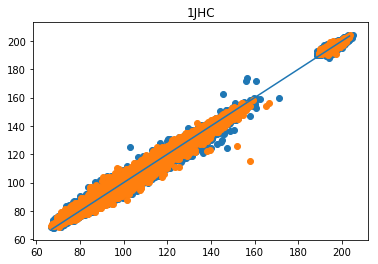

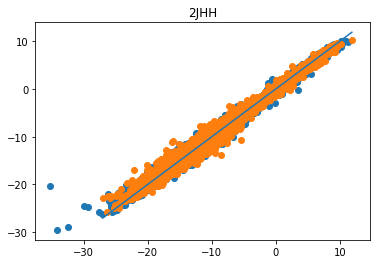

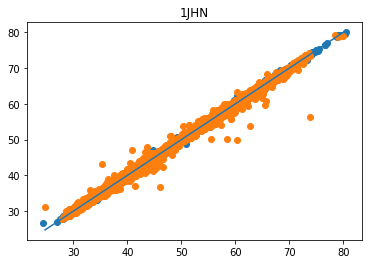

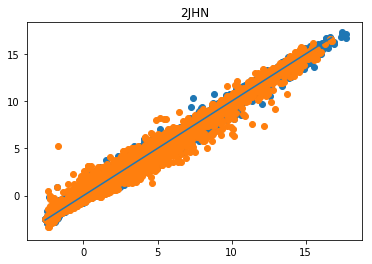

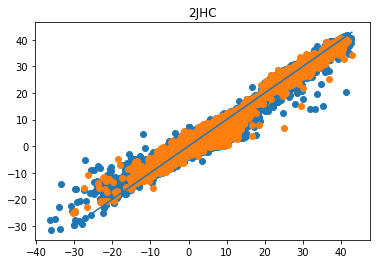

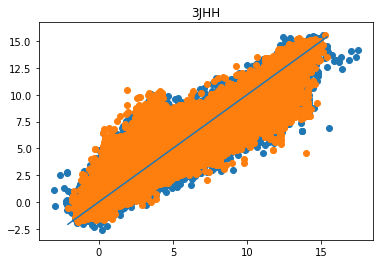

MemoryError: 

In [18]:
# scores_en = np.zeros([0])

# for i, b in enumerate(bond_types):
#     df_bond = df_train_dist.query('type == "{}"'.format(b))
#     df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
#     y_train = df_train['scalar_coupling_constant'].values
#     X_train = df_train[df_train.columns[6:]].values
    
#     df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
#     y_val = df_val['scalar_coupling_constant'].values
#     X_val = df_val[df_val.columns[6:]].values
    
#     gbm_0 = models_0[i]
#     gbm_1 = models_1[i]
#     gbm_2 = models_2[i]
#     gbm_3 = models_3[i]
#     gbm_4 = models_4[i]
    
#     y_pred_train_0 = gbm_0.predict(X_train, num_iteration=gbm_0.best_iteration)
#     y_pred_train_1 = gbm_1.predict(X_train, num_iteration=gbm_1.best_iteration)
#     y_pred_train_2 = gbm_2.predict(X_train, num_iteration=gbm_2.best_iteration)
#     y_pred_train_3 = gbm_3.predict(X_train, num_iteration=gbm_3.best_iteration)
#     y_pred_train_4 = gbm_4.predict(X_train, num_iteration=gbm_4.best_iteration)
#     y_pred_train = (y_pred_train_0 + y_pred_train_1 + y_pred_train_2 + y_pred_train_3 + y_pred_train_4) / 5.0
    
#     y_pred_0 = gbm_0.predict(X_val, num_iteration=gbm_0.best_iteration)
#     y_pred_1 = gbm_1.predict(X_val, num_iteration=gbm_1.best_iteration)
#     y_pred_2 = gbm_2.predict(X_val, num_iteration=gbm_2.best_iteration)
#     y_pred_3 = gbm_3.predict(X_val, num_iteration=gbm_3.best_iteration)
#     y_pred_4 = gbm_4.predict(X_val, num_iteration=gbm_4.best_iteration)
#     y_pred_en = (y_pred_0 + y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4) / 5.0
    
#     score = type_score(y_val, y_pred_en)
#     scores_en = np.hstack([scores_en, score])
#     plt.scatter(y_train, y_pred_train)
#     plt.scatter(y_val, y_pred_en)
#     plt.title('{}'.format(b))
#     plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
#     plt.show()

In [20]:
# print('type score:', scores_en)
# print('total score:', scores_en.mean())

type score: [-0.0401992  -1.48631417 -1.08419315 -1.51455689 -0.72261247 -0.3113131 ]
total score: -0.8598648297008449


In [19]:
with open(OUTPUT + '20190614_champs_models_lgb_en.pickle', 'wb') as f:
    pickle.dump(models_0, f)
    pickle.dump(models_1, f)
    pickle.dump(models_2, f)
    pickle.dump(models_3, f)
    pickle.dump(models_4, f)